In [ ]:
!pip install langchain_community --q
!pip install python-docx --q

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import langchain
from langchain_community.document_loaders import Docx2txtLoader


In [ ]:
# counting the files in rel18 directory
def count_files():
    path = '/kaggle/input/rag-for-telecom-networks/rel18/rel18'
    files = os.listdir(path)
    print(len(files))

count_files()

In [ ]:
# checking for repetition in the names of the files
def check_repetition():
    path = '/kaggle/input/rag-for-telecom-networks/rel18/rel18'
    files = os.listdir(path)
    for file in files:
        if files.count(file) > 1:
            print(file)

check_repetition()

In [ ]:
# reading the first file

path = '/kaggle/input/rag-for-telecom-networks/rel18/rel18'
files = os.listdir(path)
file_1 = os.path.join(path, files[2])

In [ ]:
import pandas as pd
from docx import Document
import os
from tqdm import tqdm

def clean_text(text):
    # Remove extra whitespaces and punctuation
    text = " ".join(text.split())
    return text

def extract_texts_under_subheadings(doc):
    subheadings_texts = {}

    current_subheading = None
    for paragraph in doc.paragraphs:
        if paragraph.style.name.startswith("Heading"):
            current_subheading = paragraph.text.strip()
            if "void" not in current_subheading.lower():  # Check if subheading contains "void"
                subheadings_texts[current_subheading] = []
        elif current_subheading:
            # Clean text under subheading
            cleaned_text = clean_text(paragraph.text)
            if current_subheading in subheadings_texts:  # Check if subheading was added
                subheadings_texts[current_subheading].append(cleaned_text)

    return subheadings_texts

def extract_document_metadata(doc):
    metadata = {
        "title": doc.core_properties.title,
        "author": doc.core_properties.author,
        "created": doc.core_properties.created,
        # Add more metadata fields as needed
    }
    return metadata

# Initialize lists to store data
combined_data = []

# Directory containing docx files
directory = "/kaggle/input/rag-for-telecom-networks/rel18/rel18"  # Replace with the directory containing your docx files

# Iterate through each file in the directory
for filename in tqdm(os.listdir(directory), desc="Processing Files"):
    if filename.endswith(".docx"):
        file_path = os.path.join(directory, filename)
        
        # Read the document file
        doc = Document(file_path)
        
        # Extract document metadata
        document_metadata = extract_document_metadata(doc)
        
        # Extract subheadings and texts
        subheadings_texts = extract_texts_under_subheadings(doc)
        
        # Combine metadata with subheadings and texts
        for subheading, texts in subheadings_texts.items():
            for text in texts:
                combined_data.append({
                    "Title": document_metadata["title"],
                    "Author": document_metadata["author"],
                    "Created": document_metadata["created"],
                    "Subheading": subheading,
                    "Text": text
                })




In [ ]:
# Create DataFrame and save
df_combined = pd.DataFrame(combined_data)
df_combined.to_csv('combined_data.csv', index=False)

In [ ]:
df_combined.head()

In [ ]:
df_combined["Subheading"].unique()

In [ ]:
df_combined["Text"][1000]

In [ ]:
df_combined['Created'].nunique(), df_combined['Author'].nunique()

In [ ]:
df_combined['Book_info'] = df_combined['Title'] + ' ' + df_combined['Author'] + ' ' + df_combined['Created'].astype(str)

In [ ]:
no_dupli = df_combined.drop_duplicates(keep='first')

In [ ]:
# merged subheadings per book
new_df = no_dupli.groupby(['Book_info', 'Subheading'])['Text'].apply(lambda x: ' '.join(x)).reset_index()

In [ ]:
new_df.head(50)

In [ ]:
# saving the dataframe to a csv file
new_df.to_csv('merged_data.csv', index=False)

In [ ]:
import re

def clean_text(text):
    # Convert text to lowercase
    text = str(text)
    text = text.lower()
    # Remove special characters, digits, and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespaces
    text = ' '.join(text.split())
    return text

# Cleaning subheadings
new_df['Subheading Text'] = new_df['Subheading'].apply(clean_text)
# Apply text cleaning to the "Text" column
new_df['Cleaned Text'] = new_df['Text'].apply(clean_text)

In [ ]:
# creating a book section column
new_df['Book_section'] = new_df['Book_info'] + ' -- ' + new_df['Subheading Text']
new_df

In [ ]:
# counting the number of unique texts in the cleaned text column for each row

import nltk
from nltk.tokenize import word_tokenize

# Download the necessary tokenizer data
nltk.download('punkt')

# Tokenize function
def count_tokens(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Count the number of tokens
    return len(tokens)

# Apply token count to the "Text" column
new_df['Token_Count'] = new_df['Cleaned Text'].apply(count_tokens)

In [ ]:
# dropping the rows with missing values
new_df = new_df.dropna()

In [ ]:
max_tokens = new_df['Token_Count'].max()
min_tokens = new_df['Token_Count'].min()
print(max_tokens, min_tokens)

In [ ]:
lesser = new_df[new_df['Token_Count'] < 10]
# snaller texts
small_texts = new_df[new_df['Token_Count'] < 2000]
large_texts = new_df[new_df['Token_Count'] > 2000]

In [ ]:
# Define a function to split long texts into smaller chunks
def split_long_text(text, max_words=2000):
    words = text.split()
    split_texts = []
    current_text = ''
    for word in words:
        if len(current_text.split()) + len(word.split()) <= max_words:
            current_text += ' ' + word
        else:
            split_texts.append(current_text.strip())
            current_text = word
    split_texts.append(current_text.strip())
    return split_texts

# Apply the function to the "Text" column
large_texts['Split_Text'] = large_texts['Cleaned Text'].apply(split_long_text)

# Create new rows for each split text
large_texts_split = large_texts.explode('Split_Text')

# Drop the original "Text" column and rename the "Split_Text" column
large_texts_split.drop(columns=['Cleaned Text'], inplace=True)
large_texts_split.rename(columns={'Split_Text': 'Cleaned Text'}, inplace=True)

# Reset index
large_texts_split.reset_index(drop=True, inplace=True)


In [ ]:
large_texts_split

In [ ]:
# combining the small and large texts
combined_texts = pd.concat([small_texts, large_texts_split], ignore_index=True).reset_index(drop=True)
combined_texts

In [ ]:
# shuffling the data
combined_texts = combined_texts.sample(frac=1).reset_index(drop=True)

In [ ]:
main_texts = combined_texts[['Book_section', 'Cleaned Text']]
main_texts

In [ ]:
main_texts["Cleaned Text"][0]

In [ ]:
main_texts.to_csv('main_texts.csv', index=False)

In [26]:
import pandas as pd

In [70]:
df = pd.read_csv("/kaggle/input/main-text/main_texts.csv")
df.head()

,Book_section,Cleaned Text
0,3GPP TS 38.161 Ruixin Wang 2022-08-26 03:21:00...,the trs requirements specified in clause apply...
1,3GPP TS 38.331 MCC Support 2024-01-15 08:42:00...,the ie olpcsrspos is used to convey olpc srs p...
2,3GPP TS 33.180 MCC Support 2024-03-14 08:13:00...,for each client in an external or unprotected ...
3,3GPP TS ab.cde MCC Support 2024-03-13 15:40:00...,ara the adae client and the adae server shall ...
4,3GPP TS ab.cde MCC Support 2022-11-22 09:07:00...,a data network access identifier dnai is an op...


In [71]:
text = df["Cleaned Text"]

In [72]:
text

0        the trs requirements specified in clause apply...
1        the ie olpcsrspos is used to convey olpc srs p...
2        for each client in an external or unprotected ...
3        ara the adae client and the adae server shall ...
4        a data network access identifier dnai is an op...
                               ...                        
99230    are available or the corresponding sldefaulttx...
99231    in this subclause the term interworking is use...
99232    table chsu parameter command syntax descriptio...
99233                                                 void
99234    the simple data types defined in table shall b...
Name: Cleaned Text, Length: 99235, dtype: object

In [73]:
import tiktoken

def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [74]:
text = text.astype(str)

In [75]:
counts = [num_tokens_from_string(t) for t in text]

<function matplotlib.pyplot.show(close=None, block=None)>

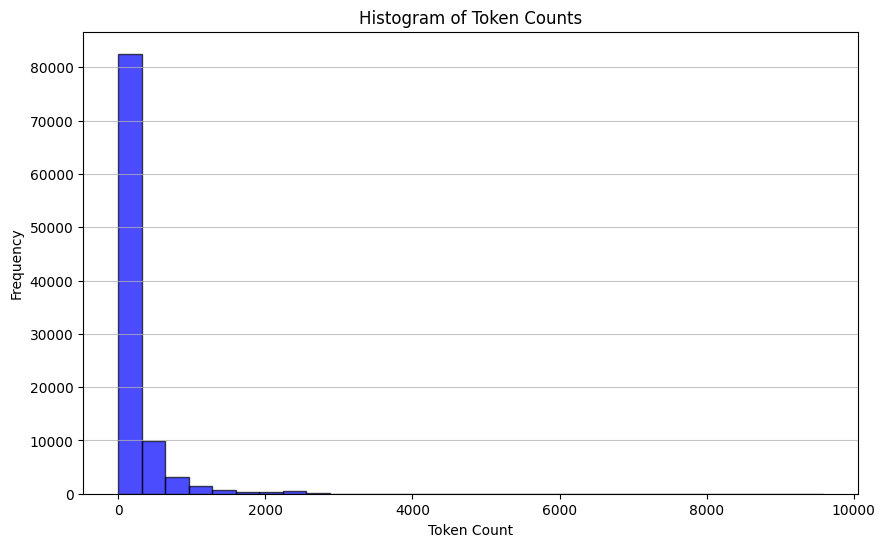

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show

In [77]:
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings
embeddings = FastEmbedEmbeddings(model_name="BAAI/bge-base-en-v1.5")

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
global_embeddings = [embeddings.embed_query(txt) for txt in text[:500]]

In [ ]:
import matplotlib.pyplot as plt
from typing import Optional
import numpy as np
import umap

def reduce_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


dim = 2
global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)
global_embeddings_reduced[0]

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], alpha=0.5)
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

def get_optimal_clusters(embeddings: np.ndarray, max_clusters: int = 50, random_state: int = 1234):
    max_clusters = min(max_clusters, len(embeddings))
    bics = [GaussianMixture(n_components=n, random_state=random_state).fit(embeddings).bic(embeddings)
            for n in range(1, max_clusters)]
    return np.argmin(bics) + 1

def gmm_clustering(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state).fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters

In [38]:
labels, _ = gmm_clustering(global_embeddings_reduced, threshold=0.5)

plot_labels = np.array([label[0] if len(label) > 0 else -1 for label in labels])
plt.figure(figsize=(10, 8))

unique_labels = np.unique(plot_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = plot_labels == label
    plt.scatter(global_embeddings_reduced[mask, 0], global_embeddings_reduced[mask, 1], color=color, label=f'Cluster {label}', alpha=0.5)

plt.title("Cluster Visualization of Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

NameError: name 'gmm_clustering' is not defined

In [24]:
import pandas as pd

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

df = pd.DataFrame({
    'Text': text[:500],
    'Embedding': list(global_embeddings_reduced),
    'Cluster': simple_labels
})
df.head()

,Text,Embedding,Cluster
0,the trs requirements specified in clause apply...,"[-1.3685664, 11.904624]",5
1,the ie olpcsrspos is used to convey olpc srs p...,"[-2.7278807, 10.146778]",0
2,for each client in an external or unprotected ...,"[-3.9363122, 8.174525]",6
3,ara the adae client and the adae server shall ...,"[-4.0909758, 9.036849]",6
4,a data network access identifier dnai is an op...,"[-3.1744723, 8.762246]",6


In [25]:
def format_cluster_texts(df):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Text'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts

In [26]:
clustered_texts = format_cluster_texts(df)
clustered_texts

{5: 'the trs requirements specified in clause apply to handheld ue configured with maximum number of rx antennas supported for each band which is specified in ts clause the trs requirements defined in clause should be verified based on the detailed test parameters in table --- common measurement uncertainty budget calculation principle was described in tr --- test environment normal see annex b rf channels to be tested m see clause base station rf bandwidth positions to be tested for multicarrier andor ca mrfbw in single band operation see clause brfbwtrfbw and brfbwtrfbw in multiband operation see clause directions to be tested the requirement for iab type o is specified as colocation requirement for general description of colocation requirements refer to clause the requirement for iab type o is verified by an eirp measurement at a direction corresponding to the ota peak directions set reference beam direction pair d for the beam identifier d which provides the highest intended eirp -

In [66]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("Falconsai/text_summarization")
model = AutoModelForSeq2SeqLM.from_pretrained("Falconsai/text_summarization")

In [67]:
def summarize_text(text, prompt="Summarize the following text concisely:", max_length=1000, min_length=100):
    # Combine prompt and text
    full_text = f"{prompt}\n\n{text}"
    
    inputs = tokenizer(full_text, return_tensors="pt", max_length=1000, truncation=True)
    
    summary_ids = model.generate(
        inputs["input_ids"],
        num_beams=4,
        max_length=max_length,
        min_length=min_length,
        length_penalty=2.0,
        early_stopping=True
    )
    
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    
    return summary

In [69]:
summaries = {}
for cluster, text in clustered_texts.items():
    try:
        summary = summarize_text(text)
        summaries[cluster] = summary
        print(f"Summarized cluster {cluster}")
    except Exception as e:
        print(f"Failed to summarize cluster {cluster}: {str(e)}")

NameError: name 'clustered_texts' is not defined

In [68]:
summaries

NameError: name 'summaries' is not defined

In [32]:
embedded_summaries = [embeddings.embed_query(summary) for summary in summaries.values()]

embedded_summaries_np = np.array(embedded_summaries)

labels, _ = gmm_clustering(embedded_summaries_np, threshold=0.5)

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

In [33]:
clustered_summaries = {}
for i, label in enumerate(simple_labels):
    if label not in clustered_summaries:
        clustered_summaries[label] = []
    clustered_summaries[label].append(list(summaries.values())[i])

In [34]:
clustered_summaries

{0: ['for ue maximum output power for modulation channel bandwidth aka maximum power reductionmpr the origin mu values for different test setups with varies parameters can be found in following clauses table b mu threshold for eirp measurements for ue maximum output power for modulation channel bandwidth --- the ota occupied bandwidth for each eutra carrier shall be less than the channel bandwidth for contiguous ca the occupied bandwidth shall be less than or equal to the aggregated channel bandwidth as defined in ',
  'optional cond ho noncriticalextension handoverpreparationinformationvdies optional noncriticalextension handoverpreparationinformationvjies optional noncriticalextension handoverpreparationinformationvjies optional noncriticalextension handoverpreparationinformationvjies optional handoverpreparationinformationvjies sequence asconfigv optional cond ho makebeforebreakreqr enumerated true optional cond ho noncriticalextension handoverpreparationinformationvjies optional ha

In [35]:
final_summaries = {}
for cluster, texts in clustered_summaries.items():
    combined_text = ' '.join(texts)
    summary = summarize_text(combined_text)
    final_summaries[cluster] = summary

In [36]:
final_summaries

{0: 'responses ref tscommondatayamlcomponentsresponses ref tscommondatayamlcomponentsresponses ref tscommondatayamlcomponentsresponses ref tscommondatayamlcomponentsresponses ref tscommon to summarize the following text concisely: for ue maximum output power for modulation channel bandwidth aka maximum power reductionmpr the origin mu values can be found'}

In [37]:
texts_from_df = df['Text'].tolist()
texts_from_clustered_texts = list(clustered_texts.values())
texts_from_final_summaries = list(final_summaries.values())

combined_texts = texts_from_df + texts_from_clustered_texts + texts_from_final_summaries

In [38]:
from langchain_community.vectorstores import Chroma

vectorstore = Chroma.from_texts(texts=combined_texts, embedding=embeddings)

In [39]:
def adjust_final_number(string: str, max_threshold: int, initial_number: int) -> int:
    final_number = initial_number
    while final_number < max_threshold:
        retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})
        docs = retriever.get_relevant_documents(string)
        text = "".join([doc.page_content for doc in docs])
        if num_tokens_from_string(text) < max_threshold:
            final_number += 1
        else:
            break
    return final_number

final_number = adjust_final_number("What is the purpose of the Nmfaf_3daDataManagement_Deconfigure service operation? [3GPP Release 18]", 10000, 4)

/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [40]:
final_number

21

In [41]:
retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})

In [125]:
from torch import cuda, bfloat16
import torch
import transformers
from transformers import AutoTokenizer
from time import time
#import chromadb
#from chromadb.config import Settings
from langchain.llms import HuggingFacePipeline
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA,ConversationalRetrievalChain
from langchain.vectorstores import Chroma

import google.generativeai as genai
from langchain import PromptTemplate

In [126]:
template = """Kindly utilize the provided context to address the question posed at the conclusion. If the information is unavailable, express that you lack the details, rather than attempting to generate an inaccurate response. Please keep your response succinct. Conclude by expressing gratitude with "Thanks for asking!"
{context}

Question: {question}

Thoughtful Response:

"""
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

In [ ]:
"""from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2")
model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2")"""

In [ ]:
"""time_1 = time()
query_pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.float32,  
    device_map="auto",
    max_length=200,
    max_new_tokens=20
)

time_2 = time()
print(f"Prepare pipeline: {round(time_2-time_1, 3)} sec.")"""

In [ ]:
#llm = HuggingFacePipeline(pipeline=query_pipeline)


llm = ChatGroq(api_key="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",temperature=0.6, model_name="microsoft/phi-2")

In [121]:
def retrieve_documents(query, retriever):
    documents = retriever.invoke(query)
    return documents

def predict_option(documents, options, llm):
    context = " ".join([doc.page_content for doc in documents])
    prompt = (
    f"Context: {context}\n\n"
    f"Options:\n" + "\n".join([f"{i+1}. {opt}" for i, opt in enumerate(options)]) + "\n\n"
    "Select the number corresponding to the option that best addresses the situation."
)
    response = llm(prompt)
    return response

In [122]:
query = "What is the purpose of the Nmfaf_3daDataManagement_Deconfigure service operation? [3GPP Release 18]"
options = [
        "To configure the MFAF to map data or analytics received by the MFAF to out-bound notification endpoints",
        "To configure the MFAF to stop mapping data or analytics received by the MFAF to out-bound notification endpoints",
        "To supply data or analytics from the MFAF to notification endpoints",
        "To fetch data or analytics from the MFAF based on fetch instructions"
    ]

In [123]:
documents = retrieve_documents(query, retriever)

In [116]:
best_option = predict_option(documents, options, llm)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=20) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


In [120]:
Markdown(best_option)

Context: service operation name nmbsmfmbssessionstatusunsubscribe description this service operation is used by the nf service consumer eg nef mbsf af to unsubscribe to notification about events related to the status of the mbs session or for a location dependent mbs session the part of the mbs session within a service area input required subscription correlation id input optional area session id output required result indication service operation name nsmfpdusessionstatusnotify description this service operation is used by the smf to notify its consumers about the status of a pdu session eg pdu session is released due to local reasons within the hsmf pdu session handover to a different system or access type triggering ismf reselection for the pdu session input required status information input optional cause small data rate control status apn rate control status target dnai information output required result indication output optional none the nonueninfounsubscribe service operation is used by a nf service consumer eg cbcf pwsiwf tsctsf to unsubscribe to the amf to stop notifying n information of a specific type eg pws indications tss the nf service consumer shall use the http method delete with the uri of the non ue n message notification individual subscription resource see clause to request the deletion of the subscription for non ue specific n information notification towards the amf see also figure figure nonueninfounsubscribe for non ue specific information the nf service consumer shall send a delete request to delete an existing subscription resource in the amf if the request is accepted the amf shall reply with the status code indicating the resource identified by subscription id is successfully deleted in the response message on failure or redirection one of the http status codes together with the response body listed table shall be returned service operation name nnefapisupportcapabilitynotify description the af is notified about the availability or expected level of support of a service api for a ue or a group of ues if it has subscribed to receive it inputs required api indication ue id or external group id inputs optional none outputs required operation execution result indication service operation name npcfmbspolicyauthorizationupdate description provides updated information to the pcf inputs required identification of the application session context inputs optional mbs service information as defined in clause outputs required success or failure reason for failure outputs optional in the case of failure the mbs service information that can be accepted by the pcf in the case of success indication that the pcf has to be contacted provides updated application level information and communicates with npcfmbspolicycontrol service to determine and install the policy according to the information provided by the nf consumer updates an application context in the pcf the gpp split architecture for ngran is described in ts the nr gnb disaggregated architecture is characterized by the presence of a single gnbcucp which is in control of one or more gnbdus and one or more gnbcuups figure similarly a gnbdu may interact with multiple gnbcuups simultaneously for the same user context as long as they are controlled by the same gnbcucp figure overall architecture for separation of gnbcucp and gnbcuup ts the gnbcucp may have specific configured data for each supported cell in the gnb and a common gnb id per plmn this identity is known in the gnbdu and in neighbor gnbs and it is also broadcasted in the served nr cells as part of the cell identity figure cp connections involving the amf gnbcucp gnbcuup and gnbdus there is one active cp anchor node per ue in the gc amf and one active cp anchor per gnb in the ngran gnbcucp figure highlights the various cp connections going through the same gnbcucp towards the amf to neighbor gnbcucps to gnbcuups and to gnbdus all cp connections terminate in the gnbcucp if we only look at the logical architecture the gnbcucp may indeed be considered as a single point of failure for operator resiliency of public network is under national regulations or other operational constraints with regard to resiliency ts includes only the following note note for resiliency a gnbdu may be connected to multiple gnbcus by appropriate implementation furthermore multiple tnl associations toward the gnbcucp are currently supported by the standard in the event of a failure at gnbcucp the likely outcome is that all user contexts could be affected and experience user service interruption this study handles failure scenarios for gnbcucp based on the current ngran architecture solutions for failure scenarios will not be addressed in this study the nodes shown in figure are logical nodes ie they can be implemented as physical network functions pnfs using dedicated hardware hw infrastructures or as virtual network functions vnfs running as software sw functions eg virtual machines vms or cloudnative containers cnfs on general purpose processors gpps with or without hw acceleration support eg in a cloud environment of a data center upon reception of the ngap handover required message if the source amf does not change the active kamf meaning no horizontal kamf derivation and if as key rekeying is not required the source amf shall increment its locally kept ncc value by one and compute a fresh nh from its stored data using the function defined in annex a the source amf shall use the kamf from the currently active gs nas security context for the computation of the fresh nh the source amf shall send the fresh nh ncc pair to the target amf in the namfcommunicationcreateuecontext request message the namfcommunicationcreateuecontext request message shall in addition contain the kamf that was used to compute the fresh nh ncc pair and its corresponding ngksi and corresponding uplink and downlink nas counts if the source amf had activated a new g nas security context with a new kamf different from the g nas security context on which the currently active g as security context is based but has not yet performed a ue context modification procedure the namfcommunicationcreateuecontext request message shall in addition contain an indication that the kamf sent by source amf to target amf is not in sync with the current kgnb used between the ue and the source gnb ie keyamfchangeind which means that as key rekeying is required at the ue further the source amf shall derive a new kgnb associated with ncc using the new kamf and the uplink nas count from the last successful nas smc procedure with the ue and provide the nh newly derived kgnb ncc pair to the target amf in the namfcommunicationcreateuecontext request message the source amf uses its local policy to determine whether to perform horizontal kamf derivation on currently active kamf if horizontal kamf derivation is performed the namfcommunicationcreateuecontext request shall contain an indication ie keyamfhderivationind that the new kamf has been calculated an indication ie keyamfchangeind that as key rekeying is required at the ue and the downlink nas count used in the horizontal derivation of the sent kamf the ngksi for the newly derived kamf key has the same value and the same type as the ngksi of the current kamf further the source amf shall derive a new kgnb associated with ncc using the newly derived kamf and the uplink nas count value of as defined in annex a the source amf shall include thenhnewly derived kgnb ncc pair and the ngksi for the newly derived kamf key in the namfcommunicationcreateuecontext request as well note a the uplink nas count value for the initial kgnb derivation is set to the reason for choosing such a value is to avoid any possibility that the value may be used to derive the same kgnb again the source amf shall always increment the downlink nas count by one after sending the namfcommunicationcreateuecontext request message to the target amf unlike the s forward relocation request message in eps the namfcommunicationcreateuecontext request message in g shall not contain data and metadata related to old g security context note void if the target amf receives the indication of horizontal kamf derivation ie keyamfhderivationind it shall derive the nas keys from the received kamf as specified in clause a and set the nas counts to zero the target amf shall create a nasc nas container containing the kamfchangeflag the received downlink nas count ngksi selected nas security algorithms and nas mac the kamfchangeflag is set to one when the target amf receives keyamfhderivationind otherwise the kamfchangeflag is set to zero if the target amf does not receive keyamfhderivationind but wants to change the nas algorithms it shall create a nasc using the selected nas security algorithms in the same manner as the case for the horizontal kamf derivation however the target amf shall not set the nas counts to zero the target amf shall calculate a bit nas mac over the parameters included in the nasc using the knasint key the input parameters to the nas bit integrity algorithms as described in annex d shall be set as follows when calculating nas mac the calculation of nas mac shall be the bit output of the selected nia and shall use the following inputs key it shall be set to the corresponding knasint count it shall be set to message it shall be set to the content of nas container as defined in ts direction its bit shall be set to and bearer it shall be set to the value of the nas connection identifier for gpp access the use of the as the value of the count for the purpose of nas mac calculationverification does not actually set the nas count to the reason for choosing such a value not in the normal nas count range ie is to avoid any possibility that the value may be reused for normal nas messages replay protection is achieved by the ue checking if the downlink nas count included in the nas container is replayed or not the ue shall not accept the same downlink nas count value twice before a newly derived kamf is taken into use and the corresponding downlink nas count is set to zero the target amf shall increment the downlink nas count by one after creating a nasc the nasc is included in the ngap handover request message to the target ngenbgnb the purpose of this nasc could be compared to a nas smc message if the target amf receives the keyamfchangeind it shall further send the received ncc nh pair and the new security context indicator nsci to the target ngenbgnb within the ngap handover request message the target amf shall further set the ncc to one and shall further compute a nh as specified in annex a the target amf shall further store the ncc nh pair note a voidnote the nas container nasc is defined as intra n mode nas transparent container in ts note the downlink nas count is always included in the namfcommunicationcreateuecontext request and used by the target amf for nas mac computation this provides replay protection for nasc if the target amf does not receive the keyamfchangeind it shall store locally the kamf and nh ncc pair received from the source amf and then send the received nh ncc pair to the target ngenbgnb within the ngap handover request message upon receipt of the ngap handover request message from the target amf the target ngenbgnb shall compute the kngran to be used with the ue by performing the key derivation defined in annex a and a with the nh ncc pair received in the ngap handover request message and the target pci and its frequency arfcndlearfcndl the gnb uses the kngran corresponding to the selected cell as kgnb the ngenb uses the kngran corresponding to the selected cell as kenb the target ngenbgnb shall associate the ncc value received from amf with the kgnbkenb the target ngenbgnb shall include the ncc value from the received nh ncc pair and the nasc if such was also received into the ho command message to the ue and remove any existing unused stored nh ncc pairs if the target ngenbgnb had received the nsci it shall set the keysetchangeindicator field in the ho command message to true note the source amf may be the same as the target amf in the description in this subclause if so the single amf performs the roles of both the source and target amf in this case actions related to n messages are handled internally in the single amf the ioc mdafunction represents the mda function which supports one or more mda capabilities after the arrival of a call from a remote user the corresponding call control entity in the network shall initiate the mm connection establishment according to clause and enter the mm connection pending state the request to establish the mm connection is passed from the cm sublayer to the mm sublayer it contains the necessary routing information derived from the setup message upon completion of the mm connection the call control entity of the network shall send the setup message to its peer entity at the mobile station start timer t and enter the call present state the setup message shall contain the multicall supported information in the network call control capabilities in the case where the network supports multicall and there are no other ongoing calls to the ms mobile stations supporting multicall shall store this information until the call control state for all calls returns to null mobile stations not supporting multicall shall ignore this information if provided in a setup message if the multicall supported information is not sent in the setup message the mobile station supporting multicall shall regard that the network does not support multicall upon receipt of a setup message the mobile station shall perform compatibility checking as described in subclause if the result of the compatibility checking was compatibility the call control entity of the mobile station shall enter the call present state an incompatible mobile station shall respond with a release complete message in accordance with subclause if there are no bearer capability ies in the setup message the network may provide information about the requested service in the backup bearer capability ie if no response to the setup message is received by the call control entity of the network before the expiry of timer t the procedures described in subclause shall apply figure gpp ts mobile terminating call initiation and possible subsequent responses the solution has impacts in the following entities gc entities amf smf pcf upf none ngran support indirecttoindirect path relay reselection measurement criteria configuration remote ue remote ue needs to support handover procedures for untrusted nongpp access via niwf over l uetonw relay with niwf indirect communication path gnbdus sharing the same physical cell resources receive via fc information enabling identifying broadcast mbs sessions providing identical content the identification is based on associated session id for location dependent mbs services the mbs service area is also taken into account applying resource efficiency for ran sharing with multiple cellid broadcast resolve different qos requirements received from the participating gcs in an implementation specific way fu resources are established towards either all involved gnbcus or only some of them which is decided by the entity controlling the involved gnbdus sharing the same physical cell resources the gnbdu is able to trigger the gnbcu to establish fu resources the gnbcucp takes into account the decision fu resources have been established or not to decide whether to establish ngu resources annex p of the present document should be followed with the following additions to protect the discovery messages between the ue and the veasdf which is used as the dns server for eas discovery in the roaming case if the core network is used to configure the security information the vsmf is preconfigured with the veasdf security information credentials to authenticate the veasdf supported security mechanisms port number etc and provides the security information to the ue as follows in the case of lbo roaming the vsmf provides the veasdf security information to the ue via pco in the case of hr with session breakout hrsbo roaming scenarios during the pdu session establishment or modification procedure the vsmf provides the veasdf security information via nsmfpdusessioncreate nsmfpdusessionupdate to hsmf when the vsmf determines to use a veasdf for eas discovery and the hsmf provides the veasdf security information to ue via pco if hr sbo is authorized note the security information of veasdf provided to the ue is only related with the vplmn parameter the present document defines the user plane of gtp used on the gn and gp interfaces of the general packet radio service gprs the iu gn and gp interfaces of the umts system the su su sa sb x s s s s m and sn interfaces of the evolved packet system eps the fu xn wu n n n nmb and nmb interfaces of the g system gs this definition ensures full backwards compatibility with rnc sgsn and ggsn implementations according to release of gpp ts note releases previous to release have used gpp ts as normative definition of the user plane of gtp this shall be considered when essential corrections are included in the present document or in prerelease version of gpp ts fallback from gtpvu to gtpvu shall not be supported therefore gpp rel and onwards gtpvu entity should not listen to the wellknown gtpv port if gtpv entity listens to the gtpv port the entity shall silently discard any received gtpvu message figure depicts the g system roaming architecture with local breakout with servicebased interfaces within the control plane figure roaming g system architecture local breakout scenario in servicebased interface representation note in the lbo architecture the pcf in the vplmn may interact with the af in order to generate pcc rules for services delivered via the vplmn the pcf in the vplmn uses locally configured policies according to the roaming agreement with the hplmn operator as input for pcc rule generation the pcf in vplmn has no access to subscriber policy information from the hplmn note an scp can be used for indirect communication between nfs and nf services within the vplmn within the hplmn or in within both vplmn and hplmn for simplicity the scp is not shown in the roaming architecture note for clarity the nwdafs with roaming exchange capability renwdaf and their connections with other nfs are not depicted in the servicebased architecture diagram for more information on network data analytics architecture refer to ts note depending on the architecture deployed the primary or centralized nsacf at the vplmn can fetch the maximum number of registered ues or the maximum number of lbo pdu sessions to be enforced from the hplmn primary or centralized nsacf as described in clause figure void figure depicts the g system roaming architecture in the case of home routed scenario with servicebased interfaces within the control plane figure roaming g system architecture home routed scenario in servicebased interface representation note an scp can be used for indirect communication between nfs and nf services within the vplmn within the hplmn or in within both vplmn and hplmn for simplicity the scp is not shown in the roaming architecture note upfs in the home routed scenario can be used also to support the ipups functionality see clause note for clarity the nwdafs with roaming exchange capability renwdaf and their connections with other nfs are not depicted in the servicebased architecture diagram for more information on network data analytics architecture refer to ts figure depicts g system roaming architecture in the case of local break out scenario using the reference point representation figure roaming g system architecture local breakout scenario in reference point representation note the nrf is not depicted in reference point architecture figures refer to figure for details on nrf and nf interfaces note for the sake of clarity sepps are not depicted in the roaming reference point architecture figures note for clarity the nwdafs with roaming exchange capability renwdaf and their connections with other nfs are not depicted in the reference point architecture figure for more information on network data analytics architecture refer to ts the following figure depicts the g system roaming architecture in the case of home routed scenario using the reference point representation figure roaming g system architecture home routed scenario in reference point representation the n references point can be between vsmfs in the same vplmn or between vsmfs in different vplmns to enable interplmn mobility note for clarity the nwdafs with roaming exchange capability renwdaf and their connections with other nfs are not depicted in the reference point architecture figure for more information on network data analytics architecture refer to ts for the roaming scenarios described above each plmn implements proxy functionality to secure interconnection and hide topology on the interplmn interfaces figure nrf roaming architecture in reference point representation note for the sake of clarity sepps on both sides of plmn borders are not depicted in figure figure void operators can deploy upfs supporting the inter plmn up security ipups functionality at the border of their network to protect their network from invalid inter plmn n traffic in home routed roaming scenarios the upfs supporting the ipups functionality in vplmn and hplmn are controlled by the vsmf and the hsmf of that pdu session respectively a upf supporting the ipups functionality terminates gtpu n tunnels the smf can activate the ipups functionality together with other up functionality in the same upf or insert a separate upf for the ipups functionality in the up path which eg may be dedicated to be used for ipups functionality figure depicts the home routed roaming architecture where a upf is inserted in the up path for the ipups functionality figure depicts the home routed roaming architecture where the two upfs perform the ipups functionality and other up functionality for the pdu session note operators are not prohibited from deploying the ipups functionality as a separate network function from the upf acting as a transparent proxy which can transparently read n and n interfaces however such deployment option is not specified and needs to take at least into account very long lasting pdu sessions with infrequent traffic and interplmn handover the ipups functionality is specified in clause and ts figure roaming g system architecture home routed roaming scenario in servicebased interface representation employing upf dedicated to ipups figure procedure for qos sustainability analytics in a finer granularity the nf consumer requests or subscribes to analytics information on qos sustainability provided by the nwdaf the parameters included in the request are defined in clause of ts the nf can request statistics or predictions or both the consumer provides the tais or cell ids andor finer granularity area eg below cell via longitudelatitude range etc in location information when requesting qos sustainability analytics if the af doesnt provide tais or cell ids the nwdaf as an gc internal nf is expected to obtain such information ie to determine which cells are related to the finer granularity area the consumer may optionally provide ue context or subscription information such as one or more of the following device speed or speed range serving upf node information subscriber category as in ts clause device model device manufacturer imei or imeisv or tac range supported frequency bands equipment type a if the request is authorized and in order to provide the requested analytics the nwdaf decides the amfs based on the taiscell ids and obtains the ue list in the tascells from amf by invoking namfeventexposuresubscribe service operation using event id number of ues present in a geographical area as described in ts b the nwdaf invokes namfeventexposuresubscribe service operation to get the update of the ue list using event id ue moving in or out of area of interest as described in ts the nwdaf initiates the lcs service request to the gmlclmf to get the location and optionally the speed of ues from ue list provided by the amf in step the gmlclmf initiates the ue location service procedure and gets the location of the ues the gmlclmf provides location information for each ue in the ue list to the nwdaf from the list of ue locations returned by the gmlclmf the nwdaf identifies the ues located in finer granularity area by comparing the ues locations to the finer granularity area provided in step the nwdaf invokes namfeventexposuresubscribe service operation to get the serving smf for the ue based on the serving smf in step the nwdaf invokes nsmfeventexposuresubscribe service operation to get the upf information for the ue the nwdaf may collect qos information either from the upf directly or subscribe to the upf via the smf the qos information may include the bandwidth packet delay for the ue and the information on the serving upf node id optionally the nwdaf may collect additional information for the ue context or ue subscription from the udm such as subscriber category pei if available pei may be used to retrieve from gsma database additional information such as device model device manufacturer imei or imeisv or tac range supported frequency bands equipment type such additional information may be used by nwdaf to add more information to the collected measurements and filter those measurements that are applicable to the ue and subscription context for which analytics are requested by the service consumer the nwdaf verifies whether the triggering conditions are met and derives the requested analytics the nwdaf can detect the need for notification based on comparing the requested analytics of the target qi against the reporting thresholds provided by the consumer in any cell over the requested analytics target period the nwdaf provides the response or notification on qos sustainability to the nf consumer note nwdaf may decide to ignore some of the filters if collected measurements are not sufficient to derive meaningful analytics in such scenario a warning message is provided in the response or notification to the nf consumer note in order to reduce the amount of information collected per measurement point the additional information from udm may only be collected for the events of gbr unfulfillment in this way the additional analytics filter information may only be supported for qi of resource type gbr and for events of gbr unfulfillment network services involving mrfc and mrfp are not limited to conferencing and announcements but also involve transcoding support for interworking between imss or interdomain sessions and intradomain sessions between access technologies supported in an ims eg wireline wireless interworking or interworking with nongpp wireless technologies the mrfc and mrfp act as transcoding entity in an ims solving media encoding mismatches due to codec selection between operator networks as well as to deal with encoding formats in a converged service environment service requests sent to the mrfc shall contain sufficient information to associate the systems that require media transcoding and also for reservation of resources required at the mrfp the mrfc shall always grant the requests from the control plane unless there is a lack of resources media transcoding support based on mrfcmrfp shall support the offeranswer procedure as defined in ietf rfc additional description of transcoding support involving the mrfcmrfp is provided in annex p service operation name nudmeventexposureunsubscribe description the consumer deletes the subscription of an event if already defined in udm inputs required subscription correlation id outputs required operation execution result indication a trusted wlan access network twan is interfaced with the epc as a trusted nongpp access via the sta interface to the gpp aaa serverproxy and the sa interface to the pdn gw as described in clause of ts authentication and key agreement shall be performed as described in clause and clause of the present document for trusted nongpp access the authenticator shall reside in the twan the gpp aaa server sendsthe key msk and key derived from emsk to the twan the security contexts in the twan are based on msk and key derived from emsk the interfaces inside the twan shall be integrity and confidentialityprotected note integrity and confidentialityprotection may be provided by cryptographical or physical means summary based on the input provided by huawei hisilicon in sp g multicast and broadcast service specifies architectural enhancements to the g system using nr to support multicast and broadcast communication services encompasses support for functions such as how to deliver multicast and broadcast communications including support within certain location areas mobility mbs session management and qos and covers interworking with eutran and epc based embms for public safety eg mcx services the wi is linked to the ran wi on nr multicast and broadcast services as documented in ts the following features for g multicast and broadcast service are specified architectural enhancement mbs architecture defined in ts follows the g system architectural principles enabling distribution of the mbs data from the gs ingress to ngran nodes and then to the ue qos model and parameters as defined in ts also apply to multicastbroadcast communication services with several differences documented in ts the policy and charging control framework as defined in ts applies to multicast and broadcast services ie for mbs session binding qos flow binding pcc rules for mbs session and policy information gc individual mbs traffic delivery is for multicast only and in which gc receives a single copy of multicast packets and delivers separate copies of those multicast packets to individual ues via perue pdu sessions hence for each such ue one pdu session is required to be associated with a multicast mbs session gc shared mbs traffic delivery can be used for multicast and broadcast and in which gc receives a single copy of mbs data packets and delivers a single copy of those mbs data packets to a ran node see following figure for details figure user plane data transmission example gc should authorize the af for delivering mbs data to the gc andor interacting with the gc nef perform authorization to the external af for determination of whether the interaction with the gc is allowed or not multicast communication service it aims at providing the same service and same specific content data to a dedicated set of ues the following characteristics for multicast are included in the wi for multicast mbs session gc authorizes the ue based on the mbs subscription data based on mbs subscription data of the ue and the mbs session information local multicast service is the multicast mbs service limited in a certain mbs service area and it is enforced by ngran node and gc a location dependent multicast service is an mbs service provided in several mbs service areas when ue moves to a new mbs service area content data from the new mbs service area shall be delivered to the ue and the network ceases to deliver the content data from the old mbs service areas to the ue mobility support of mbs service ue may move from one ngran node to another ngran node after ue has joined the mb session to minimize the data loss of the ue during the handover procedure multicast mbs session data may be forwarded from source ngran node to target ngran node session activation and deactivation the mbs session activation procedure is used for activating the resources for mbs data at ngran node the mbs session deactivation procedure is used for deactivating the resources for mbs data at ngran node resources can be efficiently used by a proper control of session activationdeactivation broadcast communication service it is to provide the same service and the same specific content data are provided simultaneously to all ues in a geographical area for location dependent broadcast service it is similar as the one for multicast intersystem mobility with interworking at service layer in order to minimize the interruption of services upon mobility for mbs service from nrgc to eutranepc and vice versa the interworking is supported at service layer security for multicastbroadcast service as defined in ts controlplane procedure and userplane procedure are optionally supported in service layer for security protection of mbs traffic the user plane security between ue and ran shall be deactivated when gc shared mbs traffic delivery method for mbs data transmission is used to avoid redundant protection references related crs set tsg status approved in httpsportalgpporgchangerequestsaspxqworkitem sp new wid architectural enhancements for g multicastbroadcast services huawei cbn rp wid revision nr multicast and broadcast services huawei hisilicon cbn ts architectural enhancements for g multicastbroadcast services ts system architecture for the g system gs ts policy and charging control framework for the g system gs ts security architecture and procedures for g system api operation name notifycmodeswitching description notification of the c communication mode switching from the uas ues known consumers uas application specific server inputs refer clause outputs refer clause see clause for the details of usage of this api operation this clause describes the procedures for mobile originated transport in control plane ciot gs optimisation where the pdu session is terminated at a upf figure upf anchored mobile originated data transport in control plane ciot gs optimisation if the ue is cmconnected it sends a nas message carrying the ciphered pdu session id and ciphered uplink data as payload if the ue is in cmidle the ue first establishes an rrc connection or sends the rrcearlydatarequest message and sends a nas message as part of this the ue may also send nas release assistance information nas rai included in the nas message nas rai indicates that no further uplink and downlink data transmissions are expected or that only a single downlink data transmission eg acknowledgement or response to uplink data subsequent to this uplink data transmission is expected a in the nbiot case during step the ngran based on configuration may retrieve the nbiot ue priority and the expected ue behaviour parameters from the amf if not previously retrieved based on such parameters the ngran may apply prioritisation between requests from different ues before triggering step and throughout the rrc connection the ngran may retrieve additional parameters eg ue radio capabilities ngran forwards the nas message to the amf using the initial nas message procedure if the ue was in cmidle before step or using the uplink nas transport procedure if the ue was in cmconnected before step if rrcearlydatarequest message was received in step the ngran includes edt session indication in the n initial ue message the rai signalled by mac based on the buffer status report bsr see ts shall not be used when using control plane ciot gs optimisations amf checks the integrity of the incoming nas message and deciphers the pdu session id and uplink data if a nas rai is received from the ue and it conflicts with the expected ue behaviour the nas rai takes precedence a if the amf received edt session indication from the ngran in step the amf sends an n message to the ngran a in the case of nas rai with uplink data and it indicated that downlink data was not expected and the amf does not expect any other signalling with the ue the amf shall either send a nas service accept in the n downlink nas transport message and include end indication to indicate that no further data or signalling is expected with the ue or alternatively the amf sends an n connection establishment indication message including end indication to indicate that no further data or signalling is expected with the ue b if the amf determines more data or signalling may be pending the amf sends an n downlink nas transport message or initial context setup request message without end indication b if a was executed the ngran completes the rrc early data procedure as follows a for the case of aa the ngran proceeds with rrcearlydatacomplete message the procedure is completed in step b for the case of ab the ngran proceeds with rrc connection establishment procedure in that case all steps up to step apply amf determines the vsmf handling the pdu session based on the pdu session id contained in the nas message and passes the pdu session id and the data to the vsmf by invoking nsmfpdusessionsendmodata service operation if ngran forwarded the nas message to the amf using the initial nas message procedure in step and the ue is accessing via nbiot rat then the amf may inform the hsmfs whether the rrc establishment cause is set to mo exception data as described in clause of ts the amf may immediately send the mo exception data counter to the hsmf if no downlink data is expected based on the nas rai from the ue in step and if the amf is not aware of pending mt traffic then amf does not wait for step and continues with step the vsmf decompresses the header if header compression applies to the pdu session and forwards the data to the upf the upf forwards the data to the dn based on data forwarding rule eg in the case of unstructured data tunnelling may be applied according to clause of ts conditional in the nonroaming and lbo case the upf forwards available downlink data to the vsmf in the homerouted roaming case the hupf forwards the data to the vupf then to the vsmf conditional the vsmf compresses the header if header compression applies to the pdu session the vsmf forwards the downlink data and the pdu session id to the amf using the namfcommunicationnnmessagetransfer service operation conditional the amf creates a dl nas transport message with the pdu session id and the downlink data the amf ciphers and integrity protects the nas transport message conditional the amf sends the dl nas transport message to ngran if nas rai indicated for single uplink and single downlink packets eg acknowledgment expected and amf has determined the data transmission is for single uplink and single downlink packets the amf includes an end indication in the dl nas transport message to indicate that no further data or signalling is expected with the ue conditional ngran delivers the nas payload over rrc to the ue if no further data or signalling is pending and amf received nas rai indicating single downlink data transmission then amf triggers the an release procedure clause and the procedure stops after this step conditional if no further activity is detected by ngran then ngran triggers the an release procedure conditional the ues logical ngap signalling connection and rrc signalling connection are released according to clause note the details of the ngap messages to be used for this procedure are specified in ts --- if pcscf supports resource sharing is supported for this access technology and if according to local policy the pcscf shall apply the procedures in subclause l --- in the following procedure the tssf reports the adc rule error when the adc rule cant be enforced any longer figure st notification initiated by the tssf the tssf reports the adc rules error by sending a diameter tnr command to the pcrf as defined in subclause c of gpp ts the pcrf acknowledges to the tssf by sending a diameter tna command --- this solution provides differentiated service for nongpp devices connected behind a grg in this solution the grg receives qos rules for the nongpp devices behind the grg then the grg uses the corresponding data transfer tunnel to transfer the packets of the nongpp devices according to the qos rules this solution is used for nonauthenticable nongpp naun devices the grg is preconfigured or receives session policy for nongpp devices from the network during its pdu session establishment procedure the session policy for nongpp devices describes the following information a to establish a qos flow for one category of nongpp devices b the dnn snssai corresponding to the pdu session of the qos flow for nongpp devices c the nongpp device category identifier the nongpp device category identifier is used to identify one or a group of nongpp devices the nongpp device category identifier is a standardized value eg qi d mapping relationship between nongpp device category identifier and the corresponding port number range used for the packets of the nongpp device category when transferred in the gs when the grg detects the connection of a nongpp device the grg requests to establish a qos flow for the nongpp device according to the session policy if there is already a corresponding pdu session ie a pdu sessions with the same dnnsnssai the grg performs pdu session modification procedure if there is no corresponding pdu sessions ie no pdu sessions with the same dnnsnssai the grg performs pdu session establishment procedure --- the procedure for requesting nlan services is as follows figure af requesting predefined sfc policies the procedure is as follows option the af is aware of the available sfcs and corresponding sfc policy identifiers in a network this can be based on sla agreements option af requesting sfc policies based on predefined sf services available either in the gc or hosted by a rd party the af is triggered to discover an sfc policy for example enable voice transcoding the af invokes an nnefsfcpolicygetrequest including an identifier of the asp optionally external identifiers gpsi and a list of sf service ids the nef forwards the request to the pcf invoking an npcfsfcpolicycreate request the pcf may check in the udr if there are available sfc policies for the asp the pcf makes a policy decision and determines the sfc policies for the aspif there in no sfc policy available for the requested service the pcf rejects the request the pcf includes the sfc policy according to the af request identified by an sfc policy identifier the nef forwards the response to the af editors note whether option or option will be used for configuration of sfc policies when the sfc is hosted by the gc operator is to be determined at conclusions phase --- the leaf indicates options for when a ue is allowed to transfer the pdu session providing access to ims between gcn via nongpp access and gcn via ngran occurrence zeroorone format int access types get replace values indicates that a ue having an ongoing ims session is not allowed to transfer the pdu session providing access to ims between gcn via nongpp access and gcn via ngran and that a ue which does not have an ongoing ims session is allowed to transfer the pdu session providing access to ims if any between gcn via nongpp access and gcn via ngran indicates that a ue having an ongoing ims session is allowed to transfer the pdu session providing access to ims between gcn via nongpp access and gcn via ngran and that a ue which does not have an ongoing ims session is allowed to transfer the pdu session providing access to ims if any between gcn via nongpp access and gcn via ngran indicates that a ue is not allowed to transfer a pdu session providing access to ims if any between gcn via nongpp access and gcn via ngran irrespective of if the ue has an ongoing ims session or not indicates that a ue roaming in a vplmn and having an ongoing ims session is not allowed to transfer the pdu session providing access to ims between gcn via nongpp access and gcn via ngranand that a ue which is roaming in a vplmn and does not have an ongoing ims session is allowed to transfer the pdu session providing access to ims if any between gcn via nongpp access and gcn via ngran indicates that a ue roaming in a vplmn and having an ongoing ims session is allowed to transfer the pdu session providing access to ims between gcn via nongpp access and gcn via ngranand that a ue which is roaming in a vplmn and does not have an ongoing ims session is allowed to transfer the pdu session providing access to ims if any between gcn via nongpp access and gcn via ngran indicates that a ue roaming in a vplmn is not allowed to transfer a pdu session providing access to ims if any between gcn via nongpp access and gcn via ngran irrespective of if the ue has an ongoing ims session or not note if the value of this leaf is set to a ue can select another ipcan type in idle mode eg due to ue domain preference using the procedures to reestablish the pdu session providing access to ims as specified in gpp ts note if this mo is configured it is assumed that the ursp rules are configured consistently with this mo --- the network may initiate the paging procedure for cs services when the ms is imsi attached for cs services via emm combined procedures as described in gpp ts at reception of an indication of paging for cs services from emm the ms shall stop timer t if it is running the mm sublayer in the ms requests emm to perform the service request procedure for cs fallback after the ms changes to a geran or utran cell the ms shall in agb mode ask for the establishment of an rr connection and proceed as if a paging has been received in the lower layers in iu mode ask for the establishment of an rrc connection and respond with the paging response message defined in gpp ts subclause for reasons of backward compatibility the paging response shall use the rr protocol discriminator if the ms determines before sending the response to paging that it is in a different location area than the stored location area the ms shall initiate a normal location updating procedure first regardless of network mode of operation additionally the ms performs routing area updating as specified in subclause if the location area of the current cell is not available the ms may initiate a normal location updating procedure directly when initiating the location updating procedure the ms shall indicate cs fallback mobile terminating call in the additional update parameters ie and the ms shall not include the ms network feature support ie the mm connection establishment is delayed until successful completion of the normal location updating procedure after the completion of the normal location updating procedure the ms shall not send the paging response message note for the race condition when the mobile station has a cm application request pending the mobile station also indicates that it has a followon request pending --- figure depicts the g system roaming architecture with local breakout with servicebased interfaces within the control plane figure roaming g system architecture local breakout scenario in servicebased interface representation note in the lbo architecture the pcf in the vplmn may interact with the af in order to generate pcc rules for services delivered via the vplmn the pcf in the vplmn uses locally configured policies according to the roaming agreement with the hplmn operator as input for pcc rule generation the pcf in vplmn has no access to subscriber policy information from the hplmn note an scp can be used for indirect communication between nfs and nf services within the vplmn within the hplmn or in within both vplmn and hplmn for simplicity the scp is not shown in the roaming architecture note for clarity the nwdafs with roaming exchange capability renwdaf and their connections with other nfs are not depicted in the servicebased architecture diagram for more information on network data analytics architecture refer to ts note depending on the architecture deployed the primary or centralized nsacf at the vplmn can fetch the maximum number of registered ues or the maximum number of lbo pdu sessions to be enforced from the hplmn primary or centralized nsacf as described in clause figure void figure depicts the g system roaming architecture in the case of home routed scenario with servicebased interfaces within the control plane figure roaming g system architecture home routed scenario in servicebased interface representation note an scp can be used for indirect communication between nfs and nf services within the vplmn within the hplmn or in within both vplmn and hplmn for simplicity the scp is not shown in the roaming architecture note upfs in the home routed scenario can be used also to support the ipups functionality see clause note for clarity the nwdafs with roaming exchange capability renwdaf and their connections with other nfs are not depicted in the servicebased architecture diagram for more information on network data analytics architecture refer to ts figure depicts g system roaming architecture in the case of local break out scenario using the reference point representation figure roaming g system architecture local breakout scenario in reference point representation note the nrf is not depicted in reference point architecture figures refer to figure for details on nrf and nf interfaces note for the sake of clarity sepps are not depicted in the roaming reference point architecture figures note for clarity the nwdafs with roaming exchange capability renwdaf and their connections with other nfs are not depicted in the reference point architecture figure for more information on network data analytics architecture refer to ts the following figure depicts the g system roaming architecture in the case of home routed scenario using the reference point representation figure roaming g system architecture home routed scenario in reference point representation the n references point can be between vsmfs in the same vplmn or between vsmfs in different vplmns to enable interplmn mobility note for clarity the nwdafs with roaming exchange capability renwdaf and their connections with other nfs are not depicted in the reference point architecture figure for more information on network data analytics architecture refer to ts for the roaming scenarios described above each plmn implements proxy functionality to secure interconnection and hide topology on the interplmn interfaces figure nrf roaming architecture in reference point representation note for the sake of clarity sepps on both sides of plmn borders are not depicted in figure figure void operators can deploy upfs supporting the inter plmn up security ipups functionality at the border of their network to protect their network from invalid inter plmn n traffic in home routed roaming scenarios the upfs supporting the ipups functionality in vplmn and hplmn are controlled by the vsmf and the hsmf of that pdu session respectively a upf supporting the ipups functionality terminates gtpu n tunnels the smf can activate the ipups functionality together with other up functionality in the same upf or insert a separate upf for the ipups functionality in the up path which eg may be dedicated to be used for ipups functionality figure depicts the home routed roaming architecture where a upf is inserted in the up path for the ipups functionality figure depicts the home routed roaming architecture where the two upfs perform the ipups functionality and other up functionality for the pdu session note operators are not prohibited from deploying the ipups functionality as a separate network function from the upf acting as a transparent proxy which can transparently read n and n interfaces however such deployment option is not specified and needs to take at least into account very long lasting pdu sessions with infrequent traffic and interplmn handover the ipups functionality is specified in clause and ts figure roaming g system architecture home routed roaming scenario in servicebased interface representation employing upf dedicated to ipups --- the epdg shall provide the iripoi and ccpoi functions in the following network topology cases roaming case in vplmn --- this ie shall be included if the uplink data status ie is included in the registration request message or if the allowed pdu session status ie is included in the registration request message and there is at least one pdu session indicated in the allowed pdu session status ie for which the userplane resources can be reestablished over gpp access --- ue configured with the fqdn of the global easdf needs to receive pdu session configuration in an srv record and use information from the record to establish a pdu session when existing pdu session should be used then the ue uses the ip address from the global easdf instead of the one provided in the epco from the pdu session establishment procedure for the easdf global easdf acts as a dns server and responds to the dns queries from the ue the dns is configured with standard dns srv records that contains pdu session configuration --- this solution is for key issue it addresses particularly how to enforce the service area restriction for a group of ues particular the solution focus on the scalability issue in the ki how to manage communication among the ue group members when they are served by different upfs and different smfs including the case of ues mobility this needs to take the signalling scalability issues for large vn groups with lots of devices into account from the r there is a condition for the vn when n is used there is a full mesh of n tunnels between upfs serving the g vn group when there are multiple smfsupfs if the full mesh mechanism is used there are more cuplane connections eg there are m smfs and n upfs with the full mesh topology the signalling connection between smfs is m m number of n tunnels is n n from the following figure when the number of node eg smfupf exceeds the star topology has more advantages figure so there is a need to reduce the number of interfaces from the square of the number of nodes to a linear relationship of the number of nodes on the top of solution it paper further proposes a solution to change to full mesh topology to star topology when the complexity of topology exceeds the threshold the following figure the star topology for the smfs for the upfs it is similar figure --- figure geran agb mode to eutran inter rat ho execution phase note for a pmipbased ss procedure steps a are defined in ts steps and a concern gtp based ss the source sgsn continues to receive downlink and uplink user plane pdus when source sgsn receives the forward relocation response message it may start downlink npdu relay and duplication to the target enodeb for direct forwarding or via the serving gw for indirect forwarding and the target enodeb may start blind transmission of downlink user data towards the ue over the allocated radio channels the source sgsn completes the preparation phase towards source bss by sending the message ps ho required acknowledge tlli list of set up pfcs target rnc to source bss transparent container cause this message includes all pfis that could be established on the target side the cause includes the value from the ran cause ie received from the target mme the target rnc to source bss transparent container includes the value from the target to source transparent container received from the target mme before sending the ps handover required acknowledge message the source sgsn may suspend downlink data transfer for any eps bearer contexts before sending the ps handover command message to the ue the source bss may try to empty the downlink bss buffer for any bss pfcs the source bss will command the ue to handover to the target enodeb via the message ps handover command the access system specific message to ue includes a transparent container including radio aspect parameters that the target enodeb has setup in the preparation phase void the ue moves to the eutran and performs access procedures toward target enodeb when the ue has got access to target enodeb it sends the message ho to eutran complete the ue shall implicitly derive the eps bearers for which an erab was not established from the ps handover command and deactivate them locally without an explicit nas message at this step when the ue has successfully accessed the target enodeb the target enodeb informs the target mme by sending the message handover notify taiecgi as a separate activity the target enodeb retrieves the ue eutra capability information using the procedure for ue radio capability handling see clause if dual connectivity is activated for the ue the pscell id shall be included in the handover notify message then the target mme knows that the ue has arrived to the target side and target mme informs the source sgsn by sending the forward relocation complete notification isr activated serving gw change message if indicated isr activated indicates to the source sgsn that it shall maintain the ues contexts and activate isr which is only possible when the sgw is not changed the source sgsn shall also acknowledge that information when the forward relocation complete notification message has been received and there is no longer any need for the sgsn to forward data the sgsn stops data forwarding a timer in source sgsn is started to supervise when resources in the source serving gw for serving gw relocation shall be released upon receipt of the forward relocation complete acknowledge message the target mme starts a timer if the target mme applies indirect forwarding the target mme will now complete the handover procedure by informing the serving gw for serving gw relocation this will be the target serving gw that the target mme is now responsible for all the eps bearers the ue have established this is performed in the message modify bearer request cause mme tunnel endpoint identifier for control plane eps bearer ids mme address for control plane enodeb addresses and teids for user traffic for the accepted eps bearers and rat type isr activated user location information pscell id per pdn connection as it is a mobility from geran if the target mme supports location information change reporting the target mme shall include the user location information according to the supported granularity in the modify bearer request regardless of whether location information change reporting had been requested in the previous rat by the pdn gw if the pdn gw requested user csg information determined from the ue context the mme also includes the user csg information ie in this message if the ue time zone has changed the mme includes the ue time zone ie in this message if the serving gw is not relocated but the serving network has changed or if the mme has not received any old serving network information from the old sgsn the mme includes the new serving network ie in this message if indicated isr activated indicates that isr is activated which is only possible when the sgw was not changed when the modify bearer request does not indicate isr activated and sgw is not changed the sgw deletes any isr resources by sending a delete bearer request to the other cn node that has bearer resources on the sgw reserved if the mme has received pscell id in step it shall include it in modify bearer request the mme releases the nonaccepted dedicated bearers by triggering the bearer release procedure as specified in clause if the serving gw receives a dl packet for a nonaccepted bearer the serving gw drops the dl packet and does not send a downlink data notification to the mme if the default bearer of a pdn connection has not been accepted by the target enodeb and there are other pdn connections active the mme shall handle it in the same way as if all bearers of a pdn connection have not been accepted the mme releases these pdn connections by triggering the mme requested pdn disconnection procedure specified in clause the serving gw for serving gw relocation this will be the target serving gw informs the pdn gws the change of for example for serving gw relocation or the rat type that eg can be used for charging by sending the message modify bearer request per pdn connection the sgw also includes user location information ie andor ue time zone ie andor user csg information ie if they are present in step serving network should be included if it is received in step or in step in clause for serving gw relocation the serving gw allocates dl teids on ss even for nonaccepted bearers and pdn charging pause support indication shall be included the pdn gw must acknowledge the request with the message modify bearer response charging id msisdn pdn charging pause enabled indication if pdn gw has chosen to enable the function etc to the serving gw if location information change reporting is required and supported in the target mme the pdn gw shall provide ms info change reporting action in the modify bearer response if pcc infrastructure is used the pdn gw informs the pcrf about the change of for example the rat type if the serving gw is relocated the pdn gw shall send one or more end marker packets on the old path immediately after switching the path in order to assist the reordering function in the target enodeb the source serving gw shall forward the end marker packets to the source sgsn the serving gw for serving gw relocation this will be the target serving gw acknowledges the user plane switch to the target mme via the message modify bearer response cause serving gw tunnel endpoint identifier for control plane serving gw for serving gw relocation this will be the target serving gw address for control plane protocol configuration options ms info change reporting action at this stage the user plane path is established for all bearers between the ue target enodeb serving gw for serving gw relocation this will be the target serving gw and pdn gw if the serving gw does not change the serving gw shall send one or more end marker packets on the old path immediately after switching the path in order to assist the reordering function in the target enodeb when the timer at the source sgsn started in step expires the source sgsn will cleanup all its resources towards source bss by performing the bss packet flow delete procedure the ue initiates a tracking area update procedure when one of the conditions listed in clause triggers for tracking area update applies the target mme knows that an irat handover has been performed for this ue as it received the bearer contexts by handover messages and therefore the target mme performs only a subset of the ta update procedure specifically it excludes the context transfer procedures between source sgsn and target mme if the subscription data received from the hss during the tau in step contains information that is necessary for the eutran to be aware of eg a restriction in the ues permission to use nr as a secondary rat unlicensed spectrum in the form of laalwalwipnru as specified in clause or a combination of them or an existing ue context in the mme indicates that the ue is not permitted to use nr as a secondary rat unlicensed spectrum or a combination of them and the mme has not provided this information to the target enodeb during step of the handover preparation phase then the mme sends an updated handover restriction list in the downlink nas transport message that it sends to eutran if the ue is not allowed to use nr as secondary rat the mme indicates that to the ue in tau accept message when the timer at the source sgsn started in step expires and if the source sgsn received the serving gw change indication in the forward relocation response message it deletes the eps bearer resources by sending delete session request cause operation indication messages to the source serving gw the operation indication flag is not set that indicates to the source serving gw that the source serving gw shall not initiate a delete procedure towards the pdn gw the source serving gw acknowledges with delete session response cause messages if isr has been activated before this procedure the cause indicates to the source sgw that the source sgw shall delete the bearer resources on the other old cn node by sending delete bearer request messages to that cn node if indirect forwarding was used then the expiry of the timer at source sgsn started at step triggers the source sgsn to send a delete indirect data forwarding tunnel request message to the sgw to release the temporary resources used for indirect forwarding if indirect forwarding was used and the serving gw is relocated then the expiry of the timer at target mme started at step triggers the target mme to send a delete indirect data forwarding tunnel request message to the target sgw to release temporary resources used for indirect forwarding --- table cgpp ts gprs session management timers ms side note typically the procedures are aborted on the fifth expiry of the relevant timer exceptions are described in the corresponding procedure description note the backoff timer is used to describe a logical model of the required ms behaviour this model does not imply any specific implementation eg as a timer or timestamp note reference to backoff timer in this section can either refer to use of timer t or to use of a different packet system specific timer within the ms whether the ms uses t as a backoff timer or it uses different packet system specific timers as backoff timers is left up to ms implementation table dgpp ts gprs session management timers network side note typically the procedures are aborted on the fifth expiry of the relevant timer exceptions are described in the corresponding procedure description --- ts specifies two management modes for pninpn and three management modes for snpn under mnovertical managed mode for pninpn and mnovertical managed mode for snpn the vertical also plays the role of npn operator shared with mobile network operator to achieve management on the npn served for the vertical therefore a bundle of management capabilities and corresponding managed resources should be exposed to the vertical from the mobile network operator according to the business agreement between the two parties under mnovertical managed mode figure vertical managing pninpn through exposure figure as an example illustrates how the plmn operator and the vertical manage the pninpn under the mnovertical managed mode the pninpn which is deployed across one plmn and the verticals premises eg factory can be seen as an endtoend network composed of two differentiated segments one public consisting of a ran and network functions built upon public gc network resources and one private consisting of network functions deployed using nonpublic g network resources the vertical can realize the management of pninpn through management capabilities exposure figure vertical managing snpn through exposure figure as an example illustrates how the plmn operator and the vertical manage the snpn under the mnovertical managed mode the snpn is deployed as an independent isolated network all snpn network elements are located inside the logical perimeter of the verticals premises eg factory and the snpn is separate from the plmn the plmn operator and the vertical play the role of snpn operator together and the vertical can realize the management of snpn through management capabilities exposure exposing what kind of management capability and managed resources eg local upf gnbs belong to vertical covering specific geographic areas etc for vertical relies on specific cases such as as described in clause the capability of monitoring network errors and alarms could be exposed to vertical to support its fault rootcause analysis localization etc on npn according to the issue described in clause the capability of configuring the npn network resources especially for those assets belong to the vertical eg local upf or local gnbs covering specific geographic areas for a specific vertical could further be exposed to vertical to satisfy the specific logical andor physical resource isolation requirements for energy applications categorized into different safety zones according to the issue described in clause the capability of monitoring kpiskqis like communication service availability endtoend latency etc could further be exposed to vertical to detect performance degradation and support performance optimization on npn --- this clause describes the procedure for path switch from a g prose uetonetwork relay to mbs session figure illustrates path switch from a g prose uetonetwork relay to mbs session figure path switch from a g prose uetonetwork relay to mbs session the remote mc service client is receiving the mc service media using the unicast delivery via a g prose uetonetwork relay ue this step applies to both g prose layer and layer uetonetwork relay based on the remote mc service ues path selection policies described in gpp ts and once the ngran based measurement report discussed in gpp ts is triggered due to network coverage detectionthe remote mc service ue connects to the network via the uuinterface note the path selection policies may be preconfigured in the mc service ue or provided by the pcf as defined in gpp ts for the case of g prose layer uetonetwork relay without the support of niwf the remote mc service client performs sip reregistration over uu and initiates the ims service continuity procedures as described in annex b further the mc service server sends mc service communications using unicast delivery which traverses over uu to the remote mc service client note for the case of g prose layer uetonetwork relay via the support of niwf the remote mc service ue performs registration procedures towards the gs to establish the necessary resources over the uuinterface note for the case of g prose layer uetonetwork relay the gc can provide the service continuity for the remote mc service ue with the ues original ip address as described in gpp ts the mc service client receives the mc service communication over a unicast pdu session optionally the mc service server may send the mbs session announcement to the remote mc service client with the information of the mbs session note the information of the mbs session can be available at the remote mc service client due to a previous mc service signalling via the relay ue a if a multicast mbs session has been announced the mc service ue performs a ue session join towards the gc using the mbs session information and the mc service client may send a ue session join notification towards the server b if a broadcast mbs session has been announced the mc service client start monitoring the reception quality of the broadcast mbs session the mc service client sends an mbs listening status report which indicates the mbs reception quality associated with the mbs session id is sufficient to receive media note it is implementation specific whether the mbs session reception quality level is determined per mbs session per media stream or per mbs qos flow level via eg measurements of radio level signalling such as the reference signals from the ngran nodes packet loss based on the report received from mc service client in step the mc service server determines to stop sending the mc service communications eg dl media application layer control signalling using the unicast delivery further the mc server sends the mc service communications via the mbs session the mc service client receives the mc service communications from the mc service server via the mbs session --- during registration procedure in gs the ue sends ue policy container including the list of psis and ursp delivery over eps indication to amf in registration request as described in clause of ts amf transparently forwards ue policy container to uepcf during ue policy association establishment as described in clause uepcf stores ursp delivery over eps indication the uepcf determines whether the ue policy association established in gs can be maintained in eps based on this indication as described in clauses and --- support for network capability exposure enables an af eg an external asp to request the following session management related policy control functionality from the nef set or change a chargeable party at af session setup see clause and of ts set up an af session with required qos see clause and clause of ts request qos traffic characteristics provisioning and performance monitoring for an individual ue or a group of ues see clause of ts transfer of traffic characteristics of time sensitive communication from the tsn af see clause or from the tsctsf see clause a set up a time synchronization service from the tsctsf see clauses and a of ts and clause of ts --- the main services and functions of sdap include mapping between a qos flow and a data radio bearer marking qos flow id qfi in both dl and ul packets a single protocol entity of sdap is configured for each individual pdu session --- figure handover from eps to gcniwf initial status one or more pdn connections have been established in epc between the g capable ue and the pgw via eutran the ue initiates registration procedure on untrusted nongpp access via niwf with gguti is available or suci if not per clause the ue initiates a ue requested pdu session establishment with existing pdu session indication in gc via untrusted nongpp access via niwf per clause if the request type indicates existing emergency pdu session the amf shall use the emergency information received from the hssudm which contains smfpgwc fqdn for ss interface for the emergency pdn connection established in eps and the amf shall use the snssai locally configured in emergency configuration data the combined pgwsmfupf initiates a pdn gw initiated bearer deactivation as described in clause of ts to release the epc and eutran resources --- this clause describes the nsac for maximum number of registered ues and for maximum number of pdu sessions for network slice subjected to eps interworking the nsac for maximum number of ue with at least one pdu sessionpdn connection is described in clause a a network slice subject to both nsac and eps counting shall be configured with only one of the options maximum number of registered ues andor maximum number of pdu session or maximum number of ues with at least one pdu sessionpdn connection andor maximum number of pdu session if eps counting is required for a network slice the nsac for maximum number of ues andor for maximum number of pdu sessions per network slice is performed at the time of pdn connection establishment in case of epc interworking to support the nsac for maximum number of ues andor for maximum number of pdu sessions per network slice in epc the smfpgwc is configured with the information indicating which network slice is subject to nsac during pdn connection establishment in epc the smfpgwc selects an snssai associated with the pdn connection as described in clause if the selected snssai by the smfpgwc is subject to the nsac the smfpgwc triggers interaction with nsacf to check the availability of the network slice by invoking separate nsac procedures for number of ue and number of pdu session as described in clause of ts before the smfpgwc provides the selected snssai to the ue if the network slice is available the smfpgwc continues to proceed with the pdn connection establishment procedure the nsacf performs the following for checking network slice availability prior to returning a response to the smfpgwc for nsac for number of ues if the ue identity is already included in the list of ue ids registered with a network slice or the ue identity is not included in the list of ue ids registered with a network slice and the current number of ue registration did not reach the maximum number the nsacf responds to the smfpgwc with the information that the network slice is available the nsacf includes the ue identity in the list of ue ids if not already on the list and increases the current number of ue registration otherwise the nsacf returns a response indicating that the maximum number with the network slice has been reached if hierarchical nsac architecture is deployed when the local maximum number or local threshold is reached the nsacf may interact with the primary nsacf before it returns the response back to the smfpgwc for more details on handling at the nsacf and primary nsacf see clause for nsac for number of pdu sessions if the current number of pdu sessions is below the maximum number the nsacf responds to the smfpgwc with the information that the network slice is available the nsacf increases the current number of pdu sessions otherwise the nsacf returns the response indicating that the maximum number with the network slice has been reached if hierarchical nsac architecture is deployed when the local maximum number is reached the nsacf may interact with the primary nsacf before it returns the response back to the smfpgwc for more details on handling at the nsacf and primary nsacf see clause if the maximum number of ues andor the maximum number of pdu sessions has already been reached unless operator policy implements a different action the smfpgwc rejects the pdn connection note as an implementation option if the apn is mapped to more than one snssai and the first selected snssai is not available eg either current number of ue registration reached maximum or current number of pdu sessions reached maximum then based on the operator policy the pgwcsmf can try another mapped snssai for the pdn connection establishment procedure if the establishment of a new pdn connections is with a different smfpgwc from the smfpgwc used for already existing pdn connection associated with the same snssai each smfpgwc will send a request for update eg increase or decrease to the nsacf the nsacf may maintain a registration entry per smfpgwc for the same ue id the smfpgwc provides the access type to the nsacf when triggering a request to increase or decrease the number of ues andor the number of pdu sessions for an snssai note the smfpgwc determines the access type based on the rat type parameter in the pmip or gtp message received from the epdg or alternatively it can internally determine the access type based on the source node eg sgw sending the request for the pdn connection establishment when the ue with ongoing pdn connections moves from epc to gc the smfpgwc triggers a request to decrease the number of the ue registration in nsacf and the amf triggers a request to increase the number of the ue registration in nsacf when the ue is registered in the new amf if there are more than one pdn connections associated with the snssai the nsacf may receive multiple requests for the same snssai from different smfpgwcs when the ue with ongoing pdu sessions moves from gc to epc the smfpgwc triggers a request to increase the number of the ue registration in nsacf and the old amf triggers a request to decrease the number of the ue registration in nsacf when the ue is deregistered in old amf if there are more than one pdu sessions associated with the snssai the nsacf may receive multiple requests for the same snssai from different smfpgwcs the nsacf maintains a list of ue ids based on the requests from smfpgwcs and amf and adjusts the current number of registrations accordingly when eps counting is performed for a network slice and the ue with ongoing pdn connections moves from epc to gc session continuity is guaranteed from nsac standpoint as the admission was granted at the time of pdn connection establishment ie the number of pdu session is not counted again in gc similarly when the ue with ongoing pdu sessions moves from gc to epc session continuity is guaranteed from nsac standpoint as the admission of the pdn connections to the network slice was already granted at the time of pdu session establishment in gc if the pdn connection associated with snssai is released in epc the smfpgwc triggers a request ie decrease to nsacf for maximum number of ues andor maximum number of pdu sessions per network slice control the nsacf decreases the current number of registrations and removes the ue identity from the list of ue ids if the pdn connections associated with the snssai are all released in epc note nsac in epc is not performed for the attachment without pdn connectivity if eps counting is not required for a network slice the nsac for maximum number of ues andor for maximum number of pdu sessions per network slice is performed when the ue moves from epc to gc ie when the ue performs mobility registration procedure from epc to gc nsac for maximum number of ues per network slice andor when the pdn connections are handed over from epc to gc nsac for maximum number of pdu sessions per network slice the smfpgwc is configured with the information indicating the network slice is subject to nsac only in gs the pdn connection interworking procedure is performed as described in clause mobility from epc to gc does not guarantee all active pdu sessions can be transferred to the gc in certain circumstances when either the current number of ue registration or the current number of pdu sessions would exceed the maximum number when the ue moves from epc to gc when the ue with ongoing pdu sessions moves from gc to epc the smfpgwc triggers a request to decrease the number of pdu session to nsacf if there are more than one pdu sessions associated with the snssai the nsacf may receive multiple requests for the same snssai from different smfpgwcs and nsacf removes the pdu session ids while decreasing the number of pdu sessions note given that session continuity is not guaranteed when eps counting is not required it is recommended for services which require the session continuity to support eps counting note when multiple nsacfs are deployed and if the number of ue in target nsacf has reached the maximum number whether session continuity can be guaranteed is left to implementation note when a centralized architecture is deployed ue admission is guaranteed at intersystem and interamf mobility if the same nsacf is selected this is the case for nonroaming scenarios and for roaming scenarios with hplmn nsac admission mode described in clause --- figure illustrates the network slice fault management process to address the key issue of network slice fault management described in clause preconditions the val client has subscribed to the network slice fault management capability the network slice enabler layer is capable to interact with nef and oam system the val client has checked the status of application layer figure network slice fault management process the val server sends a request to nsce server to request for the fault diagnosis of the applications and networks when it detected a fault in the application layer the services and the network slices this request may be triggered by the errors of the applications detected by the val server itself or the val server may periodically collect the fault diagnostic report subscribing to the network slice fault management capability the fault information of applications may be included in this request for example the service availability failure events eg described as fallback events carried out by the dual sim cellular device on receiving the request from val server nsce server retrieves the performance data of network slice from gs for oam system the apis defined in clause ts is utilized for cn functions the apis of nnwdafanalyticsinfo service defined in clause ts can be utilized the analytics data defined in clause to clause ts network slice instance related performance data defined in clause ts and network analytics data in clause and clause ts exposed by oam system may be acquired nsce server retrieves the alarms of network slice instances from oam system via the procedures defined in clause ts and the alarms are defined in clause ts eg the fault of communication environmental equipment processing error qos for deviceresourcefilefunctionalitysmallest nsce server may request the alarm information eg the gs network is not work or the required performance is under the threshold which leads the services problem collected by nsce client if possible the information collected by the nsce client depends on the thirdparties requirements and implementation nsce client report the requested fault information to nsce server nsce server correlates the applications services and the network resources of the specific network slice instances which supports the applications and services with the snssai nsi id nsinstanceid defined in ts application identifier defined in and then diagnoses the causes of the fault of the applications or services by analysing the fault information from different sources for example the ran function of the slice instance which is utilized to support the service of the smart grid application for a certain time duration the smart grid suffered the bad experience caused by service availability failure events and in the ran function is detected continuously to report an alarm of environmental fault in the same time duration then the environment fault may be the root cause of the service availability failure and should be prioritized to be solved the fault may be identified with critical major minor ignore to show its prioritization nsce server response to val server with the reports of fault diagnostic result to indicate the causes of the failures of the applications or services if there is no problem within the gs network the val server may be requested to check the application layer itself again if the nsce server detects that the applicationservice error is caused by the gs the val server may send the fault diagnosis report to oam system to indicate the server fault which causes the applicationservice failure by utilizing the nsceoam interface note the apis utilized to send the fault diagnosis report to oam will reutilize the fault management services in ts exposed by egmf as defined in ts --- the request type in step indicates existing pdu session or existing emergency pdu session the smf determines that the request is due to switching between gpp access and nongpp access or due to handover from eps the smf identifies the existing pdu session based on the pdu session id in such a case the smf does not create a new sm context but instead updates the existing sm context and provides the representation of the updated sm context to the amf in the response if the request type is initial request and if the old pdu session id is included in nsmfpdusessioncreatesmcontext request the smf identifies the existing pdu session to be released based on the old pdu session id subscription data includes the allowed pdu session types allowed ssc modes default qi and arp subscribed sessionambr smfassociated external parameters ip index or static ip addressprefix may be included in the subscription data if the ue has subscribed to it the smf checks the validity of the ue request it checks whether the ue request is compliant with the user subscription and with local policies if the selected dnn corresponds to an ladn whether the ue is located within the ladn service area based on the ue presence in ladn service area indication from the amf if the amf does not provide the ue presence in ladn service area indication and the smf determines that the selected dnn corresponds to a ladn then the smf considers that the ue is out of the ladn service area the smf determines whether the pdu session requires redundancy and the smf determines the rsn as described in clause of ts if the smf determines that redundant handling is not allowed or not possible for the given pdu session the smf shall either reject the establishment of the pdu session or accept the establishment of a pdu session without redundancy handling based on local policy if the ue request is considered as not valid the smf decides to not accept to establish the pdu session note the smf can instead of the nudmsdmget service operation use the nudmsdmsubscribe service operation with an immediate report indication that triggers the udm to immediately return the subscribed data if the corresponding feature is supported by both the smf and the udm for a disaster roaming service the udm provides the session management subscription data to the smf based on the local policy andor the local configuration as specified in clause of ts for an snssai subject to nsac and if lbo applies the smf in supporting vplmn stores the applicable nsac admission mode from smf to amf either nsmfpdusessioncreatesmcontext response cause sm context id or n sm container pdu session reject cause or an nsmfpdusessionupdatesmcontext response depending on the request received in step if the smf received nsmfpdusessioncreatesmcontext request in step and the smf is able to process the pdu session establishment request the smf creates an sm context and responds to the amf by providing an sm context id if the up security policy for the pdu session is determined to have integrity protection set to required the smf may based on local configuration decide whether to accept or reject the pdu session request based on the ue integrity protection maximum data rate note the smf can eg be configured to reject a pdu session if the ue integrity protection maximum data rate has a very low value if the services provided by the dn would require higher bitrates when the smf decides to not accept to establish a pdu session the smf rejects the ue request via nas sm signalling including a relevant sm rejection cause by responding to the amf with nsmfpdusessioncreatesmcontext response the smf also indicates to the amf that the pdu session id is to be considered as released the smf proceeds to step and the pdu session establishment procedure is stopped optional secondary authenticationauthorization if the request type in step indicates existing pdu session the smf does not perform secondary authenticationauthorization if the request type received in step indicates emergency request or existing emergency pdu session the smf shall not perform secondary authenticationauthorization if the smf needs to perform secondary authenticationauthorization during the establishment of the pdu session by a dnaaa server as described in clause of ts the smf triggers the pdu session establishment authenticationauthorization as described in clause a if dynamic pcc is to be used for the pdu session the smf performs pcf selection as described in clause of ts if the request type indicates existing pdu session or existing emergency pdu session the smf shall use the pcf already selected for the pdu session otherwise the smf may apply local policy b the smf may perform an sm policy association establishment procedure as defined in clause to establish an sm policy association with the pcf and get the default pcc rules for the pdu session the smf shall include the gpp data off status if received in step the gpsi pvs fqdns andor pvs ip addresses and the onboarding indication shall be included if available at smf in the case of onsnpn the smf shall include both the snssai and the alternative snssai if received in step if the request type in step indicates existing pdu session the smf provides information on the policy control request trigger conditions that have been met by an smf initiated sm policy association modification procedure as defined in clause the pcf may provide policy information defined in clause and in ts to smf the ursp rule enforcement in step may be included if smf receives the ursp rule enforcement from ue as described in clause of ts the pcf for the ue subscribes to notifications of event ue reporting connection capabilities from associated ursp rule as defined in clause in ts using npcfpolicyauthorizationsubscribe eventid set to ue reporting connection capabilities from associated ursp rule eventfilter set to at least list of connection capabilities to the pcf for the pdu session the pcf for session may notify the pcf for ue about the ursp rule enforcement together with the pdu session parameters that this application associated with by npcfpolicyauthorizationnotify during the sm policy association establishment procedure if the pcf detects the request relates to sm policy association enabling integration with tsn or tsc or deterministic networking as defined in ts clause based on local configuration the pcf may provide policy control request trigger for gs bridgerouter information as defined in clause of ts the pcf based on the emergency dnn sets the arp of the pcc rules to a value that is reserved for emergency services as described in ts note the purpose of step is to receive pcc rules before selecting upf if pcc rules are not needed as input for upf selection step can be performed after step during the sm policy association establishment procedure for a nonroaming pdu session if a snssai is subject to network slice usage control the pcf may provide a slice usage policy information including whether a network slice is on demand and a pdu session inactivity timer value as described in clause of ts if the request type in step indicates initial request the smf selects an ssc mode for the pdu session as described in clause of ts the smf also selects one or more upfs as needed as described in clause of ts in the case of pdu session type ipv or ipv or ipvv the smf allocates an ip addressprefix for the pdu session unless configured otherwise as described in clause of ts in the case of pdu session type ipv or ipvv the smf also allocates an interface identifier to the ue for the ue to build its linklocal address for unstructured pdu session type the smf may allocate an ipv prefix for the pdu session and n pointtopoint tunnelling based on udpipv as described in clause of ts for ethernet pdu session type neither a mac nor an ip address is allocated by the smf to the ue for this pdu session if the amf indicated control plane ciot gs optimisation in step for this pdu session then for unstructured pdu session type the smf checks whether ues subscription include a nef identity for nidd for the dnnsnssai combination when the nef identity for nidd is present in the ues subscription data the smf will select the nef identified for the snssai and selected dnn in the nef identity for nidd as the anchor of this pdu session otherwise the smf will select a upf as the anchor of this pdu session for other pdu session types the smf will perform upf selection to select a upf as the anchor of this pdu session if the request type in step is existing pdu session the smf maintains the same ip addressprefix that has already been allocated to the ue in the source network if the request type in step indicates existing pdu session referring to an existing pdu session moved between gpp access and nongpp access the smf maintains the ssc mode of the pdu session the current pdu session anchor and ip address note the smf may decide to trigger eg new intermediate upf insertion or allocation of a new upf as described in step in clause if the request type indicates emergency request the smf selects the upf as described in clause of ts and selects ssc mode smf may select a upf eg based on requested dnnsnssai that supports nwtt functionality smf may select a psa upf that supports pdu set identification and marking for a qos flow with pdu set based handling capability smf may perform an smf initiated sm policy association modification procedure as defined in clause to provide information on the policy control request trigger conditions that have been met if request type is initial request and dynamic pcc is deployed and pdu session type is ipv or ipv or ipvv smf notifies the pcf if the policy control request trigger condition is met with the allocated ue ip addressprefixes note if an ip addressprefix has been allocated before step eg subscribed static ip addressprefix in udmudr or the step is performed after step the ip addressprefix can be provided to pcf in step and the ip addressprefix notification in this step can be skipped pcf may provide updated policies to the smf the pcf may provide policy information defined in clause and in ts to smf the pcf for pdu session may generate pcc rule based on the ursp rule eg connection capability referring to the clause in ts note mapping between connection capability and sdf templates in the pcc rule is implementation specific if request type indicates initial request the smf initiates an n session establishment procedure with the selected upfs otherwise it initiates an n session modification procedure with the selected upfs a the smf sends an n session establishmentmodification request to the upf and provides packet detection enforcement and reporting rules to be installed on the upf for this pdu session if the smf is configured to request ip address allocation from upf as described in clause of ts then the smf indicates to the upf to perform the ip addressprefix allocation and includes the information required for the upf to perform the allocation if the selective user plane deactivation is required for this pdu session the smf determines the inactivity timer and provides it to the upf for a pdu session for nonroaming subscribers if the snssai of the pdu session is subject to network slice usage control the smf obtains the pdu session inactivity timer value for the pdu session as described in step or step or uses preconfigured value and configures the upf to run the pdu session inactivity timer the smf provides trace requirements to the upf if it has received trace requirements if the reliable data service is enabled for the pdu session by the smf as specified in ts the rds configuration information --- the enumeration upconfidentiality indicates whether up confidentiality protection is required preferred or not needed for all the traffic on the pdu session it shall comply with the provisions defined in table table enumeration upconfidentiality --- the cgf is responsible for persistent cdr storage for preparing cdr files and transferring them to the bd via the bx reference point to this end the cgf provides one or more files on which to store the cdrs after potential reformatting to comply with the bx file format specified in ts the cdrs may be routed to one of several simultaneously open files inside the cgf depending on certain cdr parameters such as cdr type or on other criteria such as the originating cdf cdr files are closed on the cgf based on certain operator configured parameters for example file size limit file duration time limit time of day maximum number of cdrs this implies that the closure of a cdr file occurs asynchronously to the reception of cdrs on the cgf when a cdr file is closed the cgf must assure that a new cdr file is available to store incoming cdrs in line with the cdr routing facility described above once cdr files are closed they are ready for transfer to the bd the cgf shall support both push transfer mode ie cgf triggers and controls file transfer to bd and pull transfer mode ie bd triggers and controls file transfer in push mode the cgf uploads the files to the bd according to operator specified parameters such as time of day number of available files etc in pull mode the bd may request the files from the cgf at any point in time at the discretion of the bd for all procedures involved in cdr reception processing and storing the cgf shall be capable of complying with near realtime requirements details on the protocol application for the open bx interface and the functionality of the cgf can be found in ts the semantics and formal description of the cdr parameters are specified in ts --- interworking with eps is supported for a pdu session if the pdu session includes the mapped eps bearer contexts or has associations between qos flow and mapped eps bearer after intersystem change from s mode to n mode the smf shall not include any mapped eps bearer contexts associated with a pdu session for ladn and with a pdu session which is a multihomed ipv pdu session if the ue receives any mapped eps bearer context for a pdu session for ladn or for a multihomed ipv pdu session the ue may locally delete the mapped eps bearer context see coding of the mapped eps bearer contexts ie in subclause in an ma pdu session the ue shall have one set of the mapped eps bearer contexts the network can provide the set of the mapped eps bearer contexts of the ma pdu session via either access of the ma pdu session in an ma pdu session the ue shall support modification or deletion via an access of a mapped eps bearer context of the ma pdu session created via the same or the other access upon intersystem change from n mode to s mode the ue shall create the default eps bearer context and the dedicated eps bearer contexts based on the parameters of the mapped eps bearer contexts or the associations between qos flow and mapped eps bearer in the pdu session if available the eps bearer identity assigned for the qos flow of the default qos rule becomes the eps bearer identity of the default bearer in the corresponding pdn connection if there is no eps bearer identity assigned to the qos flow of the default qos rule of a pdu session associated with gpp access or if there is no corresponding mapped eps bearer contexts associated with the eps bearer identity assigned to the qos flow of the default qos rule of a pdu session associated with gpp access a the pdu session is not an ma pdu session established over both gpp access and nongpp access the ue shall perform a local release of the pdu session or b the pdu session is an ma pdu session established over both gpp access and nongpp access the ue shall perform a local release of the pdu session over gpp access and consider that the ma pdu session is established over nongpp access only if there is no eps bearer identity assigned to the qos flows of a pdu session associated with gpp access which is not associated with the default qos rule or if there is no corresponding mapped eps bearer contexts associated with the eps bearer identity assigned to the qos flow of the nondefault qos rule of a pdu session associated with gpp access unless the pdu session is an ma pdu session established over gpp access and over nongpp access the ue shall locally delete the qos rules and the qos flow descriptions the ue uses the parameters from each pdu session for which interworking with eps is supported to create corresponding default eps bearer context and optionally dedicated eps bearer contexts as follows a the pdu session type of the pdu session shall be mapped to the pdn type of the default eps bearer context as follows the pdn type shall be set to nonip if the pdu session type is unstructured the pdn type shall be set to ipv if the pdu session type is ipv the pdn type shall be set to ipv if the pdu session type is ipv the pdn type shall be set to ipvv if the pdu session type is ipvv the pdn type shall be set to nonip if the pdu session type is ethernet and the ue the network or both of them do not support ethernet pdn type in s mode and the pdn type shall be set to ethernet if the pdu session type is ethernet and the ue and the network support ethernet pdn type in s mode b the pdu address of the pdu session shall be mapped to the pdn address of the default eps bearer context as follows the pdn address of the default eps bearer context is set to the pdu address of the pdu session if the pdu session type is ipv ipv or ipvv and the pdn address of the default eps bearer context is set to zero if the pdu session type is ethernet or unstructured c the dnn of the pdu session shall be mapped to the apn of the default eps bearer context unless the pdu session is an emergency pdu session d the apnambr and extended apnambr received in the parameters of the default eps bearer context of the mapped eps bearer contexts shall be mapped to the apnambr and extended apnambr of the default eps bearer context e for each pdu session in state pdu session active pdu session modification pending or pdu session inactive pending if the ue is performing an intersystem change from n mode to wbs mode the ue shall set the state of the mapped eps bearer contexts to bearer context active or if the ue is performing an intersystem change from n mode to nbs mode for the mapped eps bearer context corresponding to the default eps bearer the ue shall set the state of the mapped eps bearer context to bearer context active additionally if the ue is performing an intersystem change from wbn mode to nbs mode for the mapped eps bearer context corresponding to a dedicated eps bearer if any the ue shall set the state of the mapped eps bearer context to bearer context inactive and f for any other pdu session the ue shall set the state of the mapped eps bearer contexts to bearer context inactive additionally for each mapped eps bearer context or the association between qos flow and mapped eps bearer in the pdu session a the eps bearer identity shall be set to the eps bearer identity received in the mapped eps bearer context or the eps bearer identity associated with the qos flow b the eps qos parameters shall be set to the mapped eps qos parameters of the eps bearer received in the mapped eps bearer context or the eps qos parameters associated with the qos flow c the extended eps qos parameters shall be set to the mapped extended eps qos parameters of the eps bearer received in the mapped eps bearer context or the extended eps qos parameters associated with the qos flow and d the traffic flow template shall be set to the mapped traffic flow template of the eps bearer received in the mapped eps bearer context or the stored traffic flow template associated with the qos flow if available after intersystem change from n mode to s mode the ue shall associate the pdu session identity the snssai and the sessionambr with the default eps bearer context and for each eps bearer context mapped from one or more qos flows associate the qos rules for the qos flows and the qos flow descriptions for the qos flows with the eps bearer context if the pdu session is associated with the control plane only indication and supports interworking with eps after intersystem change from n mode to s mode the ue shall associate the eps bearer contexts of the pdn connection corresponding to the pdu session with the control plane only indication if the pdu session is associated with a pdu session pair id after intersystem change from n mode to s mode the ue shall associate the default eps bearer context of the pdn connection corresponding to the pdu session with the pdu session pair id if the pdu session is associated with an rsn after intersystem change from n mode to s mode the ue shall associate the default eps bearer context of the pdn connection corresponding to the pdu session with the rsn after intersystem change from n mode to s mode the ue and the smf shall maintain the pdu session type of the pdu session until the pdn connection corresponding to the pdu session is released if the ue supports nonip pdn type and the pdu session type is ethernet or unstructured after intersystem change from n mode to s mode the ue and the smf shall maintain the following gsm attributions and capabilities associated with the pdu session until the pdn connection corresponding to the pdu session is released a the alwayson pdu session indication b the maximum number of supported packet filters c the support of reflective qos d the maximum data rate per ue for userplane integrity protection supported by the ue for uplink and the maximum data rate per ue for userplane integrity protection supported by the ue for downlink e the support of multihomed ipv pdu session and f if the pdu session is an ma pdu session established over gpp access the pdn connection of the default eps bearer corresponding to the ma pdu session shall be considered as a userplane resource of the ma pdu session after intersystem change from n mode to s mode the ue operating in singleregistration mode in a network supporting n interface shall deem that the following features are supported by the network on the pdn connection corresponding to the pdu session a ps data off and b local address in tft if there is a qos flow used for ims signalling after intersystem change from n mode to s mode the eps bearer associated with the qos flow for ims signalling becomes the eps bearer for ims signalling when the ue is provided with a new sessionambr in the protocol configuration options ie or extended protocol configuration options ie in the modify eps bearer context request message the ue shall discard the corresponding association and associate the new valuewith the default eps bearer context the network may provide the ue with one or more qos rules by including either one qos rules parameter or one qos rules with the length of two octets parameter but not both in the protocol configuration options ie or extended protocol configuration options ie in the modify eps bearer context request message the network may provide the ue with one or more qos flow descriptions corresponding to the eps bearer context being modified by including either one qos flow descriptions parameter or one qos flow descriptions with the length of two octets parameter but not both in the protocol configuration options ie or extended protocol configuration options ie in the modify eps bearer context request message when the ue is provided with one or more qos flow descriptions or the eps bearer identity of an existing qos flow description is modified in the protocol configuration options ie or extended protocol configuration options ie in the modify eps bearer context request message the ue shall check the eps bearer identity included in the qos flow description and a if the eps bearer identity corresponds to the eps bearer context being modified or the eps bearer identity is not included the ue shall store the qos flow description and all the associated qos rules if any for the eps bearer context being modified for use during intersystem change from s mode to n mode and b otherwise the ue shall locally delete the qos flow description and all the associated qos rules if any and include a protocol configuration options ie or extended protocol configuration options ie with a gsm cause parameter set to gsm cause syntactical error in the qos operation in the modify eps bearer context accept message when the ue is provided with one or more qos rules or one or more qos flow descriptions in the protocol configuration options ie or extended protocol configuration options ie in the modify eps bearer context request message the ue shall process the qos rules sequentially starting with the first qos rule and shall process the qos flow descriptions --- figure shows the charging data transactions that are required between scscf ibcf and cdf in each ims network when a third party as located in another network involved in the session provides eg valueadded service and real time tariff information according to ts during the session figure message sequence chart for third party as providing tariff information in real time rtti during the session the third party as includes an rtti within a sip info and sends the message to the originating party upon reception of the sip info embedding rtti the scscf sends an charging data requestinterim to record tariff information in the cdr the cdf acknowledges the reception of the data and updates the scscf cdr upon reception of the sip info embedding rtti the ibcf sends an charging data requestinterim to record tariff information in the cdr the cdf acknowledges the reception of the data and updates the ibcfcdr upon reception of the sip info embedding rtti the ibcf sends an charging data requestinterim to record tariff information in the cdr the cdf acknowledges the reception of the data and updates the ibcfcdr upon reception of the sip info embedding rtti the scscf sends an charging data requestinterim to record tariff information in the cdr the cdf acknowledges the reception of the data and updates the scscf cdr --- figure exceptional handling of rejected nssai the ue initiates registration procedure the registration request message includes a gmm capability of support of new slice granularity ie per tracking area the amf continues with registration procedure the amf sends rejected snssais with the cause value snssai not available in the current registration area and an associated exception indication the exception indication indicates the exception to the rejected snssai handling if operator and implementation policy require the amf may also provide a list of ta included in the current ra where the rejected snssais is supported and associated the list of ta to each rejected snssai the ue continues with registration procedure when the ue moves to another ta in current ra where the ue received the rejected snssai and the cause value indicates snssai not available in the current registration area if the exception indication indicates that the rejected snssais is ta granularity so that it is allowed to use the rejected snssai in anther ta the ue is allowed to use the rejected snssai in the registration procedure if the previously rejected snssai is included in the allowed nssai ue can request the service for the snssai if the amf provides a list of ta associated with the rejected snssais to the ue the ue will send registration request for the rejected snssai when the ue moves into a new ta that is in the list of ta for example the simple implementation of the exception indication can be realized by adding bit indication in octet bit of ts figure extended rejected nssai information element note it is left to stage specifications to define the exact format of how the exception indication information would be provided to the ue here for the purpose clarifying the aspect of simple implementation the example format is shown --- network services involving mrfc and mrfp are not limited to conferencing and announcements but also involve transcoding support for interworking between imss or interdomain sessions and intradomain sessions between access technologies supported in an ims eg wireline wireless interworking or interworking with nongpp wireless technologies the mrfc and mrfp act as transcoding entity in an ims solving media encoding mismatches due to codec selection between operator networks as well as to deal with encoding formats in a converged service environment service requests sent to the mrfc shall contain sufficient information to associate the systems that require media transcoding and also for reservation of resources required at the mrfp the mrfc shall always grant the requests from the control plane unless there is a lack of resources media transcoding support based on mrfcmrfp shall support the offeranswer procedure as defined in ietf rfc additional description of transcoding support involving the mrfcmrfp is provided in annex p --- network slices are provided in different compositions to the customer which may include access to different management capabilities and network slice provisioning procedures for the customer for example a network slice may be delivered a to meet customers communication service requirements without any exposure of internal network slice structures applicable to both individual subscribers and nsaas or b to meet the network slice requirements with some exposure of the internal network slice structures eg nfs topology etc and with some network monitoring capability as enabled by the provider or c to meet the network slice requirements with some exposure of the internal network slice structures eg nfs with some management capabilities as enabled by the provider --- this procedure is used by scsas to add update or delete ue radio access capability entries in the ucmf using the protocol defined in ts figure illustrates the procedure figure racs information provisioning procedure via ta the scsas sends a radio capability entry request list of ue radio capability ids ue radio access capabilitys set with its coding formats for each ue radio capability id one list of imeitac valuess for each ue radio capability id action message to the ucmf the action indicates addmodifydelete operation for the ue radio capability id and ue radio access capability note the ue radio access capability for each ue radio capability id can be in one coding format or both the coding formats as defined in ts or ts the ucmf creates updates or deletes the ue radio access capability entry or entries for the indicated ue radio capability ids the ucmf shall ensure that for the same ue radio capability id only one ue radio access capability entry in one or both the coding formats exists the ucmf sends a radio capability entry response cause message to the scsas --- ue policy association establishment if a suitable ue policy association does not exist yet then the amf triggers the ue pcf to update the ue policies for slice specific niwf selection by either indicating the request in npcfuepolicycontrolcreate or if a ue policy already exists by issuing a npcfuepolicycontrolupdate the amf requests the pcf to receive a notification when the pcf has completed the update of these ue policies note the ue is assumed to inform pcf whether the ue supports extended home niwf identifier configuration and slicespecific niwf prefix configuration as part of the ue policy update procedure details will be specified in stage specifications the pcf updates the ue policies for slice specific niwf selection per the procedure defined in figure when the update of these ue policies is completed the pcf notifies the amf by invoking npcfuepolicycontrolupdatenotify the amf sends via the niwf a ue registration reject indicating that the ue selected niwf was not appropriate for the requested slices that the ue is allowed to access to the amf optionally may provide target niwf information fqdn andor ip address to the ue within the registration reject message note the amf may determine a target niwf that supports the subset of the requested nssai that is allowed by the subscribed snssais based on the list of supported tas and the corresponding list of supported slices for each ta obtained in n interface management procedures as specified in ts to determine the target niwf the amf may take into account ue location corresponding to last visited tai included in registration request as described at step when the ue selects niwf based on trackinglocation area of same plmn if supported by the ue and if the ue received target niwf information in step the ue connects to the target niwf otherwise the ue may perform niwf selection again using the updated niwf selection information received in step the ue uses the target niwf information in the registration reject only for the niwf selection directly following the rejected registration and ue shall not store for future use the amf provides the access type set to nongpp access to the udm when it registers with the udm and the rat type determined as specified in clause of ts note the access type and the rat type are is set to untrusted nongpp access even when the ue accesses snpn services via plmn over gpp access --- this procedure is applicable to both pmipv on sa and dsmipv on sc this clause is related to the case when ueinitiated resource request and release is supported in the trusted nongpp ip access and it is utilized for the sasc traffic flow aggregates figure depicts the procedure for the roaming and nonroaming cases figure ueinitiated resource requestrelease with sa or sc the optional interaction steps between the gateways and the pcrf in the procedures only occur if dynamic policy provisioning is deployed otherwise policy may be statically configured with the gateway both the roaming figure and nonroaming figure scenarios are depicted in the figure in the roaming case the vpcrf acts as an intermediary sending the qos policy rules provision from the hpcrf in the hplmn to the trusted nongpp ip access in the vplmn the vpcrf receives the acknowledgment from the trusted nongpp ip access and forwards it to the hpcrf in the nonroaming case the vpcrf is not involved at all the trusted nongpp ip access receives an ipcan specific resource allocation or resource release request initiated by the ue the trusted nongpp ip access initiates the gateway control and qos policy rules request procedure as specified in ts the trusted nongpp ip access provides the ue request or release of resources as an event report the pcrf makes a pcc decision as a result of the gateway control and qos policy request and provides the updated qos rules to the trusted nongpp ip access an ipcan specific resource allocation or resource release procedure may be triggered by the enforcement of the received policy rules in this step a response for the resource requestrelease is sent to the ue the trusted nongpp ip access indicates to the pcrf whether the requested qos policy rules provision could be enforced or not and thus completing the gw control and qos rules provision procedure the pcrf initiates the policy and charging rules provision procedure as specified in ts to update the pcc rules in the pdn gw the updated pcc rules and event triggers include any adjustments to resources due to the decision taken in step note step may be performed in parallel with steps if acknowledgement of resource allocation is not required at the pcrf to update pcc rules in pcef for details please refer to ts step may be omitted if the trusted nongpp ip access has already received authorisation for the ues request from the pcrf eg qos rules downloaded at handover --- in the context of mobility ims and sms use cases the hss initiates interworking with the udm only for ues which have a g subscription that is known to be active in gc note the hss may be aware that a g subscription for the ue exists based on the core network type restrictions defined for the ue ie if restriction for core network type indicates that the ue can access to gc it implies that the ue has g subscription data additionally the hss may be aware that a ue for which g subscription data exist is not active in gc eg when the hss has not yet received an nhssuecm snderegistration request from the udm for that ue see clause step --- the complexity of operating a network increases with the number of supported subscribers and one contributor will be the management of allocating subscribers to the application servers for the same set of services where there is a requirement for a user to be assigned to an application servers longer than the duration of one session this would occur when there is data which is to be retained together with the processing resources longer than a single session possible solutions described below do not require impacts on the stage specifications --- the ipups shall only forward gtpu packets that contain an fteid that belongs to an active pdu session and discard all others the ipups shall discard malformed gtpu messages --- the following figure represents a highlevel procedure of the solution figure a highlevel procedure xr af sends either npcfampolicyauthorizationcreate if the xr af provides xr media characteristic that leads to a cdrx assistance information from gc or npcfampolicyauthorizationsubscribe if the xr af only subscribes for the final cdrx values steps and correspond to the am policy association establishment procedure cdrx change is newly defined as an access related pcrt between amf and ampcf amf sets the cdrx change pcrt condition in the amf itself amf sends to ran an n message containing a trigger condition on cdrx change ran sets this trigger condition in the ran itself note this trigger condition in ran can be eg i any occasions that ran changes cdrx parameters or ii any occasions that ran changes cdrx parameters in a manner not fulfilling cdrx assistance information that gc has notified ran before when the cdrx change trigger condition in ran is met ran notifies amf of the occurrence of cdrx change and the updated cdrx parameters with the reception of the message in step amf considers the cdrx change pcrt condition is met amf initiates the am policy association modification procedure and notifies ampcf of the occurrence of cdrx change and the updated cdrx parameters ampcf further notifies xr af of the occurrence of cdrx change and the updated cdrx parameters ampcf may map the updated cdrx parameters to parameters that xr af can understand --- the nsce servers supports standalone deployment independent with other seal services it can interact with other seal services via sealx interface as specified in clause ts the nsce services supports combined deployment with other seal services it can interact with other seal service via service api as specified in clause ts --- figure procedure for qos sustainability analytics in a finer granularity the nf consumer requests or subscribes to analytics information on qos sustainability provided by the nwdaf the parameters included in the request are defined in clause of ts the nf can request statistics or predictions or both the consumer provides the tais or cell ids andor finer granularity area eg below cell via longitudelatitude range etc in location information when requesting qos sustainability analytics if the af doesnt provide tais or cell ids the nwdaf as an gc internal nf is expected to obtain such information ie to determine which cells are related to the finer granularity area the consumer may optionally provide ue context or subscription information such as one or more of the following device speed or speed range serving upf node information subscriber category as in ts clause device model device manufacturer imei or imeisv or tac range supported frequency bands equipment type a if the request is authorized and in order to provide the requested analytics the nwdaf decides the amfs based on the taiscell ids and obtains the ue list in the tascells from amf by invoking namfeventexposuresubscribe service operation using event id number of ues present in a geographical area as described in ts b the nwdaf invokes namfeventexposuresubscribe service operation to get the update of the ue list using event id ue moving in or out of area of interest as described in ts the nwdaf initiates the lcs service request to the gmlclmf to get the location and optionally the speed of ues from ue list provided by the amf in step the gmlclmf initiates the ue location service procedure and gets the location of the ues the gmlclmf provides location information for each ue in the ue list to the nwdaf from the list of ue locations returned by the gmlclmf the nwdaf identifies the ues located in finer granularity area by comparing the ues locations to the finer granularity area provided in step the nwdaf invokes namfeventexposuresubscribe service operation to get the serving smf for the ue based on the serving smf in step the nwdaf invokes nsmfeventexposuresubscribe service operation to get the upf information for the ue the nwdaf may collect qos information either from the upf directly or subscribe to the upf via the smf the qos information may include the bandwidth packet delay for the ue and the information on the serving upf node id optionally the nwdaf may collect additional information for the ue context or ue subscription from the udm such as subscriber category pei if available pei may be used to retrieve from gsma database additional information such as device model device manufacturer imei or imeisv or tac range supported frequency bands equipment type such additional information may be used by nwdaf to add more information to the collected measurements and filter those measurements that are applicable to the ue and subscription context for which analytics are requested by the service consumer the nwdaf verifies whether the triggering conditions are met and derives the requested analytics the nwdaf can detect the need for notification based on comparing the requested analytics of the target qi against the reporting thresholds provided by the consumer in any cell over the requested analytics target period the nwdaf provides the response or notification on qos sustainability to the nf consumer note nwdaf may decide to ignore some of the filters if collected measurements are not sufficient to derive meaningful analytics in such scenario a warning message is provided in the response or notification to the nf consumer note in order to reduce the amount of information collected per measurement point the additional information from udm may only be collected for the events of gbr unfulfillment in this way the additional analytics filter information may only be supported for qi of resource type gbr and for events of gbr unfulfillment --- this solution addresses key issue --- in this scenario consider two separate gpp networks one gpp network with a satellite iot access network and satellite nr access network another gpp network with a terrestrial access network both networks have their own plmn id and have a roaming agreement in place with each other roaming is used by the terrestrial operator to use the gpp network with a satellite access both the satellite and terrestrial networks have their own separate gpp management domain this architecture scenario follows the satellite access class scenario in clause from tr figure architecture of satellite gpp network green as roaming network to a terrestrial gpp network blue note the green and blue networks are separate management domain --- a eemiotregsubs b a kpi that shows the energy efficiency of network slices of type miot in this case the pns for a network slice of type miot is the maximum number of subscribers registered to the network slice where snssai identifies the snssai this kpi is obtained by the maximum number of registered subscribers to the network slice divided by the energy consumption of the network slice the unit of this kpi is userj c d networkslice --- editors note key issue to cover study objective of identifying the appropriate network slice for outbound m dynamic policy requests from ue to af --- based on existing network selection procedure this solution defines a new list of hosting network that used for accessing to the target hosting network for the localized service when needed a list of hosting networks includes at least npn id optional valid time orand area information this list has highest priority for the ue to select when it is used or activated when the localized service in the hosting network is finished the list of hosting network is deactivated so that ue can perform normal network selection the following principle applies for the list of hosting network with highest priority when performing automatic network selection even higher than hplmn assumed that ue registered to one hosting network successfully for the expected localized service when ue moves into the coverage of hplmn based on existing logic of network selection ue has to select higher prioritized networkeg hplmn and then the localized service will be interrupted so the list of hosting network has higher priority than any other network for ue to perform network selection including even hplmn can be activated or deactivated by ue or home network eg when ue attempts to access the hosting network for the localized service or when the localized service is finished or home network sends the instruction to ue etc can be preconfigured or dynamic delivered by home network can be used for specific time orand specific area orand specific localized services editors note how to obtain the list of hosting networks is ffs --- this procedure is used by nf consumers of analytics id to request analytics accuracy information related to the requested analytics id for nf consumer figure d shows the procedure for accuracy information request and response figure d analytics accuracy information request the nwdaf service consumer selects the appropriated nwdaf containing anlf according to clause and requests for analytics accuracy information by invoking the nnwdafanalyticsinforequest service operation the parameters that can be included in the request to trigger the accuracy information checking and provisioning are listed in clause when a request is received the nwdaf containing anlf determines whether the request is only for analytics output generation or if it includes the analytics accuracy request if the analytics accuracy request is included the nwdaf containing anlf starts the analytics accuracy monitoring and generation of the analytics accuracy information related to the analytics id indicated in the request and according to the parameters defined in analytics accuracy request information in clause the nwdaf containing anlf is to compute analytics accuracy information according to the methods in clause d if the nwdaf containing anlf does not have enough necessary data it will perform step b to collect ground truth data before computing analytics accuracy information the nwdaf containing anlf may have started to perform the analytics accuracy monitoring and analytics accuracy information generation triggered by other nwdaf service consumers before upon receiving a new request from the nwdaf service consumer the nwdaf containing anlf determines whether new data collection is needed for analytics accuracy information generation based on the corresponding analytics request in addition to the received request from the nwdaf service consumer based on local policy the nwdaf containing anlf may determine to start the analytics accuracy monitoring and analytics accuracy information generation a the nwdaf containing anlf performs the data collection for the requested analytics id and generates the analytics output b the nwdaf containing anlf performs the data collection eg ground truth data collection for accuracy information generation for the requested analytics id and generates the associated analytics accuracy information a the nwdaf containing anlf provides the analytics output according to the parameters defined in analytics reporting information included in the request when no analytics accuracy request information is included in the request in step note step b a can occur in any order b the nwdaf containing anlf provides the requested analytics output and analytics accuracy information for the analytics id according to the parameters defined in the analytics accuracy request information included in the request --- this solution aims to address the issues identified in key issue this solution provides a procedure to illustrate the qos verification capability by the network slice capability enablement server to enable the val server to verify qos data of a network the nsce layer should help the val server to check whether the existing qos data is able to satisfy the val clients requirement --- due to the complexity and timevarying nature of network the ml entities previously deployed may no longer be applicable to the current network status after running for a period of time typically the performance of a trained model may degrade over time this is referred to as model drift therefore the ml entityentities need to be updated in a timely manner to ensure an up to date optimum inference performance in the network or system --- activating multiaccess pdu connectivity service refers to the establishment of userplane resources on both gpp access and nongpp access a if the ue is registered over both gpp access and nongpp access in the same plmn the ue shall initiate the uerequested pdu session establishment procedure as specified in clause of gpp ts over a selected access either gpp access or nongpp access over which access to initiate this uerequested pdu session establishment procedure is ue implementation specific when the ue receives the pdu session establishment accept message including the atsss container ie as specified in clause of gpp ts the ue shall consider that the ma pdu session has been established and the user plane resources are successfully established on the selected access when the user plane resources are established on the access other than the selected access eg received lower layer indication in gpp access or established user plane ipsec sa in untrusted nongpp access the ue shall consider the user plane resources are established on both note if the ue receives the pdu session establishment accept message including the atsss container ie and fails to receive user plane resources established on the access other than the selected access upon an implementation specific timer expiry the ue reinitiates the uerequested pdu session establishment procedure over the access other than the selected access in order to establish user plane resources on the access other than the selected access b if the ue is registered over both gpp access and nongpp access in different plmns the ue shall initiate the uerequested pdu session establishment procedure as specified in clause of gpp ts over gpp access and nongpp access sequentially over which access to first initiate the uerequested pdu session establishment procedure is ue implementation specific when the ue receives the pdu session establishment accept message including the atsss container ie as specified in clause of gpp ts over the selected access the ue shall consider that the ma pdu session has been established and the user plane resources of the ma pdu session on this access are successfully established the ue shall then initiate the uerequested pdu session establishment procedure with the same pdu session id as specified in clause of gpp ts over the other access in order to establish user plane resources on the other access for the ma pdu session if the ue receives the pdu session establishment accept message as specified in clause of gpp ts over the other access the ue shall consider that the user plane resources of the ma pdu session have been established on both gpp access and nongpp access or c if the ue is registered to a plmn over only one access either gpp access or nongpp access the ue shall initiate the uerequested pdu session establishment procedure as specified in clause of gpp ts over this access when the ue receives the pdu session establishment accept message including the atsss container ie as specified in clause of gpp ts over the access the ue shall consider that the ma pdu session has been established and the user plane resources of the ma pdu session on this access are successfully established when the ue at a later point in time registers over the other access either in the same plmn or in a different plmn the ue shall initiate the uerequested pdu session establishment procedure with the same pdu session id as specified in clause of gpp ts over the other access in order to establish user plane resources on the other access for the ma pdu session if the ue receives the pdu session establishment accept message as specified in clause of gpp ts over the other access the ue shall consider that the user plane resources of the ma pdu session have been established over both gpp access and nongpp access if the ue is in the nonallowed area the ue shall not initiate a pdu session establishment procedure for an ma pdu session over the gpp access it may still initiate a pdu session establishment procedure for an ma pdu session over the nongpp access other than wireline access network however the network shall not establish user plane resources for the gpp access if the ue is in the nonallowed area the handling of nonallowed area when using wireline access is described in gpp ts --- figure shows the lipf logic in determining the host nfs in epc that have the li functions for the service type of data figure lipf logic for the service type data in epc for the delivery type of iri cc the iripois the cctfs and the ccpois when epc is deployed without cups are provisioned for the delivery type of iri the iripois and the iritfs when epc is deployed with cups are provisioned for the delivery type of cc the cctfs and the ccpois when epc is deployed without cups are provisioned for the li within the epc the csp may deploy either an sgwbased interception or a pgwbased interception the lipf logic in supporting the two deployment options is illustrated in figure figure two deployment options in epc the lipf includes a parameter while provisioning the sgwsgwc and pgwpgwc to pgwpgwc with the sgw based deployment option provide li functions only for the targets that are outbound roaming with hr sgwsgwc with the pgw based deployment option provide li functions only for the targets that are inbound roaming with hr the above parameter is needed to avoid both sgwsgwc and pgwpgwc end up performing the interceptions for the same packet data session figure shows the lipf logic in provisioning the li functions for additional data services in epc figure lipf logic for the additional data services in epc the details of li provisioning for scef based services are illustrated in clause --- intentdriven management solution tries to relieve the consumer of the management system from artificial complexity in the end the consumer of a management system is not interested in instances of ioc like networkslice which are concepts introduced to manage slices by classical configuration management instead the consumer of a management system wants to request mobile communication for ue without the need to know about details of the management system the management system needs to offer the flexibility as provided by the network architecture described in ts while at the same time any request needs to obey to the limitations of the architecture the following paragraphs give a brief summary of the basic concepts of qos and slicing which are the basis for intentdriven management of network slices the qos framework clause and network slicing clause are two independent key features of the gpp mobile network architecture according to ts one network slice identified by its snssai supports one or more pdu connectivity service pdu sessions ie services that provide exchange of pdus between a ue and a data network identified by a dnn each pdu connectivity service contains one or more qos flows which might be of different qos characteristics and which all terminate at the same dnn via the same upf each qos flow is associated to one requested qos profile and additionally might be associated to alternative qos profiles depending on the experienced network conditions the network can switch between these qos profiles on one hand this concept is the basis to use network slices as internal means for the network operator to partition the network in a way that qos flows of similar qos characteristics are grouped to pdu connectivity services that are tagged by the same snssai this specific combination of qos and network slicing results in that network slices as a whole might be optimized for certain traffic ie to optimize certain nf specifically for the assigned traffic and to assign these nf in nrf to the snssai an operator might prepare several of such network slices for traffic of different qos characteristics once a customer requests a pdu connectivity service that matches the qos characteristics of such prepared network slice the operator assigns the pdu connectivity services to the correspondingly optimized network slice on the other hand the concept offers the flexibility for csp and nop to offer to cscs a dedicated network slice as a product that carries all pdu connectivity services as the csc requires potentially towards different dnns eg local breakout in the tenants computing centre public voice to ims and towards public internet while each pdu connectivity service might carry multiple qos flows of different qos this flexibility enables the csc to request pdu connectivity services that are terminating at dnn as required by the csc eg breakout at local upf and that carry qos flows of specific qos characteristics depending on technical bordering conditions of the requested pdu connectivity services and by the business model of csp and nop csp or nop might use the snssai to group pdu connectivity services to network slices --- as specified in clause of gpp ts for home routed pdu sessions there is nas sm information that the vsmf and hsmf need to interpret and nas sm information that the vsmf only needs to transfer between the ue and hsmf but which it does not need to interpret nas sm information that only needs to be transferred between the ue and hsmf by the vsmf can be extended in later versions or releases of the nas specification eg defining new fields or values within existing ies and the extensions should not impact the vsmf besides in hr roaming scenarios the vsmf and hsmf can comply to different versions or releases of the nas specification it should be possible to support new sm features only requiring support from the hsmf without impacting the vsmf when the hsmf complies with a more recent release than the vsmf eg defining new nas sm ies in signalling from the ue to the hsmf andor signalling from the hsmf to the ue --- to support pdu set integrated packet handling with qos differentiation this solution proposes key principles the general architecture to support this is shown in figure three principles are adhered to pdu set qos treatment is determined by policy using dynamic or nondynamic pcc policy is enforced at the ran based on ngap signalling between the ran and smf user plane packet marking at the upf should indicate the characteristics of a given pdu not qos handling such as the priority to be provided to a pdu note that priority level is already a qos parameter sent via ngap rtp header extensions for scalable media streams are proposed by the ietf in draftietfavtextframemarking the header extension identifies the temporal and spatial media layers associated with a packet as well as dependencies of enhancement layer instances on base layer instances this allows layers to be selectively forwarded or otherwise handled in the network the solution adopted for this key issue should provide comparable capability for the gs in the gs a qos flow can carry multiple application flow instances of the same type eg two hx video streams as well as application flow instances of different types eg hx video ac audio haptic data to maintain this capability while providing perpdu set handling it must be possible to distinguish between these application media subflows within a qos flow one option for doing so is to consider the application mediastream subflow as a pdu set to which a pdu may belong and to identify it as such in the gtpu header figure gs support for pdu family integrated packet handling --- to procedures are presented as changes underlined text to clause of ts taken from approved s as follows the af can use the procedure to activate update or delete the g access stratum time distribution for one ue or a group of ues the af may query the status of the g access stratum time distribution using nnefastiget service operation the nnefasticreate and nnefastiupdate request may contain the parameters as described in table table description of g access stratum time distribution parameters figure management of g access stratum time information am policy association establishment as described in clause in ts when the procedure is triggered by the af request to influence the g access stratum time distribution to create a new request the af provides access stratum time distribution parameters to the nef using the nnefasticreate service operation together with the af identifier and potentially further inputs as specified in table including a target one ue identified by supi or gpsi a group of ues identified by an external group identifier the nef maps the external group identifier to an internal group identifier and any gpsi to a supi to update or remove an existing request the af invokes an nnefastiupdate or nnefastidelete service operation providing the corresponding time synchronization configuration id to query the status of the access stratum time distribution the af invokes nnefastiget service operation providing the target list of ue identities supi or gpsi the af that is part of operators trust domain may invoke the services directly with the tsctsf note steps and can occur in any order when the procedure is triggered by the af request to influence the g access stratum time distribution the nef authorizes the request after successful authorization the nef invokes the ntsctsfasticreateupdatedeleteget service operation with the tsctsf discovered and selected as described in clause of ts the tsctsf determines whether the targeted ue is part of a ptp instance in gs if so the tsctsf rejects the request steps are skipped when the procedure is triggered by ptp instance activation modification or deactivation in the tsctsf if time synchronization error budget is provided by the af the tsctsf may use the ptp port state of each dstt to determine an uu time synchronization error budget for corresponding supis that are part of the ptp instance if time synchronization error budget is provided by the af the tsctsf calculates the uu time synchronization error budget as described in clause of ts if frequency or phase accuracy compared to utc phase or frequency respectively has been provided the tsctsf calculates the uu accuracy value if the af request targets a group of ues the tsctsf uses the nudmsdmget request to retrieve the subscription information supi list from the udm using the internal group id the udm provides the nudmsdmget response containing a supi list that identifies ues that belong to that group of ues the tsctsf searches the pcf for the ue using nbsfmanagementsubscribe with a supi as an input parameter indicating that it is searching for the pcf that handles the am policy association of the ue the bsf provides to the tsctsf the identity of the pcf for the ue for the requested supi via an nbsfmanagementnotify operation if matching entries already existed in the bsf when step is performed this shall be immediately reported to the tsctsf the tsctsf sends to the pcf for the ue its request for the am policy of the ue identified by supi using npcfampolicyauthorization request containing the g access stratum time distribution indication enable disable and optionally the calculated uu time synchronization error budget and the timing resiliency parameters if provided including the uu frequency or phase accuracy if the pcf receives multiple time synchronization error budgets or frequencyphase accuracy for a given ue then the pcf picks the most stringent budget or frequencyphase accuracy the pcf takes a policy decision and then the pcf may initiate an am policy association modification procedure for the ue as described in clause of ts to provide amf the g access stratum time distribution parameters as part of this the amf shall if supported send the g access stratum time distribution indication enable disable and the uu time synchronization error budget and timing resiliency parameters when they are available to an ngran node using ngap procedures eg ue context setupmodification specified of ts the ngran node shall if supported store the information in the ue context based on this information the ngran node provides the gs access stratum timing to the ue according to the uu time synchronization error budget and timing resiliency parameters as provided by the tsctsf if supported by ue and ngran note this release of the specification assumes that deployments ensure that the targeted ues and the ngran nodes serving those ues support rel propagation delay compensation as defined in ts the pcf of the ue replies to the tsctsf with the result of npcfampolicyauthorization operation the tsctsf responds the af with the ntsctsfasticreateupdatedeleteget service operation response the nef informs the af about the result of the nnefasticreateupdatedeleteget service operation performed in step --- network slice optimization based on val server policy optimizes the network slice for the vertical applications by triggering the network slice modification exposed by egmf defined in sa network slice optimization based on val server policy procedures are specified in clause --- these procedures are used by the gms application provider to configure qoe metrics reporting functionality associated with downlink or uplink media streaming this clause defines the basic procedures more details are provided in clause a given instance of a metrics reporting configuration resource is identified by the metricsreportingconfigurationid property of the metricsreportingconfiguration resource the properties of that resource as described in clause pertain to metrics collection and reporting by the media session handler to the gms af --- to support the centralizeddistributed the nsce servers will have different deployment models and different relation with val server and gpp system this clause describes examples of deployment models of nsce servers in relation to val server and gpp system figure x illustrates the centralized nsce deployment the nsce server can be deployed in plmn domain by mno or deployed in val service provider domain by vertical figure a illustration of centralized nsce deployment figure a illustrates the distributed nsce deployment the nsce servers can be deployed in plmn domain by mno deployed in val service provider domain by vertical or deployed in rd party domain byrd party the val server can communicate with multiple nsce servers via nsces as long as other nsce servers are discovered and accessible or the val server can communicate with other nsce servers via nscee if needed figure a illustration of distributed nsce deployment --- to support of integration with tsn the gs acts as a layer ethernet bridge the tsn af in gs is responsible to receive the bridge information of gs bridge from gs as well as register or update this information to the tsn cnc the bridge information of gs bridge is used by the tsn network via tsn cnc to make appropriate management and configuration for the gs bridge --- there are two types of activation management based activation and signalling based activation figure represents the highlevel view of the architecture of trace management based activationdeactivation figure is only showing the interfaces in principle a highlevel view details of trace activationdeactivation are defined in gpp ts figure architecture for management based activationdeactivation figure represents the highlevel view of the architecture of signalling based activationdeactivation nonshared scenario figure is only showing the interfaces in principle details of trace activationdeactivation are defined in gpp ts figure architecture for signalling based activationdeactivation figure represents the highlevel view of the architecture of trace reporting nonshared scenario figure is only showing the interfaces in principle figure architecture for highlevel view of trace reporting note the placement of the trace collection entity is a deployment matter for the operator if it is placed outside the operators secure zone it is up to the operator to use secure connections to and from the trace collection entity figure represents the highlevel view of the architecture of trace reporting within the context of the services based management architecture see ts illustrating the relationship between network element as trace data reporting mns producer management function as both producer and consumer of this mns and data consumer tce as consumer of this mns figure interactions between producers and consumers of trace data reporting mns --- with homerouted roaming architecture all the ims signalling functions and ims media functions reside in the hplmn national regulations may still require the vplmn to have the capabilities to perform the lawful interception of voice services involving the inbound roaming targets the li capabilities provided in the vplmn with homerouted roaming architecture shall be to the same extent as the li capabilities provided in the vplmn with lbo approach as the roaming architecture the ims signalling messages are exchanged between the ue and the pcscf in hplmn and the media is exchanged between the ue and the imsagw in hplmn

Options:
1. To configure the MFAF to map data or analytics received by the MFAF to out-bound notification endpoints
2. To configure the MFAF to stop mapping data or analytics received by the MFAF to out-bound notification endpoints
3. To supply data or analytics from the MFAF to notification endpoints
4. To fetch data or analytics from the MFAF based on fetch instructions

Which option is the most appropriate? service consumer to unsubscribe from notification about events related to the status of the nf session eg n

In [66]:
qa = RetrievalQA.from_chain_type(
    llm=llm, 
    chain_type="stuff", 
    retriever=retriever, 
    return_source_documents=False,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT, "verbose": False}
)

In [67]:
def test_rag(qa, query):
    print(f"Query: {query}\n")
    time_1 = time()
    result = qa.invoke(query)
    time_2 = time()
    time_taken = round(time_2-time_1, 3)
    print(f"Inference time: {round(time_2-time_1, 3)} sec.")
    #rint("\nResult: ", result)
    return result["result"],time_taken

In [68]:
question = "What is the purpose of the Nmfaf_3daDataManagement_Deconfigure service operation? [3GPP Release 18]"
answer, time_taken = test_rag(qa,question)

Query: What is the purpose of the Nmfaf_3daDataManagement_Deconfigure service operation? [3GPP Release 18]



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=20) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Inference time: 16.362 sec.


In [69]:
from IPython.display import Markdown

In [70]:
Markdown(answer)

Kindly utilize the provided context to address the question posed at the conclusion. If the information is unavailable, express that you lack the details, rather than attempting to generate an inaccurate response. Please keep your response succinct. Conclude by expressing gratitude with "Thanks for asking!"
service operation name nmbsmfmbssessionstatusunsubscribe description this service operation is used by the nf service consumer eg nef mbsf af to unsubscribe to notification about events related to the status of the mbs session or for a location dependent mbs session the part of the mbs session within a service area input required subscription correlation id input optional area session id output required result indication

service operation name nsmfpdusessionstatusnotify description this service operation is used by the smf to notify its consumers about the status of a pdu session eg pdu session is released due to local reasons within the hsmf pdu session handover to a different system or access type triggering ismf reselection for the pdu session input required status information input optional cause small data rate control status apn rate control status target dnai information output required result indication output optional none

the nonueninfounsubscribe service operation is used by a nf service consumer eg cbcf pwsiwf tsctsf to unsubscribe to the amf to stop notifying n information of a specific type eg pws indications tss the nf service consumer shall use the http method delete with the uri of the non ue n message notification individual subscription resource see clause to request the deletion of the subscription for non ue specific n information notification towards the amf see also figure figure nonueninfounsubscribe for non ue specific information the nf service consumer shall send a delete request to delete an existing subscription resource in the amf if the request is accepted the amf shall reply with the status code indicating the resource identified by subscription id is successfully deleted in the response message on failure or redirection one of the http status codes together with the response body listed table shall be returned

service operation name nnefapisupportcapabilitynotify description the af is notified about the availability or expected level of support of a service api for a ue or a group of ues if it has subscribed to receive it inputs required api indication ue id or external group id inputs optional none outputs required operation execution result indication

service operation name npcfmbspolicyauthorizationupdate description provides updated information to the pcf inputs required identification of the application session context inputs optional mbs service information as defined in clause outputs required success or failure reason for failure outputs optional in the case of failure the mbs service information that can be accepted by the pcf in the case of success indication that the pcf has to be contacted provides updated application level information and communicates with npcfmbspolicycontrol service to determine and install the policy according to the information provided by the nf consumer updates an application context in the pcf

the gpp split architecture for ngran is described in ts the nr gnb disaggregated architecture is characterized by the presence of a single gnbcucp which is in control of one or more gnbdus and one or more gnbcuups figure similarly a gnbdu may interact with multiple gnbcuups simultaneously for the same user context as long as they are controlled by the same gnbcucp figure overall architecture for separation of gnbcucp and gnbcuup ts the gnbcucp may have specific configured data for each supported cell in the gnb and a common gnb id per plmn this identity is known in the gnbdu and in neighbor gnbs and it is also broadcasted in the served nr cells as part of the cell identity figure cp connections involving the amf gnbcucp gnbcuup and gnbdus there is one active cp anchor node per ue in the gc amf and one active cp anchor per gnb in the ngran gnbcucp figure highlights the various cp connections going through the same gnbcucp towards the amf to neighbor gnbcucps to gnbcuups and to gnbdus all cp connections terminate in the gnbcucp if we only look at the logical architecture the gnbcucp may indeed be considered as a single point of failure for operator resiliency of public network is under national regulations or other operational constraints with regard to resiliency ts includes only the following note note for resiliency a gnbdu may be connected to multiple gnbcus by appropriate implementation furthermore multiple tnl associations toward the gnbcucp are currently supported by the standard in the event of a failure at gnbcucp the likely outcome is that all user contexts could be affected and experience user service interruption this study handles failure scenarios for gnbcucp based on the current ngran architecture solutions for failure scenarios will not be addressed in this study the nodes shown in figure are logical nodes ie they can be implemented as physical network functions pnfs using dedicated hardware hw infrastructures or as virtual network functions vnfs running as software sw functions eg virtual machines vms or cloudnative containers cnfs on general purpose processors gpps with or without hw acceleration support eg in a cloud environment of a data center

upon reception of the ngap handover required message if the source amf does not change the active kamf meaning no horizontal kamf derivation and if as key rekeying is not required the source amf shall increment its locally kept ncc value by one and compute a fresh nh from its stored data using the function defined in annex a the source amf shall use the kamf from the currently active gs nas security context for the computation of the fresh nh the source amf shall send the fresh nh ncc pair to the target amf in the namfcommunicationcreateuecontext request message the namfcommunicationcreateuecontext request message shall in addition contain the kamf that was used to compute the fresh nh ncc pair and its corresponding ngksi and corresponding uplink and downlink nas counts if the source amf had activated a new g nas security context with a new kamf different from the g nas security context on which the currently active g as security context is based but has not yet performed a ue context modification procedure the namfcommunicationcreateuecontext request message shall in addition contain an indication that the kamf sent by source amf to target amf is not in sync with the current kgnb used between the ue and the source gnb ie keyamfchangeind which means that as key rekeying is required at the ue further the source amf shall derive a new kgnb associated with ncc using the new kamf and the uplink nas count from the last successful nas smc procedure with the ue and provide the nh newly derived kgnb ncc pair to the target amf in the namfcommunicationcreateuecontext request message the source amf uses its local policy to determine whether to perform horizontal kamf derivation on currently active kamf if horizontal kamf derivation is performed the namfcommunicationcreateuecontext request shall contain an indication ie keyamfhderivationind that the new kamf has been calculated an indication ie keyamfchangeind that as key rekeying is required at the ue and the downlink nas count used in the horizontal derivation of the sent kamf the ngksi for the newly derived kamf key has the same value and the same type as the ngksi of the current kamf further the source amf shall derive a new kgnb associated with ncc using the newly derived kamf and the uplink nas count value of as defined in annex a the source amf shall include thenhnewly derived kgnb ncc pair and the ngksi for the newly derived kamf key in the namfcommunicationcreateuecontext request as well note a the uplink nas count value for the initial kgnb derivation is set to the reason for choosing such a value is to avoid any possibility that the value may be used to derive the same kgnb again the source amf shall always increment the downlink nas count by one after sending the namfcommunicationcreateuecontext request message to the target amf unlike the s forward relocation request message in eps the namfcommunicationcreateuecontext request message in g shall not contain data and metadata related to old g security context note void if the target amf receives the indication of horizontal kamf derivation ie keyamfhderivationind it shall derive the nas keys from the received kamf as specified in clause a and set the nas counts to zero the target amf shall create a nasc nas container containing the kamfchangeflag the received downlink nas count ngksi selected nas security algorithms and nas mac the kamfchangeflag is set to one when the target amf receives keyamfhderivationind otherwise the kamfchangeflag is set to zero if the target amf does not receive keyamfhderivationind but wants to change the nas algorithms it shall create a nasc using the selected nas security algorithms in the same manner as the case for the horizontal kamf derivation however the target amf shall not set the nas counts to zero the target amf shall calculate a bit nas mac over the parameters included in the nasc using the knasint key the input parameters to the nas bit integrity algorithms as described in annex d shall be set as follows when calculating nas mac the calculation of nas mac shall be the bit output of the selected nia and shall use the following inputs key it shall be set to the corresponding knasint count it shall be set to message it shall be set to the content of nas container as defined in ts direction its bit shall be set to and bearer it shall be set to the value of the nas connection identifier for gpp access the use of the as the value of the count for the purpose of nas mac calculationverification does not actually set the nas count to the reason for choosing such a value not in the normal nas count range ie is to avoid any possibility that the value may be reused for normal nas messages replay protection is achieved by the ue checking if the downlink nas count included in the nas container is replayed or not the ue shall not accept the same downlink nas count value twice before a newly derived kamf is taken into use and the corresponding downlink nas count is set to zero the target amf shall increment the downlink nas count by one after creating a nasc the nasc is included in the ngap handover request message to the target ngenbgnb the purpose of this nasc could be compared to a nas smc message if the target amf receives the keyamfchangeind it shall further send the received ncc nh pair and the new security context indicator nsci to the target ngenbgnb within the ngap handover request message the target amf shall further set the ncc to one and shall further compute a nh as specified in annex a the target amf shall further store the ncc nh pair note a voidnote the nas container nasc is defined as intra n mode nas transparent container in ts note the downlink nas count is always included in the namfcommunicationcreateuecontext request and used by the target amf for nas mac computation this provides replay protection for nasc if the target amf does not receive the keyamfchangeind it shall store locally the kamf and nh ncc pair received from the source amf and then send the received nh ncc pair to the target ngenbgnb within the ngap handover request message upon receipt of the ngap handover request message from the target amf the target ngenbgnb shall compute the kngran to be used with the ue by performing the key derivation defined in annex a and a with the nh ncc pair received in the ngap handover request message and the target pci and its frequency arfcndlearfcndl the gnb uses the kngran corresponding to the selected cell as kgnb the ngenb uses the kngran corresponding to the selected cell as kenb the target ngenbgnb shall associate the ncc value received from amf with the kgnbkenb the target ngenbgnb shall include the ncc value from the received nh ncc pair and the nasc if such was also received into the ho command message to the ue and remove any existing unused stored nh ncc pairs if the target ngenbgnb had received the nsci it shall set the keysetchangeindicator field in the ho command message to true note the source amf may be the same as the target amf in the description in this subclause if so the single amf performs the roles of both the source and target amf in this case actions related to n messages are handled internally in the single amf

the ioc mdafunction represents the mda function which supports one or more mda capabilities

after the arrival of a call from a remote user the corresponding call control entity in the network shall initiate the mm connection establishment according to clause and enter the mm connection pending state the request to establish the mm connection is passed from the cm sublayer to the mm sublayer it contains the necessary routing information derived from the setup message upon completion of the mm connection the call control entity of the network shall send the setup message to its peer entity at the mobile station start timer t and enter the call present state the setup message shall contain the multicall supported information in the network call control capabilities in the case where the network supports multicall and there are no other ongoing calls to the ms mobile stations supporting multicall shall store this information until the call control state for all calls returns to null mobile stations not supporting multicall shall ignore this information if provided in a setup message if the multicall supported information is not sent in the setup message the mobile station supporting multicall shall regard that the network does not support multicall upon receipt of a setup message the mobile station shall perform compatibility checking as described in subclause if the result of the compatibility checking was compatibility the call control entity of the mobile station shall enter the call present state an incompatible mobile station shall respond with a release complete message in accordance with subclause if there are no bearer capability ies in the setup message the network may provide information about the requested service in the backup bearer capability ie if no response to the setup message is received by the call control entity of the network before the expiry of timer t the procedures described in subclause shall apply figure gpp ts mobile terminating call initiation and possible subsequent responses

the solution has impacts in the following entities gc entities amf smf pcf upf none ngran support indirecttoindirect path relay reselection measurement criteria configuration remote ue remote ue needs to support handover procedures for untrusted nongpp access via niwf over l uetonw relay with niwf indirect communication path

gnbdus sharing the same physical cell resources receive via fc information enabling identifying broadcast mbs sessions providing identical content the identification is based on associated session id for location dependent mbs services the mbs service area is also taken into account applying resource efficiency for ran sharing with multiple cellid broadcast resolve different qos requirements received from the participating gcs in an implementation specific way fu resources are established towards either all involved gnbcus or only some of them which is decided by the entity controlling the involved gnbdus sharing the same physical cell resources the gnbdu is able to trigger the gnbcu to establish fu resources the gnbcucp takes into account the decision fu resources have been established or not to decide whether to establish ngu resources

annex p of the present document should be followed with the following additions to protect the discovery messages between the ue and the veasdf which is used as the dns server for eas discovery in the roaming case if the core network is used to configure the security information the vsmf is preconfigured with the veasdf security information credentials to authenticate the veasdf supported security mechanisms port number etc and provides the security information to the ue as follows in the case of lbo roaming the vsmf provides the veasdf security information to the ue via pco in the case of hr with session breakout hrsbo roaming scenarios during the pdu session establishment or modification procedure the vsmf provides the veasdf security information via nsmfpdusessioncreate nsmfpdusessionupdate to hsmf when the vsmf determines to use a veasdf for eas discovery and the hsmf provides the veasdf security information to ue via pco if hr sbo is authorized note the security information of veasdf provided to the ue is only related with the vplmn parameter

the present document defines the user plane of gtp used on the gn and gp interfaces of the general packet radio service gprs the iu gn and gp interfaces of the umts system the su su sa sb x s s s s m and sn interfaces of the evolved packet system eps the fu xn wu n n n nmb and nmb interfaces of the g system gs this definition ensures full backwards compatibility with rnc sgsn and ggsn implementations according to release of gpp ts note releases previous to release have used gpp ts as normative definition of the user plane of gtp this shall be considered when essential corrections are included in the present document or in prerelease version of gpp ts fallback from gtpvu to gtpvu shall not be supported therefore gpp rel and onwards gtpvu entity should not listen to the wellknown gtpv port if gtpv entity listens to the gtpv port the entity shall silently discard any received gtpvu message

figure depicts the g system roaming architecture with local breakout with servicebased interfaces within the control plane figure roaming g system architecture local breakout scenario in servicebased interface representation note in the lbo architecture the pcf in the vplmn may interact with the af in order to generate pcc rules for services delivered via the vplmn the pcf in the vplmn uses locally configured policies according to the roaming agreement with the hplmn operator as input for pcc rule generation the pcf in vplmn has no access to subscriber policy information from the hplmn note an scp can be used for indirect communication between nfs and nf services within the vplmn within the hplmn or in within both vplmn and hplmn for simplicity the scp is not shown in the roaming architecture note for clarity the nwdafs with roaming exchange capability renwdaf and their connections with other nfs are not depicted in the servicebased architecture diagram for more information on network data analytics architecture refer to ts note depending on the architecture deployed the primary or centralized nsacf at the vplmn can fetch the maximum number of registered ues or the maximum number of lbo pdu sessions to be enforced from the hplmn primary or centralized nsacf as described in clause figure void figure depicts the g system roaming architecture in the case of home routed scenario with servicebased interfaces within the control plane figure roaming g system architecture home routed scenario in servicebased interface representation note an scp can be used for indirect communication between nfs and nf services within the vplmn within the hplmn or in within both vplmn and hplmn for simplicity the scp is not shown in the roaming architecture note upfs in the home routed scenario can be used also to support the ipups functionality see clause note for clarity the nwdafs with roaming exchange capability renwdaf and their connections with other nfs are not depicted in the servicebased architecture diagram for more information on network data analytics architecture refer to ts figure depicts g system roaming architecture in the case of local break out scenario using the reference point representation figure roaming g system architecture local breakout scenario in reference point representation note the nrf is not depicted in reference point architecture figures refer to figure for details on nrf and nf interfaces note for the sake of clarity sepps are not depicted in the roaming reference point architecture figures note for clarity the nwdafs with roaming exchange capability renwdaf and their connections with other nfs are not depicted in the reference point architecture figure for more information on network data analytics architecture refer to ts the following figure depicts the g system roaming architecture in the case of home routed scenario using the reference point representation figure roaming g system architecture home routed scenario in reference point representation the n references point can be between vsmfs in the same vplmn or between vsmfs in different vplmns to enable interplmn mobility note for clarity the nwdafs with roaming exchange capability renwdaf and their connections with other nfs are not depicted in the reference point architecture figure for more information on network data analytics architecture refer to ts for the roaming scenarios described above each plmn implements proxy functionality to secure interconnection and hide topology on the interplmn interfaces figure nrf roaming architecture in reference point representation note for the sake of clarity sepps on both sides of plmn borders are not depicted in figure figure void operators can deploy upfs supporting the inter plmn up security ipups functionality at the border of their network to protect their network from invalid inter plmn n traffic in home routed roaming scenarios the upfs supporting the ipups functionality in vplmn and hplmn are controlled by the vsmf and the hsmf of that pdu session respectively a upf supporting the ipups functionality terminates gtpu n tunnels the smf can activate the ipups functionality together with other up functionality in the same upf or insert a separate upf for the ipups functionality in the up path which eg may be dedicated to be used for ipups functionality figure depicts the home routed roaming architecture where a upf is inserted in the up path for the ipups functionality figure depicts the home routed roaming architecture where the two upfs perform the ipups functionality and other up functionality for the pdu session note operators are not prohibited from deploying the ipups functionality as a separate network function from the upf acting as a transparent proxy which can transparently read n and n interfaces however such deployment option is not specified and needs to take at least into account very long lasting pdu sessions with infrequent traffic and interplmn handover the ipups functionality is specified in clause and ts figure roaming g system architecture home routed roaming scenario in servicebased interface representation employing upf dedicated to ipups

figure procedure for qos sustainability analytics in a finer granularity the nf consumer requests or subscribes to analytics information on qos sustainability provided by the nwdaf the parameters included in the request are defined in clause of ts the nf can request statistics or predictions or both the consumer provides the tais or cell ids andor finer granularity area eg below cell via longitudelatitude range etc in location information when requesting qos sustainability analytics if the af doesnt provide tais or cell ids the nwdaf as an gc internal nf is expected to obtain such information ie to determine which cells are related to the finer granularity area the consumer may optionally provide ue context or subscription information such as one or more of the following device speed or speed range serving upf node information subscriber category as in ts clause device model device manufacturer imei or imeisv or tac range supported frequency bands equipment type a if the request is authorized and in order to provide the requested analytics the nwdaf decides the amfs based on the taiscell ids and obtains the ue list in the tascells from amf by invoking namfeventexposuresubscribe service operation using event id number of ues present in a geographical area as described in ts b the nwdaf invokes namfeventexposuresubscribe service operation to get the update of the ue list using event id ue moving in or out of area of interest as described in ts the nwdaf initiates the lcs service request to the gmlclmf to get the location and optionally the speed of ues from ue list provided by the amf in step the gmlclmf initiates the ue location service procedure and gets the location of the ues the gmlclmf provides location information for each ue in the ue list to the nwdaf from the list of ue locations returned by the gmlclmf the nwdaf identifies the ues located in finer granularity area by comparing the ues locations to the finer granularity area provided in step the nwdaf invokes namfeventexposuresubscribe service operation to get the serving smf for the ue based on the serving smf in step the nwdaf invokes nsmfeventexposuresubscribe service operation to get the upf information for the ue the nwdaf may collect qos information either from the upf directly or subscribe to the upf via the smf the qos information may include the bandwidth packet delay for the ue and the information on the serving upf node id optionally the nwdaf may collect additional information for the ue context or ue subscription from the udm such as subscriber category pei if available pei may be used to retrieve from gsma database additional information such as device model device manufacturer imei or imeisv or tac range supported frequency bands equipment type such additional information may be used by nwdaf to add more information to the collected measurements and filter those measurements that are applicable to the ue and subscription context for which analytics are requested by the service consumer the nwdaf verifies whether the triggering conditions are met and derives the requested analytics the nwdaf can detect the need for notification based on comparing the requested analytics of the target qi against the reporting thresholds provided by the consumer in any cell over the requested analytics target period the nwdaf provides the response or notification on qos sustainability to the nf consumer note nwdaf may decide to ignore some of the filters if collected measurements are not sufficient to derive meaningful analytics in such scenario a warning message is provided in the response or notification to the nf consumer note in order to reduce the amount of information collected per measurement point the additional information from udm may only be collected for the events of gbr unfulfillment in this way the additional analytics filter information may only be supported for qi of resource type gbr and for events of gbr unfulfillment

network services involving mrfc and mrfp are not limited to conferencing and announcements but also involve transcoding support for interworking between imss or interdomain sessions and intradomain sessions between access technologies supported in an ims eg wireline wireless interworking or interworking with nongpp wireless technologies the mrfc and mrfp act as transcoding entity in an ims solving media encoding mismatches due to codec selection between operator networks as well as to deal with encoding formats in a converged service environment service requests sent to the mrfc shall contain sufficient information to associate the systems that require media transcoding and also for reservation of resources required at the mrfp the mrfc shall always grant the requests from the control plane unless there is a lack of resources media transcoding support based on mrfcmrfp shall support the offeranswer procedure as defined in ietf rfc additional description of transcoding support involving the mrfcmrfp is provided in annex p

service operation name nudmeventexposureunsubscribe description the consumer deletes the subscription of an event if already defined in udm inputs required subscription correlation id outputs required operation execution result indication

a trusted wlan access network twan is interfaced with the epc as a trusted nongpp access via the sta interface to the gpp aaa serverproxy and the sa interface to the pdn gw as described in clause of ts authentication and key agreement shall be performed as described in clause and clause of the present document for trusted nongpp access the authenticator shall reside in the twan the gpp aaa server sendsthe key msk and key derived from emsk to the twan the security contexts in the twan are based on msk and key derived from emsk the interfaces inside the twan shall be integrity and confidentialityprotected note integrity and confidentialityprotection may be provided by cryptographical or physical means

summary based on the input provided by huawei hisilicon in sp g multicast and broadcast service specifies architectural enhancements to the g system using nr to support multicast and broadcast communication services encompasses support for functions such as how to deliver multicast and broadcast communications including support within certain location areas mobility mbs session management and qos and covers interworking with eutran and epc based embms for public safety eg mcx services the wi is linked to the ran wi on nr multicast and broadcast services as documented in ts the following features for g multicast and broadcast service are specified architectural enhancement mbs architecture defined in ts follows the g system architectural principles enabling distribution of the mbs data from the gs ingress to ngran nodes and then to the ue qos model and parameters as defined in ts also apply to multicastbroadcast communication services with several differences documented in ts the policy and charging control framework as defined in ts applies to multicast and broadcast services ie for mbs session binding qos flow binding pcc rules for mbs session and policy information gc individual mbs traffic delivery is for multicast only and in which gc receives a single copy of multicast packets and delivers separate copies of those multicast packets to individual ues via perue pdu sessions hence for each such ue one pdu session is required to be associated with a multicast mbs session gc shared mbs traffic delivery can be used for multicast and broadcast and in which gc receives a single copy of mbs data packets and delivers a single copy of those mbs data packets to a ran node see following figure for details figure user plane data transmission example gc should authorize the af for delivering mbs data to the gc andor interacting with the gc nef perform authorization to the external af for determination of whether the interaction with the gc is allowed or not multicast communication service it aims at providing the same service and same specific content data to a dedicated set of ues the following characteristics for multicast are included in the wi for multicast mbs session gc authorizes the ue based on the mbs subscription data based on mbs subscription data of the ue and the mbs session information local multicast service is the multicast mbs service limited in a certain mbs service area and it is enforced by ngran node and gc a location dependent multicast service is an mbs service provided in several mbs service areas when ue moves to a new mbs service area content data from the new mbs service area shall be delivered to the ue and the network ceases to deliver the content data from the old mbs service areas to the ue mobility support of mbs service ue may move from one ngran node to another ngran node after ue has joined the mb session to minimize the data loss of the ue during the handover procedure multicast mbs session data may be forwarded from source ngran node to target ngran node session activation and deactivation the mbs session activation procedure is used for activating the resources for mbs data at ngran node the mbs session deactivation procedure is used for deactivating the resources for mbs data at ngran node resources can be efficiently used by a proper control of session activationdeactivation broadcast communication service it is to provide the same service and the same specific content data are provided simultaneously to all ues in a geographical area for location dependent broadcast service it is similar as the one for multicast intersystem mobility with interworking at service layer in order to minimize the interruption of services upon mobility for mbs service from nrgc to eutranepc and vice versa the interworking is supported at service layer security for multicastbroadcast service as defined in ts controlplane procedure and userplane procedure are optionally supported in service layer for security protection of mbs traffic the user plane security between ue and ran shall be deactivated when gc shared mbs traffic delivery method for mbs data transmission is used to avoid redundant protection references related crs set tsg status approved in httpsportalgpporgchangerequestsaspxqworkitem sp new wid architectural enhancements for g multicastbroadcast services huawei cbn rp wid revision nr multicast and broadcast services huawei hisilicon cbn ts architectural enhancements for g multicastbroadcast services ts system architecture for the g system gs ts policy and charging control framework for the g system gs ts security architecture and procedures for g system

api operation name notifycmodeswitching description notification of the c communication mode switching from the uas ues known consumers uas application specific server inputs refer clause outputs refer clause see clause for the details of usage of this api operation

this clause describes the procedures for mobile originated transport in control plane ciot gs optimisation where the pdu session is terminated at a upf figure upf anchored mobile originated data transport in control plane ciot gs optimisation if the ue is cmconnected it sends a nas message carrying the ciphered pdu session id and ciphered uplink data as payload if the ue is in cmidle the ue first establishes an rrc connection or sends the rrcearlydatarequest message and sends a nas message as part of this the ue may also send nas release assistance information nas rai included in the nas message nas rai indicates that no further uplink and downlink data transmissions are expected or that only a single downlink data transmission eg acknowledgement or response to uplink data subsequent to this uplink data transmission is expected a in the nbiot case during step the ngran based on configuration may retrieve the nbiot ue priority and the expected ue behaviour parameters from the amf if not previously retrieved based on such parameters the ngran may apply prioritisation between requests from different ues before triggering step and throughout the rrc connection the ngran may retrieve additional parameters eg ue radio capabilities ngran forwards the nas message to the amf using the initial nas message procedure if the ue was in cmidle before step or using the uplink nas transport procedure if the ue was in cmconnected before step if rrcearlydatarequest message was received in step the ngran includes edt session indication in the n initial ue message the rai signalled by mac based on the buffer status report bsr see ts shall not be used when using control plane ciot gs optimisations amf checks the integrity of the incoming nas message and deciphers the pdu session id and uplink data if a nas rai is received from the ue and it conflicts with the expected ue behaviour the nas rai takes precedence a if the amf received edt session indication from the ngran in step the amf sends an n message to the ngran a in the case of nas rai with uplink data and it indicated that downlink data was not expected and the amf does not expect any other signalling with the ue the amf shall either send a nas service accept in the n downlink nas transport message and include end indication to indicate that no further data or signalling is expected with the ue or alternatively the amf sends an n connection establishment indication message including end indication to indicate that no further data or signalling is expected with the ue b if the amf determines more data or signalling may be pending the amf sends an n downlink nas transport message or initial context setup request message without end indication b if a was executed the ngran completes the rrc early data procedure as follows a for the case of aa the ngran proceeds with rrcearlydatacomplete message the procedure is completed in step b for the case of ab the ngran proceeds with rrc connection establishment procedure in that case all steps up to step apply amf determines the vsmf handling the pdu session based on the pdu session id contained in the nas message and passes the pdu session id and the data to the vsmf by invoking nsmfpdusessionsendmodata service operation if ngran forwarded the nas message to the amf using the initial nas message procedure in step and the ue is accessing via nbiot rat then the amf may inform the hsmfs whether the rrc establishment cause is set to mo exception data as described in clause of ts the amf may immediately send the mo exception data counter to the hsmf if no downlink data is expected based on the nas rai from the ue in step and if the amf is not aware of pending mt traffic then amf does not wait for step and continues with step the vsmf decompresses the header if header compression applies to the pdu session and forwards the data to the upf the upf forwards the data to the dn based on data forwarding rule eg in the case of unstructured data tunnelling may be applied according to clause of ts conditional in the nonroaming and lbo case the upf forwards available downlink data to the vsmf in the homerouted roaming case the hupf forwards the data to the vupf then to the vsmf conditional the vsmf compresses the header if header compression applies to the pdu session the vsmf forwards the downlink data and the pdu session id to the amf using the namfcommunicationnnmessagetransfer service operation conditional the amf creates a dl nas transport message with the pdu session id and the downlink data the amf ciphers and integrity protects the nas transport message conditional the amf sends the dl nas transport message to ngran if nas rai indicated for single uplink and single downlink packets eg acknowledgment expected and amf has determined the data transmission is for single uplink and single downlink packets the amf includes an end indication in the dl nas transport message to indicate that no further data or signalling is expected with the ue conditional ngran delivers the nas payload over rrc to the ue if no further data or signalling is pending and amf received nas rai indicating single downlink data transmission then amf triggers the an release procedure clause and the procedure stops after this step conditional if no further activity is detected by ngran then ngran triggers the an release procedure conditional the ues logical ngap signalling connection and rrc signalling connection are released according to clause note the details of the ngap messages to be used for this procedure are specified in ts --- if pcscf supports resource sharing is supported for this access technology and if according to local policy the pcscf shall apply the procedures in subclause l --- in the following procedure the tssf reports the adc rule error when the adc rule cant be enforced any longer figure st notification initiated by the tssf the tssf reports the adc rules error by sending a diameter tnr command to the pcrf as defined in subclause c of gpp ts the pcrf acknowledges to the tssf by sending a diameter tna command --- this solution provides differentiated service for nongpp devices connected behind a grg in this solution the grg receives qos rules for the nongpp devices behind the grg then the grg uses the corresponding data transfer tunnel to transfer the packets of the nongpp devices according to the qos rules this solution is used for nonauthenticable nongpp naun devices the grg is preconfigured or receives session policy for nongpp devices from the network during its pdu session establishment procedure the session policy for nongpp devices describes the following information a to establish a qos flow for one category of nongpp devices b the dnn snssai corresponding to the pdu session of the qos flow for nongpp devices c the nongpp device category identifier the nongpp device category identifier is used to identify one or a group of nongpp devices the nongpp device category identifier is a standardized value eg qi d mapping relationship between nongpp device category identifier and the corresponding port number range used for the packets of the nongpp device category when transferred in the gs when the grg detects the connection of a nongpp device the grg requests to establish a qos flow for the nongpp device according to the session policy if there is already a corresponding pdu session ie a pdu sessions with the same dnnsnssai the grg performs pdu session modification procedure if there is no corresponding pdu sessions ie no pdu sessions with the same dnnsnssai the grg performs pdu session establishment procedure --- the procedure for requesting nlan services is as follows figure af requesting predefined sfc policies the procedure is as follows option the af is aware of the available sfcs and corresponding sfc policy identifiers in a network this can be based on sla agreements option af requesting sfc policies based on predefined sf services available either in the gc or hosted by a rd party the af is triggered to discover an sfc policy for example enable voice transcoding the af invokes an nnefsfcpolicygetrequest including an identifier of the asp optionally external identifiers gpsi and a list of sf service ids the nef forwards the request to the pcf invoking an npcfsfcpolicycreate request the pcf may check in the udr if there are available sfc policies for the asp the pcf makes a policy decision and determines the sfc policies for the aspif there in no sfc policy available for the requested service the pcf rejects the request the pcf includes the sfc policy according to the af request identified by an sfc policy identifier the nef forwards the response to the af editors note whether option or option will be used for configuration of sfc policies when the sfc is hosted by the gc operator is to be determined at conclusions phase --- the leaf indicates options for when a ue is allowed to transfer the pdu session providing access to ims between gcn via nongpp access and gcn via ngran occurrence zeroorone format int access types get replace values indicates that a ue having an ongoing ims session is not allowed to transfer the pdu session providing access to ims between gcn via nongpp access and gcn via ngran and that a ue which does not have an ongoing ims session is allowed to transfer the pdu session providing access to ims if any between gcn via nongpp access and gcn via ngran indicates that a ue having an ongoing ims session is allowed to transfer the pdu session providing access to ims between gcn via nongpp access and gcn via ngran and that a ue which does not have an ongoing ims session is allowed to transfer the pdu session providing access to ims if any between gcn via nongpp access and gcn via ngran indicates that a ue is not allowed to transfer a pdu session providing access to ims if any between gcn via nongpp access and gcn via ngran irrespective of if the ue has an ongoing ims session or not indicates that a ue roaming in a vplmn and having an ongoing ims session is not allowed to transfer the pdu session providing access to ims between gcn via nongpp access and gcn via ngranand that a ue which is roaming in a vplmn and does not have an ongoing ims session is allowed to transfer the pdu session providing access to ims if any between gcn via nongpp access and gcn via ngran indicates that a ue roaming in a vplmn and having an ongoing ims session is allowed to transfer the pdu session providing access to ims between gcn via nongpp access and gcn via ngranand that a ue which is roaming in a vplmn and does not have an ongoing ims session is allowed to transfer the pdu session providing access to ims if any between gcn via nongpp access and gcn via ngran indicates that a ue roaming in a vplmn is not allowed to transfer a pdu session providing access to ims if any between gcn via nongpp access and gcn via ngran irrespective of if the ue has an ongoing ims session or not note if the value of this leaf is set to a ue can select another ipcan type in idle mode eg due to ue domain preference using the procedures to reestablish the pdu session providing access to ims as specified in gpp ts note if this mo is configured it is assumed that the ursp rules are configured consistently with this mo --- the network may initiate the paging procedure for cs services when the ms is imsi attached for cs services via emm combined procedures as described in gpp ts at reception of an indication of paging for cs services from emm the ms shall stop timer t if it is running the mm sublayer in the ms requests emm to perform the service request procedure for cs fallback after the ms changes to a geran or utran cell the ms shall in agb mode ask for the establishment of an rr connection and proceed as if a paging has been received in the lower layers in iu mode ask for the establishment of an rrc connection and respond with the paging response message defined in gpp ts subclause for reasons of backward compatibility the paging response shall use the rr protocol discriminator if the ms determines before sending the response to paging that it is in a different location area than the stored location area the ms shall initiate a normal location updating procedure first regardless of network mode of operation additionally the ms performs routing area updating as specified in subclause if the location area of the current cell is not available the ms may initiate a normal location updating procedure directly when initiating the location updating procedure the ms shall indicate cs fallback mobile terminating call in the additional update parameters ie and the ms shall not include the ms network feature support ie the mm connection establishment is delayed until successful completion of the normal location updating procedure after the completion of the normal location updating procedure the ms shall not send the paging response message note for the race condition when the mobile station has a cm application request pending the mobile station also indicates that it has a followon request pending --- figure depicts the g system roaming architecture with local breakout with servicebased interfaces within the control plane figure roaming g system architecture local breakout scenario in servicebased interface representation note in the lbo architecture the pcf in the vplmn may interact with the af in order to generate pcc rules for services delivered via the vplmn the pcf in the vplmn uses locally configured policies according to the roaming agreement with the hplmn operator as input for pcc rule generation the pcf in vplmn has no access to subscriber policy information from the hplmn note an scp can be used for indirect communication between nfs and nf services within the vplmn within the hplmn or in within both vplmn and hplmn for simplicity the scp is not shown in the roaming architecture note for clarity the nwdafs with roaming exchange capability renwdaf and their connections with other nfs are not depicted in the servicebased architecture diagram for more information on network data analytics architecture refer to ts note depending on the architecture deployed the primary or centralized nsacf at the vplmn can fetch the maximum number of registered ues or the maximum number of lbo pdu sessions to be enforced from the hplmn primary or centralized nsacf as described in clause figure void figure depicts the g system roaming architecture in the case of home routed scenario with servicebased interfaces within the control plane figure roaming g system architecture home routed scenario in servicebased interface representation note an scp can be used for indirect communication between nfs and nf services within the vplmn within the hplmn or in within both vplmn and hplmn for simplicity the scp is not shown in the roaming architecture note upfs in the home routed scenario can be used also to support the ipups functionality see clause note for clarity the nwdafs with roaming exchange capability renwdaf and their connections with other nfs are not depicted in the servicebased architecture diagram for more information on network data analytics architecture refer to ts figure depicts g system roaming architecture in the case of local break out scenario using the reference point representation figure roaming g system architecture local breakout scenario in reference point representation note the nrf is not depicted in reference point architecture figures refer to figure for details on nrf and nf interfaces note for the sake of clarity sepps are not depicted in the roaming reference point architecture figures note for clarity the nwdafs with roaming exchange capability renwdaf and their connections with other nfs are not depicted in the reference point architecture figure for more information on network data analytics architecture refer to ts the following figure depicts the g system roaming architecture in the case of home routed scenario using the reference point representation figure roaming g system architecture home routed scenario in reference point representation the n references point can be between vsmfs in the same vplmn or between vsmfs in different vplmns to enable interplmn mobility note for clarity the nwdafs with roaming exchange capability renwdaf and their connections with other nfs are not depicted in the reference point architecture figure for more information on network data analytics architecture refer to ts for the roaming scenarios described above each plmn implements proxy functionality to secure interconnection and hide topology on the interplmn interfaces figure nrf roaming architecture in reference point representation note for the sake of clarity sepps on both sides of plmn borders are not depicted in figure figure void operators can deploy upfs supporting the inter plmn up security ipups functionality at the border of their network to protect their network from invalid inter plmn n traffic in home routed roaming scenarios the upfs supporting the ipups functionality in vplmn and hplmn are controlled by the vsmf and the hsmf of that pdu session respectively a upf supporting the ipups functionality terminates gtpu n tunnels the smf can activate the ipups functionality together with other up functionality in the same upf or insert a separate upf for the ipups functionality in the up path which eg may be dedicated to be used for ipups functionality figure depicts the home routed roaming architecture where a upf is inserted in the up path for the ipups functionality figure depicts the home routed roaming architecture where the two upfs perform the ipups functionality and other up functionality for the pdu session note operators are not prohibited from deploying the ipups functionality as a separate network function from the upf acting as a transparent proxy which can transparently read n and n interfaces however such deployment option is not specified and needs to take at least into account very long lasting pdu sessions with infrequent traffic and interplmn handover the ipups functionality is specified in clause and ts figure roaming g system architecture home routed roaming scenario in servicebased interface representation employing upf dedicated to ipups --- the epdg shall provide the iripoi and ccpoi functions in the following network topology cases roaming case in vplmn --- this ie shall be included if the uplink data status ie is included in the registration request message or if the allowed pdu session status ie is included in the registration request message and there is at least one pdu session indicated in the allowed pdu session status ie for which the userplane resources can be reestablished over gpp access --- ue configured with the fqdn of the global easdf needs to receive pdu session configuration in an srv record and use information from the record to establish a pdu session when existing pdu session should be used then the ue uses the ip address from the global easdf instead of the one provided in the epco from the pdu session establishment procedure for the easdf global easdf acts as a dns server and responds to the dns queries from the ue the dns is configured with standard dns srv records that contains pdu session configuration --- this solution is for key issue it addresses particularly how to enforce the service area restriction for a group of ues particular the solution focus on the scalability issue in the ki how to manage communication among the ue group members when they are served by different upfs and different smfs including the case of ues mobility this needs to take the signalling scalability issues for large vn groups with lots of devices into account from the r there is a condition for the vn when n is used there is a full mesh of n tunnels between upfs serving the g vn group when there are multiple smfsupfs if the full mesh mechanism is used there are more cuplane connections eg there are m smfs and n upfs with the full mesh topology the signalling connection between smfs is m m number of n tunnels is n n from the following figure when the number of node eg smfupf exceeds the star topology has more advantages figure so there is a need to reduce the number of interfaces from the square of the number of nodes to a linear relationship of the number of nodes on the top of solution it paper further proposes a solution to change to full mesh topology to star topology when the complexity of topology exceeds the threshold the following figure the star topology for the smfs for the upfs it is similar figure --- figure geran agb mode to eutran inter rat ho execution phase note for a pmipbased ss procedure steps a are defined in ts steps and a concern gtp based ss the source sgsn continues to receive downlink and uplink user plane pdus when source sgsn receives the forward relocation response message it may start downlink npdu relay and duplication to the target enodeb for direct forwarding or via the serving gw for indirect forwarding and the target enodeb may start blind transmission of downlink user data towards the ue over the allocated radio channels the source sgsn completes the preparation phase towards source bss by sending the message ps ho required acknowledge tlli list of set up pfcs target rnc to source bss transparent container cause this message includes all pfis that could be established on the target side the cause includes the value from the ran cause ie received from the target mme the target rnc to source bss transparent container includes the value from the target to source transparent container received from the target mme before sending the ps handover required acknowledge message the source sgsn may suspend downlink data transfer for any eps bearer contexts before sending the ps handover command message to the ue the source bss may try to empty the downlink bss buffer for any bss pfcs the source bss will command the ue to handover to the target enodeb via the message ps handover command the access system specific message to ue includes a transparent container including radio aspect parameters that the target enodeb has setup in the preparation phase void the ue moves to the eutran and performs access procedures toward target enodeb when the ue has got access to target enodeb it sends the message ho to eutran complete the ue shall implicitly derive the eps bearers for which an erab was not established from the ps handover command and deactivate them locally without an explicit nas message at this step when the ue has successfully accessed the target enodeb the target enodeb informs the target mme by sending the message handover notify taiecgi as a separate activity the target enodeb retrieves the ue eutra capability information using the procedure for ue radio capability handling see clause if dual connectivity is activated for the ue the pscell id shall be included in the handover notify message then the target mme knows that the ue has arrived to the target side and target mme informs the source sgsn by sending the forward relocation complete notification isr activated serving gw change message if indicated isr activated indicates to the source sgsn that it shall maintain the ues contexts and activate isr which is only possible when the sgw is not changed the source sgsn shall also acknowledge that information when the forward relocation complete notification message has been received and there is no longer any need for the sgsn to forward data the sgsn stops data forwarding a timer in source sgsn is started to supervise when resources in the source serving gw for serving gw relocation shall be released upon receipt of the forward relocation complete acknowledge message the target mme starts a timer if the target mme applies indirect forwarding the target mme will now complete the handover procedure by informing the serving gw for serving gw relocation this will be the target serving gw that the target mme is now responsible for all the eps bearers the ue have established this is performed in the message modify bearer request cause mme tunnel endpoint identifier for control plane eps bearer ids mme address for control plane enodeb addresses and teids for user traffic for the accepted eps bearers and rat type isr activated user location information pscell id per pdn connection as it is a mobility from geran if the target mme supports location information change reporting the target mme shall include the user location information according to the supported granularity in the modify bearer request regardless of whether location information change reporting had been requested in the previous rat by the pdn gw if the pdn gw requested user csg information determined from the ue context the mme also includes the user csg information ie in this message if the ue time zone has changed the mme includes the ue time zone ie in this message if the serving gw is not relocated but the serving network has changed or if the mme has not received any old serving network information from the old sgsn the mme includes the new serving network ie in this message if indicated isr activated indicates that isr is activated which is only possible when the sgw was not changed when the modify bearer request does not indicate isr activated and sgw is not changed the sgw deletes any isr resources by sending a delete bearer request to the other cn node that has bearer resources on the sgw reserved if the mme has received pscell id in step it shall include it in modify bearer request the mme releases the nonaccepted dedicated bearers by triggering the bearer release procedure as specified in clause if the serving gw receives a dl packet for a nonaccepted bearer the serving gw drops the dl packet and does not send a downlink data notification to the mme if the default bearer of a pdn connection has not been accepted by the target enodeb and there are other pdn connections active the mme shall handle it in the same way as if all bearers of a pdn connection have not been accepted the mme releases these pdn connections by triggering the mme requested pdn disconnection procedure specified in clause the serving gw for serving gw relocation this will be the target serving gw informs the pdn gws the change of for example for serving gw relocation or the rat type that eg can be used for charging by sending the message modify bearer request per pdn connection the sgw also includes user location information ie andor ue time zone ie andor user csg information ie if they are present in step serving network should be included if it is received in step or in step in clause for serving gw relocation the serving gw allocates dl teids on ss even for nonaccepted bearers and pdn charging pause support indication shall be included the pdn gw must acknowledge the request with the message modify bearer response charging id msisdn pdn charging pause enabled indication if pdn gw has chosen to enable the function etc to the serving gw if location information change reporting is required and supported in the target mme the pdn gw shall provide ms info change reporting action in the modify bearer response if pcc infrastructure is used the pdn gw informs the pcrf about the change of for example the rat type if the serving gw is relocated the pdn gw shall send one or more end marker packets on the old path immediately after switching the path in order to assist the reordering function in the target enodeb the source serving gw shall forward the end marker packets to the source sgsn the serving gw for serving gw relocation this will be the target serving gw acknowledges the user plane switch to the target mme via the message modify bearer response cause serving gw tunnel endpoint identifier for control plane serving gw for serving gw relocation this will be the target serving gw address for control plane protocol configuration options ms info change reporting action at this stage the user plane path is established for all bearers between the ue target enodeb serving gw for serving gw relocation this will be the target serving gw and pdn gw if the serving gw does not change the serving gw shall send one or more end marker packets on the old path immediately after switching the path in order to assist the reordering function in the target enodeb when the timer at the source sgsn started in step expires the source sgsn will cleanup all its resources towards source bss by performing the bss packet flow delete procedure the ue initiates a tracking area update procedure when one of the conditions listed in clause triggers for tracking area update applies the target mme knows that an irat handover has been performed for this ue as it received the bearer contexts by handover messages and therefore the target mme performs only a subset of the ta update procedure specifically it excludes the context transfer procedures between source sgsn and target mme if the subscription data received from the hss during the tau in step contains information that is necessary for the eutran to be aware of eg a restriction in the ues permission to use nr as a secondary rat unlicensed spectrum in the form of laalwalwipnru as specified in clause or a combination of them or an existing ue context in the mme indicates that the ue is not permitted to use nr as a secondary rat unlicensed spectrum or a combination of them and the mme has not provided this information to the target enodeb during step of the handover preparation phase then the mme sends an updated handover restriction list in the downlink nas transport message that it sends to eutran if the ue is not allowed to use nr as secondary rat the mme indicates that to the ue in tau accept message when the timer at the source sgsn started in step expires and if the source sgsn received the serving gw change indication in the forward relocation response message it deletes the eps bearer resources by sending delete session request cause operation indication messages to the source serving gw the operation indication flag is not set that indicates to the source serving gw that the source serving gw shall not initiate a delete procedure towards the pdn gw the source serving gw acknowledges with delete session response cause messages if isr has been activated before this procedure the cause indicates to the source sgw that the source sgw shall delete the bearer resources on the other old cn node by sending delete bearer request messages to that cn node if indirect forwarding was used then the expiry of the timer at source sgsn started at step triggers the source sgsn to send a delete indirect data forwarding tunnel request message to the sgw to release the temporary resources used for indirect forwarding if indirect forwarding was used and the serving gw is relocated then the expiry of the timer at target mme started at step triggers the target mme to send a delete indirect data forwarding tunnel request message to the target sgw to release temporary resources used for indirect forwarding --- table cgpp ts gprs session management timers ms side note typically the procedures are aborted on the fifth expiry of the relevant timer exceptions are described in the corresponding procedure description note the backoff timer is used to describe a logical model of the required ms behaviour this model does not imply any specific implementation eg as a timer or timestamp note reference to backoff timer in this section can either refer to use of timer t or to use of a different packet system specific timer within the ms whether the ms uses t as a backoff timer or it uses different packet system specific timers as backoff timers is left up to ms implementation table dgpp ts gprs session management timers network side note typically the procedures are aborted on the fifth expiry of the relevant timer exceptions are described in the corresponding procedure description --- ts specifies two management modes for pninpn and three management modes for snpn under mnovertical managed mode for pninpn and mnovertical managed mode for snpn the vertical also plays the role of npn operator shared with mobile network operator to achieve management on the npn served for the vertical therefore a bundle of management capabilities and corresponding managed resources should be exposed to the vertical from the mobile network operator according to the business agreement between the two parties under mnovertical managed mode figure vertical managing pninpn through exposure figure as an example illustrates how the plmn operator and the vertical manage the pninpn under the mnovertical managed mode the pninpn which is deployed across one plmn and the verticals premises eg factory can be seen as an endtoend network composed of two differentiated segments one public consisting of a ran and network functions built upon public gc network resources and one private consisting of network functions deployed using nonpublic g network resources the vertical can realize the management of pninpn through management capabilities exposure figure vertical managing snpn through exposure figure as an example illustrates how the plmn operator and the vertical manage the snpn under the mnovertical managed mode the snpn is deployed as an independent isolated network all snpn network elements are located inside the logical perimeter of the verticals premises eg factory and the snpn is separate from the plmn the plmn operator and the vertical play the role of snpn operator together and the vertical can realize the management of snpn through management capabilities exposure exposing what kind of management capability and managed resources eg local upf gnbs belong to vertical covering specific geographic areas etc for vertical relies on specific cases such as as described in clause the capability of monitoring network errors and alarms could be exposed to vertical to support its fault rootcause analysis localization etc on npn according to the issue described in clause the capability of configuring the npn network resources especially for those assets belong to the vertical eg local upf or local gnbs covering specific geographic areas for a specific vertical could further be exposed to vertical to satisfy the specific logical andor physical resource isolation requirements for energy applications categorized into different safety zones according to the issue described in clause the capability of monitoring kpiskqis like communication service availability endtoend latency etc could further be exposed to vertical to detect performance degradation and support performance optimization on npn --- this clause describes the procedure for path switch from a g prose uetonetwork relay to mbs session figure illustrates path switch from a g prose uetonetwork relay to mbs session figure path switch from a g prose uetonetwork relay to mbs session the remote mc service client is receiving the mc service media using the unicast delivery via a g prose uetonetwork relay ue this step applies to both g prose layer and layer uetonetwork relay based on the remote mc service ues path selection policies described in gpp ts and once the ngran based measurement report discussed in gpp ts is triggered due to network coverage detectionthe remote mc service ue connects to the network via the uuinterface note the path selection policies may be preconfigured in the mc service ue or provided by the pcf as defined in gpp ts for the case of g prose layer uetonetwork relay without the support of niwf the remote mc service client performs sip reregistration over uu and initiates the ims service continuity procedures as described in annex b further the mc service server sends mc service communications using unicast delivery which traverses over uu to the remote mc service client note for the case of g prose layer uetonetwork relay via the support of niwf the remote mc service ue performs registration procedures towards the gs to establish the necessary resources over the uuinterface note for the case of g prose layer uetonetwork relay the gc can provide the service continuity for the remote mc service ue with the ues original ip address as described in gpp ts the mc service client receives the mc service communication over a unicast pdu session optionally the mc service server may send the mbs session announcement to the remote mc service client with the information of the mbs session note the information of the mbs session can be available at the remote mc service client due to a previous mc service signalling via the relay ue a if a multicast mbs session has been announced the mc service ue performs a ue session join towards the gc using the mbs session information and the mc service client may send a ue session join notification towards the server b if a broadcast mbs session has been announced the mc service client start monitoring the reception quality of the broadcast mbs session the mc service client sends an mbs listening status report which indicates the mbs reception quality associated with the mbs session id is sufficient to receive media note it is implementation specific whether the mbs session reception quality level is determined per mbs session per media stream or per mbs qos flow level via eg measurements of radio level signalling such as the reference signals from the ngran nodes packet loss based on the report received from mc service client in step the mc service server determines to stop sending the mc service communications eg dl media application layer control signalling using the unicast delivery further the mc server sends the mc service communications via the mbs session the mc service client receives the mc service communications from the mc service server via the mbs session --- during registration procedure in gs the ue sends ue policy container including the list of psis and ursp delivery over eps indication to amf in registration request as described in clause of ts amf transparently forwards ue policy container to uepcf during ue policy association establishment as described in clause uepcf stores ursp delivery over eps indication the uepcf determines whether the ue policy association established in gs can be maintained in eps based on this indication as described in clauses and --- support for network capability exposure enables an af eg an external asp to request the following session management related policy control functionality from the nef set or change a chargeable party at af session setup see clause and of ts set up an af session with required qos see clause and clause of ts request qos traffic characteristics provisioning and performance monitoring for an individual ue or a group of ues see clause of ts transfer of traffic characteristics of time sensitive communication from the tsn af see clause or from the tsctsf see clause a set up a time synchronization service from the tsctsf see clauses and a of ts and clause of ts --- the main services and functions of sdap include mapping between a qos flow and a data radio bearer marking qos flow id qfi in both dl and ul packets a single protocol entity of sdap is configured for each individual pdu session --- figure handover from eps to gcniwf initial status one or more pdn connections have been established in epc between the g capable ue and the pgw via eutran the ue initiates registration procedure on untrusted nongpp access via niwf with gguti is available or suci if not per clause the ue initiates a ue requested pdu session establishment with existing pdu session indication in gc via untrusted nongpp access via niwf per clause if the request type indicates existing emergency pdu session the amf shall use the emergency information received from the hssudm which contains smfpgwc fqdn for ss interface for the emergency pdn connection established in eps and the amf shall use the snssai locally configured in emergency configuration data the combined pgwsmfupf initiates a pdn gw initiated bearer deactivation as described in clause of ts to release the epc and eutran resources --- this clause describes the nsac for maximum number of registered ues and for maximum number of pdu sessions for network slice subjected to eps interworking the nsac for maximum number of ue with at least one pdu sessionpdn connection is described in clause a a network slice subject to both nsac and eps counting shall be configured with only one of the options maximum number of registered ues andor maximum number of pdu session or maximum number of ues with at least one pdu sessionpdn connection andor maximum number of pdu session if eps counting is required for a network slice the nsac for maximum number of ues andor for maximum number of pdu sessions per network slice is performed at the time of pdn connection establishment in case of epc interworking to support the nsac for maximum number of ues andor for maximum number of pdu sessions per network slice in epc the smfpgwc is configured with the information indicating which network slice is subject to nsac during pdn connection establishment in epc the smfpgwc selects an snssai associated with the pdn connection as described in clause if the selected snssai by the smfpgwc is subject to the nsac the smfpgwc triggers interaction with nsacf to check the availability of the network slice by invoking separate nsac procedures for number of ue and number of pdu session as described in clause of ts before the smfpgwc provides the selected snssai to the ue if the network slice is available the smfpgwc continues to proceed with the pdn connection establishment procedure the nsacf performs the following for checking network slice availability prior to returning a response to the smfpgwc for nsac for number of ues if the ue identity is already included in the list of ue ids registered with a network slice or the ue identity is not included in the list of ue ids registered with a network slice and the current number of ue registration did not reach the maximum number the nsacf responds to the smfpgwc with the information that the network slice is available the nsacf includes the ue identity in the list of ue ids if not already on the list and increases the current number of ue registration otherwise the nsacf returns a response indicating that the maximum number with the network slice has been reached if hierarchical nsac architecture is deployed when the local maximum number or local threshold is reached the nsacf may interact with the primary nsacf before it returns the response back to the smfpgwc for more details on handling at the nsacf and primary nsacf see clause for nsac for number of pdu sessions if the current number of pdu sessions is below the maximum number the nsacf responds to the smfpgwc with the information that the network slice is available the nsacf increases the current number of pdu sessions otherwise the nsacf returns the response indicating that the maximum number with the network slice has been reached if hierarchical nsac architecture is deployed when the local maximum number is reached the nsacf may interact with the primary nsacf before it returns the response back to the smfpgwc for more details on handling at the nsacf and primary nsacf see clause if the maximum number of ues andor the maximum number of pdu sessions has already been reached unless operator policy implements a different action the smfpgwc rejects the pdn connection note as an implementation option if the apn is mapped to more than one snssai and the first selected snssai is not available eg either current number of ue registration reached maximum or current number of pdu sessions reached maximum then based on the operator policy the pgwcsmf can try another mapped snssai for the pdn connection establishment procedure if the establishment of a new pdn connections is with a different smfpgwc from the smfpgwc used for already existing pdn connection associated with the same snssai each smfpgwc will send a request for update eg increase or decrease to the nsacf the nsacf may maintain a registration entry per smfpgwc for the same ue id the smfpgwc provides the access type to the nsacf when triggering a request to increase or decrease the number of ues andor the number of pdu sessions for an snssai note the smfpgwc determines the access type based on the rat type parameter in the pmip or gtp message received from the epdg or alternatively it can internally determine the access type based on the source node eg sgw sending the request for the pdn connection establishment when the ue with ongoing pdn connections moves from epc to gc the smfpgwc triggers a request to decrease the number of the ue registration in nsacf and the amf triggers a request to increase the number of the ue registration in nsacf when the ue is registered in the new amf if there are more than one pdn connections associated with the snssai the nsacf may receive multiple requests for the same snssai from different smfpgwcs when the ue with ongoing pdu sessions moves from gc to epc the smfpgwc triggers a request to increase the number of the ue registration in nsacf and the old amf triggers a request to decrease the number of the ue registration in nsacf when the ue is deregistered in old amf if there are more than one pdu sessions associated with the snssai the nsacf may receive multiple requests for the same snssai from different smfpgwcs the nsacf maintains a list of ue ids based on the requests from smfpgwcs and amf and adjusts the current number of registrations accordingly when eps counting is performed for a network slice and the ue with ongoing pdn connections moves from epc to gc session continuity is guaranteed from nsac standpoint as the admission was granted at the time of pdn connection establishment ie the number of pdu session is not counted again in gc similarly when the ue with ongoing pdu sessions moves from gc to epc session continuity is guaranteed from nsac standpoint as the admission of the pdn connections to the network slice was already granted at the time of pdu session establishment in gc if the pdn connection associated with snssai is released in epc the smfpgwc triggers a request ie decrease to nsacf for maximum number of ues andor maximum number of pdu sessions per network slice control the nsacf decreases the current number of registrations and removes the ue identity from the list of ue ids if the pdn connections associated with the snssai are all released in epc note nsac in epc is not performed for the attachment without pdn connectivity if eps counting is not required for a network slice the nsac for maximum number of ues andor for maximum number of pdu sessions per network slice is performed when the ue moves from epc to gc ie when the ue performs mobility registration procedure from epc to gc nsac for maximum number of ues per network slice andor when the pdn connections are handed over from epc to gc nsac for maximum number of pdu sessions per network slice the smfpgwc is configured with the information indicating the network slice is subject to nsac only in gs the pdn connection interworking procedure is performed as described in clause mobility from epc to gc does not guarantee all active pdu sessions can be transferred to the gc in certain circumstances when either the current number of ue registration or the current number of pdu sessions would exceed the maximum number when the ue moves from epc to gc when the ue with ongoing pdu sessions moves from gc to epc the smfpgwc triggers a request to decrease the number of pdu session to nsacf if there are more than one pdu sessions associated with the snssai the nsacf may receive multiple requests for the same snssai from different smfpgwcs and nsacf removes the pdu session ids while decreasing the number of pdu sessions note given that session continuity is not guaranteed when eps counting is not required it is recommended for services which require the session continuity to support eps counting note when multiple nsacfs are deployed and if the number of ue in target nsacf has reached the maximum number whether session continuity can be guaranteed is left to implementation note when a centralized architecture is deployed ue admission is guaranteed at intersystem and interamf mobility if the same nsacf is selected this is the case for nonroaming scenarios and for roaming scenarios with hplmn nsac admission mode described in clause --- figure illustrates the network slice fault management process to address the key issue of network slice fault management described in clause preconditions the val client has subscribed to the network slice fault management capability the network slice enabler layer is capable to interact with nef and oam system the val client has checked the status of application layer figure network slice fault management process the val server sends a request to nsce server to request for the fault diagnosis of the applications and networks when it detected a fault in the application layer the services and the network slices this request may be triggered by the errors of the applications detected by the val server itself or the val server may periodically collect the fault diagnostic report subscribing to the network slice fault management capability the fault information of applications may be included in this request for example the service availability failure events eg described as fallback events carried out by the dual sim cellular device on receiving the request from val server nsce server retrieves the performance data of network slice from gs for oam system the apis defined in clause ts is utilized for cn functions the apis of nnwdafanalyticsinfo service defined in clause ts can be utilized the analytics data defined in clause to clause ts network slice instance related performance data defined in clause ts and network analytics data in clause and clause ts exposed by oam system may be acquired nsce server retrieves the alarms of network slice instances from oam system via the procedures defined in clause ts and the alarms are defined in clause ts eg the fault of communication environmental equipment processing error qos for deviceresourcefilefunctionalitysmallest nsce server may request the alarm information eg the gs network is not work or the required performance is under the threshold which leads the services problem collected by nsce client if possible the information collected by the nsce client depends on the thirdparties requirements and implementation nsce client report the requested fault information to nsce server nsce server correlates the applications services and the network resources of the specific network slice instances which supports the applications and services with the snssai nsi id nsinstanceid defined in ts application identifier defined in and then diagnoses the causes of the fault of the applications or services by analysing the fault information from different sources for example the ran function of the slice instance which is utilized to support the service of the smart grid application for a certain time duration the smart grid suffered the bad experience caused by service availability failure events and in the ran function is detected continuously to report an alarm of environmental fault in the same time duration then the environment fault may be the root cause of the service availability failure and should be prioritized to be solved the fault may be identified with critical major minor ignore to show its prioritization nsce server response to val server with the reports of fault diagnostic result to indicate the causes of the failures of the applications or services if there is no problem within the gs network the val server may be requested to check the application layer itself again if the nsce server detects that the applicationservice error is caused by the gs the val server may send the fault diagnosis report to oam system to indicate the server fault which causes the applicationservice failure by utilizing the nsceoam interface note the apis utilized to send the fault diagnosis report to oam will reutilize the fault management services in ts exposed by egmf as defined in ts --- the request type in step indicates existing pdu session or existing emergency pdu session the smf determines that the request is due to switching between gpp access and nongpp access or due to handover from eps the smf identifies the existing pdu session based on the pdu session id in such a case the smf does not create a new sm context but instead updates the existing sm context and provides the representation of the updated sm context to the amf in the response if the request type is initial request and if the old pdu session id is included in nsmfpdusessioncreatesmcontext request the smf identifies the existing pdu session to be released based on the old pdu session id subscription data includes the allowed pdu session types allowed ssc modes default qi and arp subscribed sessionambr smfassociated external parameters ip index or static ip addressprefix may be included in the subscription data if the ue has subscribed to it the smf checks the validity of the ue request it checks whether the ue request is compliant with the user subscription and with local policies if the selected dnn corresponds to an ladn whether the ue is located within the ladn service area based on the ue presence in ladn service area indication from the amf if the amf does not provide the ue presence in ladn service area indication and the smf determines that the selected dnn corresponds to a ladn then the smf considers that the ue is out of the ladn service area the smf determines whether the pdu session requires redundancy and the smf determines the rsn as described in clause of ts if the smf determines that redundant handling is not allowed or not possible for the given pdu session the smf shall either reject the establishment of the pdu session or accept the establishment of a pdu session without redundancy handling based on local policy if the ue request is considered as not valid the smf decides to not accept to establish the pdu session note the smf can instead of the nudmsdmget service operation use the nudmsdmsubscribe service operation with an immediate report indication that triggers the udm to immediately return the subscribed data if the corresponding feature is supported by both the smf and the udm for a disaster roaming service the udm provides the session management subscription data to the smf based on the local policy andor the local configuration as specified in clause of ts for an snssai subject to nsac and if lbo applies the smf in supporting vplmn stores the applicable nsac admission mode from smf to amf either nsmfpdusessioncreatesmcontext response cause sm context id or n sm container pdu session reject cause or an nsmfpdusessionupdatesmcontext response depending on the request received in step if the smf received nsmfpdusessioncreatesmcontext request in step and the smf is able to process the pdu session establishment request the smf creates an sm context and responds to the amf by providing an sm context id if the up security policy for the pdu session is determined to have integrity protection set to required the smf may based on local configuration decide whether to accept or reject the pdu session request based on the ue integrity protection maximum data rate note the smf can eg be configured to reject a pdu session if the ue integrity protection maximum data rate has a very low value if the services provided by the dn would require higher bitrates when the smf decides to not accept to establish a pdu session the smf rejects the ue request via nas sm signalling including a relevant sm rejection cause by responding to the amf with nsmfpdusessioncreatesmcontext response the smf also indicates to the amf that the pdu session id is to be considered as released the smf proceeds to step and the pdu session establishment procedure is stopped optional secondary authenticationauthorization if the request type in step indicates existing pdu session the smf does not perform secondary authenticationauthorization if the request type received in step indicates emergency request or existing emergency pdu session the smf shall not perform secondary authenticationauthorization if the smf needs to perform secondary authenticationauthorization during the establishment of the pdu session by a dnaaa server as described in clause of ts the smf triggers the pdu session establishment authenticationauthorization as described in clause a if dynamic pcc is to be used for the pdu session the smf performs pcf selection as described in clause of ts if the request type indicates existing pdu session or existing emergency pdu session the smf shall use the pcf already selected for the pdu session otherwise the smf may apply local policy b the smf may perform an sm policy association establishment procedure as defined in clause to establish an sm policy association with the pcf and get the default pcc rules for the pdu session the smf shall include the gpp data off status if received in step the gpsi pvs fqdns andor pvs ip addresses and the onboarding indication shall be included if available at smf in the case of onsnpn the smf shall include both the snssai and the alternative snssai if received in step if the request type in step indicates existing pdu session the smf provides information on the policy control request trigger conditions that have been met by an smf initiated sm policy association modification procedure as defined in clause the pcf may provide policy information defined in clause and in ts to smf the ursp rule enforcement in step may be included if smf receives the ursp rule enforcement from ue as described in clause of ts the pcf for the ue subscribes to notifications of event ue reporting connection capabilities from associated ursp rule as defined in clause in ts using npcfpolicyauthorizationsubscribe eventid set to ue reporting connection capabilities from associated ursp rule eventfilter set to at least list of connection capabilities to the pcf for the pdu session the pcf for session may notify the pcf for ue about the ursp rule enforcement together with the pdu session parameters that this application associated with by npcfpolicyauthorizationnotify during the sm policy association establishment procedure if the pcf detects the request relates to sm policy association enabling integration with tsn or tsc or deterministic networking as defined in ts clause based on local configuration the pcf may provide policy control request trigger for gs bridgerouter information as defined in clause of ts the pcf based on the emergency dnn sets the arp of the pcc rules to a value that is reserved for emergency services as described in ts note the purpose of step is to receive pcc rules before selecting upf if pcc rules are not needed as input for upf selection step can be performed after step during the sm policy association establishment procedure for a nonroaming pdu session if a snssai is subject to network slice usage control the pcf may provide a slice usage policy information including whether a network slice is on demand and a pdu session inactivity timer value as described in clause of ts if the request type in step indicates initial request the smf selects an ssc mode for the pdu session as described in clause of ts the smf also selects one or more upfs as needed as described in clause of ts in the case of pdu session type ipv or ipv or ipvv the smf allocates an ip addressprefix for the pdu session unless configured otherwise as described in clause of ts in the case of pdu session type ipv or ipvv the smf also allocates an interface identifier to the ue for the ue to build its linklocal address for unstructured pdu session type the smf may allocate an ipv prefix for the pdu session and n pointtopoint tunnelling based on udpipv as described in clause of ts for ethernet pdu session type neither a mac nor an ip address is allocated by the smf to the ue for this pdu session if the amf indicated control plane ciot gs optimisation in step for this pdu session then for unstructured pdu session type the smf checks whether ues subscription include a nef identity for nidd for the dnnsnssai combination when the nef identity for nidd is present in the ues subscription data the smf will select the nef identified for the snssai and selected dnn in the nef identity for nidd as the anchor of this pdu session otherwise the smf will select a upf as the anchor of this pdu session for other pdu session types the smf will perform upf selection to select a upf as the anchor of this pdu session if the request type in step is existing pdu session the smf maintains the same ip addressprefix that has already been allocated to the ue in the source network if the request type in step indicates existing pdu session referring to an existing pdu session moved between gpp access and nongpp access the smf maintains the ssc mode of the pdu session the current pdu session anchor and ip address note the smf may decide to trigger eg new intermediate upf insertion or allocation of a new upf as described in step in clause if the request type indicates emergency request the smf selects the upf as described in clause of ts and selects ssc mode smf may select a upf eg based on requested dnnsnssai that supports nwtt functionality smf may select a psa upf that supports pdu set identification and marking for a qos flow with pdu set based handling capability smf may perform an smf initiated sm policy association modification procedure as defined in clause to provide information on the policy control request trigger conditions that have been met if request type is initial request and dynamic pcc is deployed and pdu session type is ipv or ipv or ipvv smf notifies the pcf if the policy control request trigger condition is met with the allocated ue ip addressprefixes note if an ip addressprefix has been allocated before step eg subscribed static ip addressprefix in udmudr or the step is performed after step the ip addressprefix can be provided to pcf in step and the ip addressprefix notification in this step can be skipped pcf may provide updated policies to the smf the pcf may provide policy information defined in clause and in ts to smf the pcf for pdu session may generate pcc rule based on the ursp rule eg connection capability referring to the clause in ts note mapping between connection capability and sdf templates in the pcc rule is implementation specific if request type indicates initial request the smf initiates an n session establishment procedure with the selected upfs otherwise it initiates an n session modification procedure with the selected upfs a the smf sends an n session establishmentmodification request to the upf and provides packet detection enforcement and reporting rules to be installed on the upf for this pdu session if the smf is configured to request ip address allocation from upf as described in clause of ts then the smf indicates to the upf to perform the ip addressprefix allocation and includes the information required for the upf to perform the allocation if the selective user plane deactivation is required for this pdu session the smf determines the inactivity timer and provides it to the upf for a pdu session for nonroaming subscribers if the snssai of the pdu session is subject to network slice usage control the smf obtains the pdu session inactivity timer value for the pdu session as described in step or step or uses preconfigured value and configures the upf to run the pdu session inactivity timer the smf provides trace requirements to the upf if it has received trace requirements if the reliable data service is enabled for the pdu session by the smf as specified in ts the rds configuration information --- the enumeration upconfidentiality indicates whether up confidentiality protection is required preferred or not needed for all the traffic on the pdu session it shall comply with the provisions defined in table table enumeration upconfidentiality --- the cgf is responsible for persistent cdr storage for preparing cdr files and transferring them to the bd via the bx reference point to this end the cgf provides one or more files on which to store the cdrs after potential reformatting to comply with the bx file format specified in ts the cdrs may be routed to one of several simultaneously open files inside the cgf depending on certain cdr parameters such as cdr type or on other criteria such as the originating cdf cdr files are closed on the cgf based on certain operator configured parameters for example file size limit file duration time limit time of day maximum number of cdrs this implies that the closure of a cdr file occurs asynchronously to the reception of cdrs on the cgf when a cdr file is closed the cgf must assure that a new cdr file is available to store incoming cdrs in line with the cdr routing facility described above once cdr files are closed they are ready for transfer to the bd the cgf shall support both push transfer mode ie cgf triggers and controls file transfer to bd and pull transfer mode ie bd triggers and controls file transfer in push mode the cgf uploads the files to the bd according to operator specified parameters such as time of day number of available files etc in pull mode the bd may request the files from the cgf at any point in time at the discretion of the bd for all procedures involved in cdr reception processing and storing the cgf shall be capable of complying with near realtime requirements details on the protocol application for the open bx interface and the functionality of the cgf can be found in ts the semantics and formal description of the cdr parameters are specified in ts --- interworking with eps is supported for a pdu session if the pdu session includes the mapped eps bearer contexts or has associations between qos flow and mapped eps bearer after intersystem change from s mode to n mode the smf shall not include any mapped eps bearer contexts associated with a pdu session for ladn and with a pdu session which is a multihomed ipv pdu session if the ue receives any mapped eps bearer context for a pdu session for ladn or for a multihomed ipv pdu session the ue may locally delete the mapped eps bearer context see coding of the mapped eps bearer contexts ie in subclause in an ma pdu session the ue shall have one set of the mapped eps bearer contexts the network can provide the set of the mapped eps bearer contexts of the ma pdu session via either access of the ma pdu session in an ma pdu session the ue shall support modification or deletion via an access of a mapped eps bearer context of the ma pdu session created via the same or the other access upon intersystem change from n mode to s mode the ue shall create the default eps bearer context and the dedicated eps bearer contexts based on the parameters of the mapped eps bearer contexts or the associations between qos flow and mapped eps bearer in the pdu session if available the eps bearer identity assigned for the qos flow of the default qos rule becomes the eps bearer identity of the default bearer in the corresponding pdn connection if there is no eps bearer identity assigned to the qos flow of the default qos rule of a pdu session associated with gpp access or if there is no corresponding mapped eps bearer contexts associated with the eps bearer identity assigned to the qos flow of the default qos rule of a pdu session associated with gpp access a the pdu session is not an ma pdu session established over both gpp access and nongpp access the ue shall perform a local release of the pdu session or b the pdu session is an ma pdu session established over both gpp access and nongpp access the ue shall perform a local release of the pdu session over gpp access and consider that the ma pdu session is established over nongpp access only if there is no eps bearer identity assigned to the qos flows of a pdu session associated with gpp access which is not associated with the default qos rule or if there is no corresponding mapped eps bearer contexts associated with the eps bearer identity assigned to the qos flow of the nondefault qos rule of a pdu session associated with gpp access unless the pdu session is an ma pdu session established over gpp access and over nongpp access the ue shall locally delete the qos rules and the qos flow descriptions the ue uses the parameters from each pdu session for which interworking with eps is supported to create corresponding default eps bearer context and optionally dedicated eps bearer contexts as follows a the pdu session type of the pdu session shall be mapped to the pdn type of the default eps bearer context as follows the pdn type shall be set to nonip if the pdu session type is unstructured the pdn type shall be set to ipv if the pdu session type is ipv the pdn type shall be set to ipv if the pdu session type is ipv the pdn type shall be set to ipvv if the pdu session type is ipvv the pdn type shall be set to nonip if the pdu session type is ethernet and the ue the network or both of them do not support ethernet pdn type in s mode and the pdn type shall be set to ethernet if the pdu session type is ethernet and the ue and the network support ethernet pdn type in s mode b the pdu address of the pdu session shall be mapped to the pdn address of the default eps bearer context as follows the pdn address of the default eps bearer context is set to the pdu address of the pdu session if the pdu session type is ipv ipv or ipvv and the pdn address of the default eps bearer context is set to zero if the pdu session type is ethernet or unstructured c the dnn of the pdu session shall be mapped to the apn of the default eps bearer context unless the pdu session is an emergency pdu session d the apnambr and extended apnambr received in the parameters of the default eps bearer context of the mapped eps bearer contexts shall be mapped to the apnambr and extended apnambr of the default eps bearer context e for each pdu session in state pdu session active pdu session modification pending or pdu session inactive pending if the ue is performing an intersystem change from n mode to wbs mode the ue shall set the state of the mapped eps bearer contexts to bearer context active or if the ue is performing an intersystem change from n mode to nbs mode for the mapped eps bearer context corresponding to the default eps bearer the ue shall set the state of the mapped eps bearer context to bearer context active additionally if the ue is performing an intersystem change from wbn mode to nbs mode for the mapped eps bearer context corresponding to a dedicated eps bearer if any the ue shall set the state of the mapped eps bearer context to bearer context inactive and f for any other pdu session the ue shall set the state of the mapped eps bearer contexts to bearer context inactive additionally for each mapped eps bearer context or the association between qos flow and mapped eps bearer in the pdu session a the eps bearer identity shall be set to the eps bearer identity received in the mapped eps bearer context or the eps bearer identity associated with the qos flow b the eps qos parameters shall be set to the mapped eps qos parameters of the eps bearer received in the mapped eps bearer context or the eps qos parameters associated with the qos flow c the extended eps qos parameters shall be set to the mapped extended eps qos parameters of the eps bearer received in the mapped eps bearer context or the extended eps qos parameters associated with the qos flow and d the traffic flow template shall be set to the mapped traffic flow template of the eps bearer received in the mapped eps bearer context or the stored traffic flow template associated with the qos flow if available after intersystem change from n mode to s mode the ue shall associate the pdu session identity the snssai and the sessionambr with the default eps bearer context and for each eps bearer context mapped from one or more qos flows associate the qos rules for the qos flows and the qos flow descriptions for the qos flows with the eps bearer context if the pdu session is associated with the control plane only indication and supports interworking with eps after intersystem change from n mode to s mode the ue shall associate the eps bearer contexts of the pdn connection corresponding to the pdu session with the control plane only indication if the pdu session is associated with a pdu session pair id after intersystem change from n mode to s mode the ue shall associate the default eps bearer context of the pdn connection corresponding to the pdu session with the pdu session pair id if the pdu session is associated with an rsn after intersystem change from n mode to s mode the ue shall associate the default eps bearer context of the pdn connection corresponding to the pdu session with the rsn after intersystem change from n mode to s mode the ue and the smf shall maintain the pdu session type of the pdu session until the pdn connection corresponding to the pdu session is released if the ue supports nonip pdn type and the pdu session type is ethernet or unstructured after intersystem change from n mode to s mode the ue and the smf shall maintain the following gsm attributions and capabilities associated with the pdu session until the pdn connection corresponding to the pdu session is released a the alwayson pdu session indication b the maximum number of supported packet filters c the support of reflective qos d the maximum data rate per ue for userplane integrity protection supported by the ue for uplink and the maximum data rate per ue for userplane integrity protection supported by the ue for downlink e the support of multihomed ipv pdu session and f if the pdu session is an ma pdu session established over gpp access the pdn connection of the default eps bearer corresponding to the ma pdu session shall be considered as a userplane resource of the ma pdu session after intersystem change from n mode to s mode the ue operating in singleregistration mode in a network supporting n interface shall deem that the following features are supported by the network on the pdn connection corresponding to the pdu session a ps data off and b local address in tft if there is a qos flow used for ims signalling after intersystem change from n mode to s mode the eps bearer associated with the qos flow for ims signalling becomes the eps bearer for ims signalling when the ue is provided with a new sessionambr in the protocol configuration options ie or extended protocol configuration options ie in the modify eps bearer context request message the ue shall discard the corresponding association and associate the new valuewith the default eps bearer context the network may provide the ue with one or more qos rules by including either one qos rules parameter or one qos rules with the length of two octets parameter but not both in the protocol configuration options ie or extended protocol configuration options ie in the modify eps bearer context request message the network may provide the ue with one or more qos flow descriptions corresponding to the eps bearer context being modified by including either one qos flow descriptions parameter or one qos flow descriptions with the length of two octets parameter but not both in the protocol configuration options ie or extended protocol configuration options ie in the modify eps bearer context request message when the ue is provided with one or more qos flow descriptions or the eps bearer identity of an existing qos flow description is modified in the protocol configuration options ie or extended protocol configuration options ie in the modify eps bearer context request message the ue shall check the eps bearer identity included in the qos flow description and a if the eps bearer identity corresponds to the eps bearer context being modified or the eps bearer identity is not included the ue shall store the qos flow description and all the associated qos rules if any for the eps bearer context being modified for use during intersystem change from s mode to n mode and b otherwise the ue shall locally delete the qos flow description and all the associated qos rules if any and include a protocol configuration options ie or extended protocol configuration options ie with a gsm cause parameter set to gsm cause syntactical error in the qos operation in the modify eps bearer context accept message when the ue is provided with one or more qos rules or one or more qos flow descriptions in the protocol configuration options ie or extended protocol configuration options ie in the modify eps bearer context request message the ue shall process the qos rules sequentially starting with the first qos rule and shall process the qos flow descriptions --- figure shows the charging data transactions that are required between scscf ibcf and cdf in each ims network when a third party as located in another network involved in the session provides eg valueadded service and real time tariff information according to ts during the session figure message sequence chart for third party as providing tariff information in real time rtti during the session the third party as includes an rtti within a sip info and sends the message to the originating party upon reception of the sip info embedding rtti the scscf sends an charging data requestinterim to record tariff information in the cdr the cdf acknowledges the reception of the data and updates the scscf cdr upon reception of the sip info embedding rtti the ibcf sends an charging data requestinterim to record tariff information in the cdr the cdf acknowledges the reception of the data and updates the ibcfcdr upon reception of the sip info embedding rtti the ibcf sends an charging data requestinterim to record tariff information in the cdr the cdf acknowledges the reception of the data and updates the ibcfcdr upon reception of the sip info embedding rtti the scscf sends an charging data requestinterim to record tariff information in the cdr the cdf acknowledges the reception of the data and updates the scscf cdr --- figure exceptional handling of rejected nssai the ue initiates registration procedure the registration request message includes a gmm capability of support of new slice granularity ie per tracking area the amf continues with registration procedure the amf sends rejected snssais with the cause value snssai not available in the current registration area and an associated exception indication the exception indication indicates the exception to the rejected snssai handling if operator and implementation policy require the amf may also provide a list of ta included in the current ra where the rejected snssais is supported and associated the list of ta to each rejected snssai the ue continues with registration procedure when the ue moves to another ta in current ra where the ue received the rejected snssai and the cause value indicates snssai not available in the current registration area if the exception indication indicates that the rejected snssais is ta granularity so that it is allowed to use the rejected snssai in anther ta the ue is allowed to use the rejected snssai in the registration procedure if the previously rejected snssai is included in the allowed nssai ue can request the service for the snssai if the amf provides a list of ta associated with the rejected snssais to the ue the ue will send registration request for the rejected snssai when the ue moves into a new ta that is in the list of ta for example the simple implementation of the exception indication can be realized by adding bit indication in octet bit of ts figure extended rejected nssai information element note it is left to stage specifications to define the exact format of how the exception indication information would be provided to the ue here for the purpose clarifying the aspect of simple implementation the example format is shown --- network services involving mrfc and mrfp are not limited to conferencing and announcements but also involve transcoding support for interworking between imss or interdomain sessions and intradomain sessions between access technologies supported in an ims eg wireline wireless interworking or interworking with nongpp wireless technologies the mrfc and mrfp act as transcoding entity in an ims solving media encoding mismatches due to codec selection between operator networks as well as to deal with encoding formats in a converged service environment service requests sent to the mrfc shall contain sufficient information to associate the systems that require media transcoding and also for reservation of resources required at the mrfp the mrfc shall always grant the requests from the control plane unless there is a lack of resources media transcoding support based on mrfcmrfp shall support the offeranswer procedure as defined in ietf rfc additional description of transcoding support involving the mrfcmrfp is provided in annex p --- network slices are provided in different compositions to the customer which may include access to different management capabilities and network slice provisioning procedures for the customer for example a network slice may be delivered a to meet customers communication service requirements without any exposure of internal network slice structures applicable to both individual subscribers and nsaas or b to meet the network slice requirements with some exposure of the internal network slice structures eg nfs topology etc and with some network monitoring capability as enabled by the provider or c to meet the network slice requirements with some exposure of the internal network slice structures eg nfs with some management capabilities as enabled by the provider --- this procedure is used by scsas to add update or delete ue radio access capability entries in the ucmf using the protocol defined in ts figure illustrates the procedure figure racs information provisioning procedure via ta the scsas sends a radio capability entry request list of ue radio capability ids ue radio access capabilitys set with its coding formats for each ue radio capability id one list of imeitac valuess for each ue radio capability id action message to the ucmf the action indicates addmodifydelete operation for the ue radio capability id and ue radio access capability note the ue radio access capability for each ue radio capability id can be in one coding format or both the coding formats as defined in ts or ts the ucmf creates updates or deletes the ue radio access capability entry or entries for the indicated ue radio capability ids the ucmf shall ensure that for the same ue radio capability id only one ue radio access capability entry in one or both the coding formats exists the ucmf sends a radio capability entry response cause message to the scsas --- ue policy association establishment if a suitable ue policy association does not exist yet then the amf triggers the ue pcf to update the ue policies for slice specific niwf selection by either indicating the request in npcfuepolicycontrolcreate or if a ue policy already exists by issuing a npcfuepolicycontrolupdate the amf requests the pcf to receive a notification when the pcf has completed the update of these ue policies note the ue is assumed to inform pcf whether the ue supports extended home niwf identifier configuration and slicespecific niwf prefix configuration as part of the ue policy update procedure details will be specified in stage specifications the pcf updates the ue policies for slice specific niwf selection per the procedure defined in figure when the update of these ue policies is completed the pcf notifies the amf by invoking npcfuepolicycontrolupdatenotify the amf sends via the niwf a ue registration reject indicating that the ue selected niwf was not appropriate for the requested slices that the ue is allowed to access to the amf optionally may provide target niwf information fqdn andor ip address to the ue within the registration reject message note the amf may determine a target niwf that supports the subset of the requested nssai that is allowed by the subscribed snssais based on the list of supported tas and the corresponding list of supported slices for each ta obtained in n interface management procedures as specified in ts to determine the target niwf the amf may take into account ue location corresponding to last visited tai included in registration request as described at step when the ue selects niwf based on trackinglocation area of same plmn if supported by the ue and if the ue received target niwf information in step the ue connects to the target niwf otherwise the ue may perform niwf selection again using the updated niwf selection information received in step the ue uses the target niwf information in the registration reject only for the niwf selection directly following the rejected registration and ue shall not store for future use the amf provides the access type set to nongpp access to the udm when it registers with the udm and the rat type determined as specified in clause of ts note the access type and the rat type are is set to untrusted nongpp access even when the ue accesses snpn services via plmn over gpp access --- this procedure is applicable to both pmipv on sa and dsmipv on sc this clause is related to the case when ueinitiated resource request and release is supported in the trusted nongpp ip access and it is utilized for the sasc traffic flow aggregates figure depicts the procedure for the roaming and nonroaming cases figure ueinitiated resource requestrelease with sa or sc the optional interaction steps between the gateways and the pcrf in the procedures only occur if dynamic policy provisioning is deployed otherwise policy may be statically configured with the gateway both the roaming figure and nonroaming figure scenarios are depicted in the figure in the roaming case the vpcrf acts as an intermediary sending the qos policy rules provision from the hpcrf in the hplmn to the trusted nongpp ip access in the vplmn the vpcrf receives the acknowledgment from the trusted nongpp ip access and forwards it to the hpcrf in the nonroaming case the vpcrf is not involved at all the trusted nongpp ip access receives an ipcan specific resource allocation or resource release request initiated by the ue the trusted nongpp ip access initiates the gateway control and qos policy rules request procedure as specified in ts the trusted nongpp ip access provides the ue request or release of resources as an event report the pcrf makes a pcc decision as a result of the gateway control and qos policy request and provides the updated qos rules to the trusted nongpp ip access an ipcan specific resource allocation or resource release procedure may be triggered by the enforcement of the received policy rules in this step a response for the resource requestrelease is sent to the ue the trusted nongpp ip access indicates to the pcrf whether the requested qos policy rules provision could be enforced or not and thus completing the gw control and qos rules provision procedure the pcrf initiates the policy and charging rules provision procedure as specified in ts to update the pcc rules in the pdn gw the updated pcc rules and event triggers include any adjustments to resources due to the decision taken in step note step may be performed in parallel with steps if acknowledgement of resource allocation is not required at the pcrf to update pcc rules in pcef for details please refer to ts step may be omitted if the trusted nongpp ip access has already received authorisation for the ues request from the pcrf eg qos rules downloaded at handover --- in the context of mobility ims and sms use cases the hss initiates interworking with the udm only for ues which have a g subscription that is known to be active in gc note the hss may be aware that a g subscription for the ue exists based on the core network type restrictions defined for the ue ie if restriction for core network type indicates that the ue can access to gc it implies that the ue has g subscription data additionally the hss may be aware that a ue for which g subscription data exist is not active in gc eg when the hss has not yet received an nhssuecm snderegistration request from the udm for that ue see clause step --- the complexity of operating a network increases with the number of supported subscribers and one contributor will be the management of allocating subscribers to the application servers for the same set of services where there is a requirement for a user to be assigned to an application servers longer than the duration of one session this would occur when there is data which is to be retained together with the processing resources longer than a single session possible solutions described below do not require impacts on the stage specifications --- the ipups shall only forward gtpu packets that contain an fteid that belongs to an active pdu session and discard all others the ipups shall discard malformed gtpu messages --- the following figure represents a highlevel procedure of the solution figure a highlevel procedure xr af sends either npcfampolicyauthorizationcreate if the xr af provides xr media characteristic that leads to a cdrx assistance information from gc or npcfampolicyauthorizationsubscribe if the xr af only subscribes for the final cdrx values steps and correspond to the am policy association establishment procedure cdrx change is newly defined as an access related pcrt between amf and ampcf amf sets the cdrx change pcrt condition in the amf itself amf sends to ran an n message containing a trigger condition on cdrx change ran sets this trigger condition in the ran itself note this trigger condition in ran can be eg i any occasions that ran changes cdrx parameters or ii any occasions that ran changes cdrx parameters in a manner not fulfilling cdrx assistance information that gc has notified ran before when the cdrx change trigger condition in ran is met ran notifies amf of the occurrence of cdrx change and the updated cdrx parameters with the reception of the message in step amf considers the cdrx change pcrt condition is met amf initiates the am policy association modification procedure and notifies ampcf of the occurrence of cdrx change and the updated cdrx parameters ampcf further notifies xr af of the occurrence of cdrx change and the updated cdrx parameters ampcf may map the updated cdrx parameters to parameters that xr af can understand --- the nsce servers supports standalone deployment independent with other seal services it can interact with other seal services via sealx interface as specified in clause ts the nsce services supports combined deployment with other seal services it can interact with other seal service via service api as specified in clause ts --- figure procedure for qos sustainability analytics in a finer granularity the nf consumer requests or subscribes to analytics information on qos sustainability provided by the nwdaf the parameters included in the request are defined in clause of ts the nf can request statistics or predictions or both the consumer provides the tais or cell ids andor finer granularity area eg below cell via longitudelatitude range etc in location information when requesting qos sustainability analytics if the af doesnt provide tais or cell ids the nwdaf as an gc internal nf is expected to obtain such information ie to determine which cells are related to the finer granularity area the consumer may optionally provide ue context or subscription information such as one or more of the following device speed or speed range serving upf node information subscriber category as in ts clause device model device manufacturer imei or imeisv or tac range supported frequency bands equipment type a if the request is authorized and in order to provide the requested analytics the nwdaf decides the amfs based on the taiscell ids and obtains the ue list in the tascells from amf by invoking namfeventexposuresubscribe service operation using event id number of ues present in a geographical area as described in ts b the nwdaf invokes namfeventexposuresubscribe service operation to get the update of the ue list using event id ue moving in or out of area of interest as described in ts the nwdaf initiates the lcs service request to the gmlclmf to get the location and optionally the speed of ues from ue list provided by the amf in step the gmlclmf initiates the ue location service procedure and gets the location of the ues the gmlclmf provides location information for each ue in the ue list to the nwdaf from the list of ue locations returned by the gmlclmf the nwdaf identifies the ues located in finer granularity area by comparing the ues locations to the finer granularity area provided in step the nwdaf invokes namfeventexposuresubscribe service operation to get the serving smf for the ue based on the serving smf in step the nwdaf invokes nsmfeventexposuresubscribe service operation to get the upf information for the ue the nwdaf may collect qos information either from the upf directly or subscribe to the upf via the smf the qos information may include the bandwidth packet delay for the ue and the information on the serving upf node id optionally the nwdaf may collect additional information for the ue context or ue subscription from the udm such as subscriber category pei if available pei may be used to retrieve from gsma database additional information such as device model device manufacturer imei or imeisv or tac range supported frequency bands equipment type such additional information may be used by nwdaf to add more information to the collected measurements and filter those measurements that are applicable to the ue and subscription context for which analytics are requested by the service consumer the nwdaf verifies whether the triggering conditions are met and derives the requested analytics the nwdaf can detect the need for notification based on comparing the requested analytics of the target qi against the reporting thresholds provided by the consumer in any cell over the requested analytics target period the nwdaf provides the response or notification on qos sustainability to the nf consumer note nwdaf may decide to ignore some of the filters if collected measurements are not sufficient to derive meaningful analytics in such scenario a warning message is provided in the response or notification to the nf consumer note in order to reduce the amount of information collected per measurement point the additional information from udm may only be collected for the events of gbr unfulfillment in this way the additional analytics filter information may only be supported for qi of resource type gbr and for events of gbr unfulfillment --- this solution addresses key issue --- in this scenario consider two separate gpp networks one gpp network with a satellite iot access network and satellite nr access network another gpp network with a terrestrial access network both networks have their own plmn id and have a roaming agreement in place with each other roaming is used by the terrestrial operator to use the gpp network with a satellite access both the satellite and terrestrial networks have their own separate gpp management domain this architecture scenario follows the satellite access class scenario in clause from tr figure architecture of satellite gpp network green as roaming network to a terrestrial gpp network blue note the green and blue networks are separate management domain --- a eemiotregsubs b a kpi that shows the energy efficiency of network slices of type miot in this case the pns for a network slice of type miot is the maximum number of subscribers registered to the network slice where snssai identifies the snssai this kpi is obtained by the maximum number of registered subscribers to the network slice divided by the energy consumption of the network slice the unit of this kpi is userj c d networkslice --- editors note key issue to cover study objective of identifying the appropriate network slice for outbound m dynamic policy requests from ue to af --- based on existing network selection procedure this solution defines a new list of hosting network that used for accessing to the target hosting network for the localized service when needed a list of hosting networks includes at least npn id optional valid time orand area information this list has highest priority for the ue to select when it is used or activated when the localized service in the hosting network is finished the list of hosting network is deactivated so that ue can perform normal network selection the following principle applies for the list of hosting network with highest priority when performing automatic network selection even higher than hplmn assumed that ue registered to one hosting network successfully for the expected localized service when ue moves into the coverage of hplmn based on existing logic of network selection ue has to select higher prioritized networkeg hplmn and then the localized service will be interrupted so the list of hosting network has higher priority than any other network for ue to perform network selection including even hplmn can be activated or deactivated by ue or home network eg when ue attempts to access the hosting network for the localized service or when the localized service is finished or home network sends the instruction to ue etc can be preconfigured or dynamic delivered by home network can be used for specific time orand specific area orand specific localized services editors note how to obtain the list of hosting networks is ffs --- this procedure is used by nf consumers of analytics id to request analytics accuracy information related to the requested analytics id for nf consumer figure d shows the procedure for accuracy information request and response figure d analytics accuracy information request the nwdaf service consumer selects the appropriated nwdaf containing anlf according to clause and requests for analytics accuracy information by invoking the nnwdafanalyticsinforequest service operation the parameters that can be included in the request to trigger the accuracy information checking and provisioning are listed in clause when a request is received the nwdaf containing anlf determines whether the request is only for analytics output generation or if it includes the analytics accuracy request if the analytics accuracy request is included the nwdaf containing anlf starts the analytics accuracy monitoring and generation of the analytics accuracy information related to the analytics id indicated in the request and according to the parameters defined in analytics accuracy request information in clause the nwdaf containing anlf is to compute analytics accuracy information according to the methods in clause d if the nwdaf containing anlf does not have enough necessary data it will perform step b to collect ground truth data before computing analytics accuracy information the nwdaf containing anlf may have started to perform the analytics accuracy monitoring and analytics accuracy information generation triggered by other nwdaf service consumers before upon receiving a new request from the nwdaf service consumer the nwdaf containing anlf determines whether new data collection is needed for analytics accuracy information generation based on the corresponding analytics request in addition to the received request from the nwdaf service consumer based on local policy the nwdaf containing anlf may determine to start the analytics accuracy monitoring and analytics accuracy information generation a the nwdaf containing anlf performs the data collection for the requested analytics id and generates the analytics output b the nwdaf containing anlf performs the data collection eg ground truth data collection for accuracy information generation for the requested analytics id and generates the associated analytics accuracy information a the nwdaf containing anlf provides the analytics output according to the parameters defined in analytics reporting information included in the request when no analytics accuracy request information is included in the request in step note step b a can occur in any order b the nwdaf containing anlf provides the requested analytics output and analytics accuracy information for the analytics id according to the parameters defined in the analytics accuracy request information included in the request --- this solution aims to address the issues identified in key issue this solution provides a procedure to illustrate the qos verification capability by the network slice capability enablement server to enable the val server to verify qos data of a network the nsce layer should help the val server to check whether the existing qos data is able to satisfy the val clients requirement --- due to the complexity and timevarying nature of network the ml entities previously deployed may no longer be applicable to the current network status after running for a period of time typically the performance of a trained model may degrade over time this is referred to as model drift therefore the ml entityentities need to be updated in a timely manner to ensure an up to date optimum inference performance in the network or system --- activating multiaccess pdu connectivity service refers to the establishment of userplane resources on both gpp access and nongpp access a if the ue is registered over both gpp access and nongpp access in the same plmn the ue shall initiate the uerequested pdu session establishment procedure as specified in clause of gpp ts over a selected access either gpp access or nongpp access over which access to initiate this uerequested pdu session establishment procedure is ue implementation specific when the ue receives the pdu session establishment accept message including the atsss container ie as specified in clause of gpp ts the ue shall consider that the ma pdu session has been established and the user plane resources are successfully established on the selected access when the user plane resources are established on the access other than the selected access eg received lower layer indication in gpp access or established user plane ipsec sa in untrusted nongpp access the ue shall consider the user plane resources are established on both note if the ue receives the pdu session establishment accept message including the atsss container ie and fails to receive user plane resources established on the access other than the selected access upon an implementation specific timer expiry the ue reinitiates the uerequested pdu session establishment procedure over the access other than the selected access in order to establish user plane resources on the access other than the selected access b if the ue is registered over both gpp access and nongpp access in different plmns the ue shall initiate the uerequested pdu session establishment procedure as specified in clause of gpp ts over gpp access and nongpp access sequentially over which access to first initiate the uerequested pdu session establishment procedure is ue implementation specific when the ue receives the pdu session establishment accept message including the atsss container ie as specified in clause of gpp ts over the selected access the ue shall consider that the ma pdu session has been established and the user plane resources of the ma pdu session on this access are successfully established the ue shall then initiate the uerequested pdu session establishment procedure with the same pdu session id as specified in clause of gpp ts over the other access in order to establish user plane resources on the other access for the ma pdu session if the ue receives the pdu session establishment accept message as specified in clause of gpp ts over the other access the ue shall consider that the user plane resources of the ma pdu session have been established on both gpp access and nongpp access or c if the ue is registered to a plmn over only one access either gpp access or nongpp access the ue shall initiate the uerequested pdu session establishment procedure as specified in clause of gpp ts over this access when the ue receives the pdu session establishment accept message including the atsss container ie as specified in clause of gpp ts over the access the ue shall consider that the ma pdu session has been established and the user plane resources of the ma pdu session on this access are successfully established when the ue at a later point in time registers over the other access either in the same plmn or in a different plmn the ue shall initiate the uerequested pdu session establishment procedure with the same pdu session id as specified in clause of gpp ts over the other access in order to establish user plane resources on the other access for the ma pdu session if the ue receives the pdu session establishment accept message as specified in clause of gpp ts over the other access the ue shall consider that the user plane resources of the ma pdu session have been established over both gpp access and nongpp access if the ue is in the nonallowed area the ue shall not initiate a pdu session establishment procedure for an ma pdu session over the gpp access it may still initiate a pdu session establishment procedure for an ma pdu session over the nongpp access other than wireline access network however the network shall not establish user plane resources for the gpp access if the ue is in the nonallowed area the handling of nonallowed area when using wireline access is described in gpp ts --- figure shows the lipf logic in determining the host nfs in epc that have the li functions for the service type of data figure lipf logic for the service type data in epc for the delivery type of iri cc the iripois the cctfs and the ccpois when epc is deployed without cups are provisioned for the delivery type of iri the iripois and the iritfs when epc is deployed with cups are provisioned for the delivery type of cc the cctfs and the ccpois when epc is deployed without cups are provisioned for the li within the epc the csp may deploy either an sgwbased interception or a pgwbased interception the lipf logic in supporting the two deployment options is illustrated in figure figure two deployment options in epc the lipf includes a parameter while provisioning the sgwsgwc and pgwpgwc to pgwpgwc with the sgw based deployment option provide li functions only for the targets that are outbound roaming with hr sgwsgwc with the pgw based deployment option provide li functions only for the targets that are inbound roaming with hr the above parameter is needed to avoid both sgwsgwc and pgwpgwc end up performing the interceptions for the same packet data session figure shows the lipf logic in provisioning the li functions for additional data services in epc figure lipf logic for the additional data services in epc the details of li provisioning for scef based services are illustrated in clause --- intentdriven management solution tries to relieve the consumer of the management system from artificial complexity in the end the consumer of a management system is not interested in instances of ioc like networkslice which are concepts introduced to manage slices by classical configuration management instead the consumer of a management system wants to request mobile communication for ue without the need to know about details of the management system the management system needs to offer the flexibility as provided by the network architecture described in ts while at the same time any request needs to obey to the limitations of the architecture the following paragraphs give a brief summary of the basic concepts of qos and slicing which are the basis for intentdriven management of network slices the qos framework clause and network slicing clause are two independent key features of the gpp mobile network architecture according to ts one network slice identified by its snssai supports one or more pdu connectivity service pdu sessions ie services that provide exchange of pdus between a ue and a data network identified by a dnn each pdu connectivity service contains one or more qos flows which might be of different qos characteristics and which all terminate at the same dnn via the same upf each qos flow is associated to one requested qos profile and additionally might be associated to alternative qos profiles depending on the experienced network conditions the network can switch between these qos profiles on one hand this concept is the basis to use network slices as internal means for the network operator to partition the network in a way that qos flows of similar qos characteristics are grouped to pdu connectivity services that are tagged by the same snssai this specific combination of qos and network slicing results in that network slices as a whole might be optimized for certain traffic ie to optimize certain nf specifically for the assigned traffic and to assign these nf in nrf to the snssai an operator might prepare several of such network slices for traffic of different qos characteristics once a customer requests a pdu connectivity service that matches the qos characteristics of such prepared network slice the operator assigns the pdu connectivity services to the correspondingly optimized network slice on the other hand the concept offers the flexibility for csp and nop to offer to cscs a dedicated network slice as a product that carries all pdu connectivity services as the csc requires potentially towards different dnns eg local breakout in the tenants computing centre public voice to ims and towards public internet while each pdu connectivity service might carry multiple qos flows of different qos this flexibility enables the csc to request pdu connectivity services that are terminating at dnn as required by the csc eg breakout at local upf and that carry qos flows of specific qos characteristics depending on technical bordering conditions of the requested pdu connectivity services and by the business model of csp and nop csp or nop might use the snssai to group pdu connectivity services to network slices --- as specified in clause of gpp ts for home routed pdu sessions there is nas sm information that the vsmf and hsmf need to interpret and nas sm information that the vsmf only needs to transfer between the ue and hsmf but which it does not need to interpret nas sm information that only needs to be transferred between the ue and hsmf by the vsmf can be extended in later versions or releases of the nas specification eg defining new fields or values within existing ies and the extensions should not impact the vsmf besides in hr roaming scenarios the vsmf and hsmf can comply to different versions or releases of the nas specification it should be possible to support new sm features only requiring support from the hsmf without impacting the vsmf when the hsmf complies with a more recent release than the vsmf eg defining new nas sm ies in signalling from the ue to the hsmf andor signalling from the hsmf to the ue --- to support pdu set integrated packet handling with qos differentiation this solution proposes key principles the general architecture to support this is shown in figure three principles are adhered to pdu set qos treatment is determined by policy using dynamic or nondynamic pcc policy is enforced at the ran based on ngap signalling between the ran and smf user plane packet marking at the upf should indicate the characteristics of a given pdu not qos handling such as the priority to be provided to a pdu note that priority level is already a qos parameter sent via ngap rtp header extensions for scalable media streams are proposed by the ietf in draftietfavtextframemarking the header extension identifies the temporal and spatial media layers associated with a packet as well as dependencies of enhancement layer instances on base layer instances this allows layers to be selectively forwarded or otherwise handled in the network the solution adopted for this key issue should provide comparable capability for the gs in the gs a qos flow can carry multiple application flow instances of the same type eg two hx video streams as well as application flow instances of different types eg hx video ac audio haptic data to maintain this capability while providing perpdu set handling it must be possible to distinguish between these application media subflows within a qos flow one option for doing so is to consider the application mediastream subflow as a pdu set to which a pdu may belong and to identify it as such in the gtpu header figure gs support for pdu family integrated packet handling --- to procedures are presented as changes underlined text to clause of ts taken from approved s as follows the af can use the procedure to activate update or delete the g access stratum time distribution for one ue or a group of ues the af may query the status of the g access stratum time distribution using nnefastiget service operation the nnefasticreate and nnefastiupdate request may contain the parameters as described in table table description of g access stratum time distribution parameters figure management of g access stratum time information am policy association establishment as described in clause in ts when the procedure is triggered by the af request to influence the g access stratum time distribution to create a new request the af provides access stratum time distribution parameters to the nef using the nnefasticreate service operation together with the af identifier and potentially further inputs as specified in table including a target one ue identified by supi or gpsi a group of ues identified by an external group identifier the nef maps the external group identifier to an internal group identifier and any gpsi to a supi to update or remove an existing request the af invokes an nnefastiupdate or nnefastidelete service operation providing the corresponding time synchronization configuration id to query the status of the access stratum time distribution the af invokes nnefastiget service operation providing the target list of ue identities supi or gpsi the af that is part of operators trust domain may invoke the services directly with the tsctsf note steps and can occur in any order when the procedure is triggered by the af request to influence the g access stratum time distribution the nef authorizes the request after successful authorization the nef invokes the ntsctsfasticreateupdatedeleteget service operation with the tsctsf discovered and selected as described in clause of ts the tsctsf determines whether the targeted ue is part of a ptp instance in gs if so the tsctsf rejects the request steps are skipped when the procedure is triggered by ptp instance activation modification or deactivation in the tsctsf if time synchronization error budget is provided by the af the tsctsf may use the ptp port state of each dstt to determine an uu time synchronization error budget for corresponding supis that are part of the ptp instance if time synchronization error budget is provided by the af the tsctsf calculates the uu time synchronization error budget as described in clause of ts if frequency or phase accuracy compared to utc phase or frequency respectively has been provided the tsctsf calculates the uu accuracy value if the af request targets a group of ues the tsctsf uses the nudmsdmget request to retrieve the subscription information supi list from the udm using the internal group id the udm provides the nudmsdmget response containing a supi list that identifies ues that belong to that group of ues the tsctsf searches the pcf for the ue using nbsfmanagementsubscribe with a supi as an input parameter indicating that it is searching for the pcf that handles the am policy association of the ue the bsf provides to the tsctsf the identity of the pcf for the ue for the requested supi via an nbsfmanagementnotify operation if matching entries already existed in the bsf when step is performed this shall be immediately reported to the tsctsf the tsctsf sends to the pcf for the ue its request for the am policy of the ue identified by supi using npcfampolicyauthorization request containing the g access stratum time distribution indication enable disable and optionally the calculated uu time synchronization error budget and the timing resiliency parameters if provided including the uu frequency or phase accuracy if the pcf receives multiple time synchronization error budgets or frequencyphase accuracy for a given ue then the pcf picks the most stringent budget or frequencyphase accuracy the pcf takes a policy decision and then the pcf may initiate an am policy association modification procedure for the ue as described in clause of ts to provide amf the g access stratum time distribution parameters as part of this the amf shall if supported send the g access stratum time distribution indication enable disable and the uu time synchronization error budget and timing resiliency parameters when they are available to an ngran node using ngap procedures eg ue context setupmodification specified of ts the ngran node shall if supported store the information in the ue context based on this information the ngran node provides the gs access stratum timing to the ue according to the uu time synchronization error budget and timing resiliency parameters as provided by the tsctsf if supported by ue and ngran note this release of the specification assumes that deployments ensure that the targeted ues and the ngran nodes serving those ues support rel propagation delay compensation as defined in ts the pcf of the ue replies to the tsctsf with the result of npcfampolicyauthorization operation the tsctsf responds the af with the ntsctsfasticreateupdatedeleteget service operation response the nef informs the af about the result of the nnefasticreateupdatedeleteget service operation performed in step --- network slice optimization based on val server policy optimizes the network slice for the vertical applications by triggering the network slice modification exposed by egmf defined in sa network slice optimization based on val server policy procedures are specified in clause --- these procedures are used by the gms application provider to configure qoe metrics reporting functionality associated with downlink or uplink media streaming this clause defines the basic procedures more details are provided in clause a given instance of a metrics reporting configuration resource is identified by the metricsreportingconfigurationid property of the metricsreportingconfiguration resource the properties of that resource as described in clause pertain to metrics collection and reporting by the media session handler to the gms af --- to support the centralizeddistributed the nsce servers will have different deployment models and different relation with val server and gpp system this clause describes examples of deployment models of nsce servers in relation to val server and gpp system figure x illustrates the centralized nsce deployment the nsce server can be deployed in plmn domain by mno or deployed in val service provider domain by vertical figure a illustration of centralized nsce deployment figure a illustrates the distributed nsce deployment the nsce servers can be deployed in plmn domain by mno deployed in val service provider domain by vertical or deployed in rd party domain byrd party the val server can communicate with multiple nsce servers via nsces as long as other nsce servers are discovered and accessible or the val server can communicate with other nsce servers via nscee if needed figure a illustration of distributed nsce deployment --- to support of integration with tsn the gs acts as a layer ethernet bridge the tsn af in gs is responsible to receive the bridge information of gs bridge from gs as well as register or update this information to the tsn cnc the bridge information of gs bridge is used by the tsn network via tsn cnc to make appropriate management and configuration for the gs bridge --- there are two types of activation management based activation and signalling based activation figure represents the highlevel view of the architecture of trace management based activationdeactivation figure is only showing the interfaces in principle a highlevel view details of trace activationdeactivation are defined in gpp ts figure architecture for management based activationdeactivation figure represents the highlevel view of the architecture of signalling based activationdeactivation nonshared scenario figure is only showing the interfaces in principle details of trace activationdeactivation are defined in gpp ts figure architecture for signalling based activationdeactivation figure represents the highlevel view of the architecture of trace reporting nonshared scenario figure is only showing the interfaces in principle figure architecture for highlevel view of trace reporting note the placement of the trace collection entity is a deployment matter for the operator if it is placed outside the operators secure zone it is up to the operator to use secure connections to and from the trace collection entity figure represents the highlevel view of the architecture of trace reporting within the context of the services based management architecture see ts illustrating the relationship between network element as trace data reporting mns producer management function as both producer and consumer of this mns and data consumer tce as consumer of this mns figure interactions between producers and consumers of trace data reporting mns --- with homerouted roaming architecture all the ims signalling functions and ims media functions reside in the hplmn national regulations may still require the vplmn to have the capabilities to perform the lawful interception of voice services involving the inbound roaming targets the li capabilities provided in the vplmn with homerouted roaming architecture shall be to the same extent as the li capabilities provided in the vplmn with lbo approach as the roaming architecture the ims signalling messages are exchanged between the ue and the pcscf in hplmn and the media is exchanged between the ue and the imsagw in hplmn

Question: What is the purpose of the Nmfaf_3daDataManagement_Deconfigure service operation? [3GPP Release 18]

Thoughtful Response:

 of the pdu session is changed eg pdu session is changed from access to control access type of